In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehilsanyal/construction-site-safety-image-dataset-roboflow")

print("Path to dataset files:", path)

100%|██████████| 206M/206M [00:07<00:00, 27.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/versions/3


In [2]:
target2label={0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
import cv2
import glob

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
imagespath=glob.glob(path+'/css-data/train/images/*')

In [7]:
imagespath.sort()

In [8]:
imagespath[0]

'/root/.cache/kagglehub/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/versions/3/css-data/train/images/-1670-_png_jpg.rf.0463edb430019e01ec79eed27a6349d6.jpg'

In [ ]:
boxpaths=glob.glob(path+'/css-data/train/labels/*')

In [ ]:
boxpaths.sort()

In [ ]:
boxpaths[0]

'/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels/-1670-_png_jpg.rf.0463edb430019e01ec79eed27a6349d6.txt'

In [ ]:
labels=[]

In [ ]:

def getlabels(path):
  df = pd.read_csv(path, names=['label', 'x_center', 'y_center', 'width', 'height'], delimiter=' ')

  # Convert YOLO format to xmin, ymin, xmax, ymax
  df['xmin'] = (df['x_center'] - df['width'] / 2).clip(lower=0.0)
  df['ymin'] = (df['y_center'] - df['height'] / 2).clip(lower=0.0)
  df['xmax'] = (df['x_center'] + df['width'] / 2).clip(upper=1.0)
  df['ymax'] = (df['y_center'] + df['height'] / 2).clip(upper=1.0)

  # Drop the original YOLO columns
  df = df.drop(columns=['x_center', 'y_center', 'width', 'height'])

  return df

In [ ]:
dataframe=pd.DataFrame({'label':[],'xmin':[],'ymin':[],'xmax':[],'ymax':[]})

In [ ]:
dataframe


,label,xmin,ymin,xmax,ymax


In [ ]:
def getdataframes(boxpaths):
  dataframe=pd.DataFrame({'label':[],'xmin':[],'ymin':[],'xmax':[],'ymax':[]})
  for i in boxpaths:
    df1=getlabels(i)

    dataframe=pd.concat([dataframe,df1])
  return dataframe

In [ ]:
#getdataframes(boxpaths)

In [ ]:
label2target={a:b for b,a in target2label.items()}

In [ ]:
label2target

{'Hardhat': 0,
 'Mask': 1,
 'NO-Hardhat': 2,
 'NO-Mask': 3,
 'NO-Safety Vest': 4,
 'Person': 5,
 'Safety Cone': 6,
 'Safety Vest': 7,
 'machinery': 8,
 'vehicle': 9}

In [ ]:
num_classes=len(label2target)

In [ ]:
num_classes

10

In [ ]:
num_classes

10

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def preprocess_data(img):

  img=torch.tensor(img).float().permute(2,0,1)

  img=img/255.0
  return img.to(device)

In [ ]:
from PIL import Image

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class opendataset(Dataset):
    def __init__(self, paths, boxpaths):
        self.imgpaths = paths
        self.boxpaths = boxpaths

    def __len__(self):
        return len(self.imgpaths)

    def __getitem__(self, ix):
        # Load and preprocess image
        imgpath = self.imgpaths[ix]
        img = Image.open(imgpath).convert("RGB")
        img = img.resize((640, 640), resample=Image.BILINEAR)
        img = np.array(img)
        img = preprocess_data(img)  # Should return tensor shape (3, 640, 640)

        # Load and preprocess bounding boxes
        boxpath = self.boxpaths[ix]
        data = getlabels(boxpath)  # Assumes output is normalized [0,1] xmin/ymin/xmax/ymax

        if data.empty:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = data[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float32)
            boxes[:, [0, 2]] *= 640
            boxes[:, [1, 3]] *= 640
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(data['label'].values, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return img, target
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

In [ ]:
dataset=opendataset(imagespath,boxpaths)



In [ ]:
dataset[0]

(tensor([[[0.8157, 0.7922, 0.7451,  ..., 0.9961, 0.9961, 0.9961],
          [0.8196, 0.8118, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
          [0.7725, 0.8039, 0.7961,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.0980, 0.1020, 0.1020,  ..., 0.3137, 0.3059, 0.3059],
          [0.1020, 0.1020, 0.1059,  ..., 0.3098, 0.3059, 0.3020],
          [0.1020, 0.1059, 0.1059,  ..., 0.3098, 0.3020, 0.3020]],
 
         [[0.6314, 0.6039, 0.5608,  ..., 1.0000, 1.0000, 1.0000],
          [0.6392, 0.6314, 0.5882,  ..., 1.0000, 1.0000, 1.0000],
          [0.6157, 0.6431, 0.6314,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0745, 0.0784, 0.0784,  ..., 0.2549, 0.2549, 0.2549],
          [0.0784, 0.0784, 0.0824,  ..., 0.2510, 0.2549, 0.2510],
          [0.0784, 0.0824, 0.0824,  ..., 0.2510, 0.2510, 0.2510]],
 
         [[0.4196, 0.4118, 0.3961,  ..., 0.9451, 0.9451, 0.9451],
          [0.4353, 0.4392, 0.4275,  ..., 0.9451, 0.9451, 0.9451],
          [0.4235, 0.4627, 0.4824,  ...,

In [ ]:
loader=DataLoader(dataset,batch_size=4,shuffle=True,drop_last=True,collate_fn=dataset.collate_fn)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
def get_model(num_classes):
    """Create Faster R-CNN model"""
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model=get_model(num_classes).to(device)
model = get_model(num_classes).to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    for images, targets in tqdm(data_loader, desc="Training"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        num_batches += 1

        if num_batches % 10 == 0:
            print(f"Batch {num_batches}, Loss: {losses.item():.4f}")

    return total_loss / num_batches

In [ ]:
from tqdm import tqdm

In [ ]:
model = get_model(num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 60
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss = train_one_epoch(model, optimizer, loader, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/60


Training:   2%|▏         | 10/651 [00:02<02:35,  4.12it/s]

Batch 10, Loss: 2.0237


Training:   3%|▎         | 20/651 [00:04<02:26,  4.31it/s]

Batch 20, Loss: 2.1894


Training:   5%|▍         | 31/651 [00:07<02:18,  4.47it/s]

Batch 30, Loss: 1.9393


Training:   6%|▌         | 40/651 [00:09<02:21,  4.33it/s]

Batch 40, Loss: 1.9166


Training:   8%|▊         | 50/651 [00:11<02:20,  4.29it/s]

Batch 50, Loss: 1.6529


Training:   9%|▉         | 60/651 [00:14<02:16,  4.34it/s]

Batch 60, Loss: 1.9923


Training:  11%|█         | 70/651 [00:16<02:11,  4.42it/s]

Batch 70, Loss: 1.3611


Training:  12%|█▏        | 80/651 [00:18<02:12,  4.33it/s]

Batch 80, Loss: 1.6876


Training:  14%|█▍        | 90/651 [00:21<02:17,  4.07it/s]

Batch 90, Loss: 1.5031


Training:  15%|█▌        | 100/651 [00:23<02:10,  4.23it/s]

Batch 100, Loss: 1.4999


Training:  17%|█▋        | 110/651 [00:25<02:04,  4.33it/s]

Batch 110, Loss: 1.9014


Training:  18%|█▊        | 120/651 [00:28<02:05,  4.22it/s]

Batch 120, Loss: 0.9641


Training:  20%|█▉        | 130/651 [00:30<02:08,  4.06it/s]

Batch 130, Loss: 1.4022


Training:  22%|██▏       | 140/651 [00:33<01:57,  4.34it/s]

Batch 140, Loss: 1.3113


Training:  23%|██▎       | 150/651 [00:35<02:05,  3.99it/s]

Batch 150, Loss: 1.6926


Training:  25%|██▍       | 160/651 [00:37<01:57,  4.18it/s]

Batch 160, Loss: 1.3771


Training:  26%|██▌       | 170/651 [00:40<01:56,  4.12it/s]

Batch 170, Loss: 1.3744


Training:  28%|██▊       | 180/651 [00:42<01:51,  4.24it/s]

Batch 180, Loss: 1.1242


Training:  29%|██▉       | 190/651 [00:45<01:48,  4.25it/s]

Batch 190, Loss: 1.4280


Training:  31%|███       | 200/651 [00:47<01:44,  4.34it/s]

Batch 200, Loss: 1.1635


Training:  32%|███▏      | 210/651 [00:49<01:42,  4.31it/s]

Batch 210, Loss: 1.5627


Training:  34%|███▍      | 220/651 [00:52<01:39,  4.34it/s]

Batch 220, Loss: 1.1064


Training:  35%|███▌      | 230/651 [00:54<01:37,  4.30it/s]

Batch 230, Loss: 1.5745


Training:  37%|███▋      | 240/651 [00:56<01:33,  4.38it/s]

Batch 240, Loss: 0.9892


Training:  38%|███▊      | 250/651 [00:59<01:37,  4.12it/s]

Batch 250, Loss: 1.0975


Training:  40%|███▉      | 260/651 [01:01<01:31,  4.29it/s]

Batch 260, Loss: 1.2135


Training:  41%|████▏     | 270/651 [01:03<01:26,  4.39it/s]

Batch 270, Loss: 1.1168


Training:  43%|████▎     | 280/651 [01:06<01:26,  4.30it/s]

Batch 280, Loss: 1.3743


Training:  45%|████▍     | 290/651 [01:08<01:28,  4.06it/s]

Batch 290, Loss: 1.4476


Training:  46%|████▌     | 300/651 [01:10<01:21,  4.30it/s]

Batch 300, Loss: 1.1928


Training:  48%|████▊     | 310/651 [01:13<01:19,  4.28it/s]

Batch 310, Loss: 1.1891


Training:  49%|████▉     | 321/651 [01:15<01:11,  4.61it/s]

Batch 320, Loss: 1.3703


Training:  51%|█████     | 330/651 [01:17<01:16,  4.20it/s]

Batch 330, Loss: 1.2879


Training:  52%|█████▏    | 340/651 [01:20<01:11,  4.33it/s]

Batch 340, Loss: 1.3609


Training:  54%|█████▍    | 350/651 [01:22<01:08,  4.41it/s]

Batch 350, Loss: 1.2865


Training:  55%|█████▌    | 360/651 [01:24<01:04,  4.52it/s]

Batch 360, Loss: 1.3380


Training:  57%|█████▋    | 370/651 [01:26<01:03,  4.41it/s]

Batch 370, Loss: 1.3753


Training:  58%|█████▊    | 380/651 [01:29<00:59,  4.56it/s]

Batch 380, Loss: 0.6564


Training:  60%|█████▉    | 390/651 [01:31<00:59,  4.38it/s]

Batch 390, Loss: 1.2359


Training:  61%|██████▏   | 400/651 [01:33<00:58,  4.29it/s]

Batch 400, Loss: 1.3179


Training:  63%|██████▎   | 410/651 [01:36<00:55,  4.36it/s]

Batch 410, Loss: 1.2934


Training:  65%|██████▍   | 420/651 [01:38<00:51,  4.49it/s]

Batch 420, Loss: 1.3993


Training:  66%|██████▌   | 430/651 [01:40<00:50,  4.36it/s]

Batch 430, Loss: 1.2929


Training:  68%|██████▊   | 440/651 [01:42<00:50,  4.17it/s]

Batch 440, Loss: 1.0202


Training:  69%|██████▉   | 450/651 [01:45<00:47,  4.24it/s]

Batch 450, Loss: 0.8708


Training:  71%|███████   | 460/651 [01:47<00:44,  4.26it/s]

Batch 460, Loss: 1.0262


Training:  72%|███████▏  | 470/651 [01:49<00:40,  4.52it/s]

Batch 470, Loss: 1.1813


Training:  74%|███████▎  | 480/651 [01:52<00:38,  4.48it/s]

Batch 480, Loss: 1.0896


Training:  75%|███████▌  | 490/651 [01:54<00:37,  4.32it/s]

Batch 490, Loss: 0.8704


Training:  77%|███████▋  | 500/651 [01:56<00:36,  4.11it/s]

Batch 500, Loss: 0.9385


Training:  78%|███████▊  | 510/651 [01:59<00:34,  4.12it/s]

Batch 510, Loss: 0.8786


Training:  80%|███████▉  | 520/651 [02:01<00:31,  4.20it/s]

Batch 520, Loss: 1.2645


Training:  81%|████████▏ | 530/651 [02:04<00:29,  4.16it/s]

Batch 530, Loss: 1.1221


Training:  83%|████████▎ | 540/651 [02:06<00:26,  4.22it/s]

Batch 540, Loss: 1.0321


Training:  84%|████████▍ | 550/651 [02:08<00:22,  4.57it/s]

Batch 550, Loss: 1.0293


Training:  86%|████████▌ | 560/651 [02:10<00:19,  4.60it/s]

Batch 560, Loss: 1.3372


Training:  88%|████████▊ | 570/651 [02:13<00:17,  4.54it/s]

Batch 570, Loss: 1.2222


Training:  89%|████████▉ | 580/651 [02:15<00:15,  4.52it/s]

Batch 580, Loss: 0.8015


Training:  91%|█████████ | 590/651 [02:17<00:14,  4.33it/s]

Batch 590, Loss: 0.5800


Training:  92%|█████████▏| 600/651 [02:19<00:11,  4.39it/s]

Batch 600, Loss: 1.2021


Training:  94%|█████████▎| 610/651 [02:22<00:09,  4.27it/s]

Batch 610, Loss: 0.8813


Training:  95%|█████████▌| 620/651 [02:24<00:07,  4.40it/s]

Batch 620, Loss: 1.4104


Training:  97%|█████████▋| 630/651 [02:26<00:04,  4.37it/s]

Batch 630, Loss: 0.9983


Training:  98%|█████████▊| 640/651 [02:29<00:02,  4.29it/s]

Batch 640, Loss: 1.1888


Training: 100%|█████████▉| 650/651 [02:31<00:00,  4.38it/s]

Batch 650, Loss: 1.1699


Training: 100%|██████████| 651/651 [02:31<00:00,  4.29it/s]



Epoch 2/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.94it/s]

Batch 10, Loss: 1.1571


Training:   3%|▎         | 21/651 [00:03<01:47,  5.87it/s]

Batch 20, Loss: 0.9852


Training:   5%|▍         | 31/651 [00:05<01:45,  5.86it/s]

Batch 30, Loss: 0.9632


Training:   6%|▋         | 41/651 [00:06<01:43,  5.89it/s]

Batch 40, Loss: 0.9213


Training:   8%|▊         | 51/651 [00:08<01:41,  5.91it/s]

Batch 50, Loss: 0.9059


Training:   9%|▉         | 61/651 [00:10<01:40,  5.89it/s]

Batch 60, Loss: 1.1083


Training:  11%|█         | 71/651 [00:12<01:38,  5.88it/s]

Batch 70, Loss: 0.9884


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.94it/s]

Batch 80, Loss: 0.8753


Training:  14%|█▍        | 91/651 [00:15<01:37,  5.76it/s]

Batch 90, Loss: 1.0332


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.93it/s]

Batch 100, Loss: 1.0356


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.93it/s]

Batch 110, Loss: 1.0136


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 1.0075


Training:  20%|██        | 131/651 [00:22<01:28,  5.90it/s]

Batch 130, Loss: 1.1553


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.91it/s]

Batch 140, Loss: 0.8030


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.89it/s]

Batch 150, Loss: 1.0003


Training:  25%|██▍       | 161/651 [00:27<01:25,  5.76it/s]

Batch 160, Loss: 1.2108


Training:  26%|██▋       | 171/651 [00:29<01:22,  5.80it/s]

Batch 170, Loss: 1.0361


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.92it/s]

Batch 180, Loss: 1.1141


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.91it/s]

Batch 190, Loss: 1.1150


Training:  31%|███       | 201/651 [00:34<01:15,  5.97it/s]

Batch 200, Loss: 1.1895


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.94it/s]

Batch 210, Loss: 1.0323


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.91it/s]

Batch 220, Loss: 1.1184


Training:  35%|███▌      | 231/651 [00:39<01:09,  6.01it/s]

Batch 230, Loss: 1.0286


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.94it/s]

Batch 240, Loss: 0.7715


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.94it/s]

Batch 250, Loss: 0.9778


Training:  40%|████      | 261/651 [00:44<01:05,  5.96it/s]

Batch 260, Loss: 0.8969


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.88it/s]

Batch 270, Loss: 1.0543


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.94it/s]

Batch 280, Loss: 1.1365


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.92it/s]

Batch 290, Loss: 0.7716


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.92it/s]

Batch 300, Loss: 1.2197


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.90it/s]

Batch 310, Loss: 0.8553


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.84it/s]

Batch 320, Loss: 0.7331


Training:  51%|█████     | 331/651 [00:56<00:54,  5.90it/s]

Batch 330, Loss: 1.1242


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.87it/s]

Batch 340, Loss: 1.3907


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.99it/s]

Batch 350, Loss: 1.1255


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.83it/s]

Batch 360, Loss: 0.9399


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.96it/s]

Batch 370, Loss: 1.1331


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.85it/s]

Batch 380, Loss: 0.8571


Training:  60%|██████    | 391/651 [01:06<00:44,  5.87it/s]

Batch 390, Loss: 1.0048


Training:  62%|██████▏   | 401/651 [01:07<00:41,  5.96it/s]

Batch 400, Loss: 1.2059


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.92it/s]

Batch 410, Loss: 1.3655


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.89it/s]

Batch 420, Loss: 0.9776


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.82it/s]

Batch 430, Loss: 0.7827


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.80it/s]

Batch 440, Loss: 1.0713


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.94it/s]

Batch 450, Loss: 0.9507


Training:  71%|███████   | 461/651 [01:18<00:32,  5.85it/s]

Batch 460, Loss: 0.9278


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.92it/s]

Batch 470, Loss: 0.9667


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.90it/s]

Batch 480, Loss: 0.9969


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.85it/s]

Batch 490, Loss: 1.1623


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.85it/s]

Batch 500, Loss: 0.9156


Training:  78%|███████▊  | 511/651 [01:26<00:24,  5.81it/s]

Batch 510, Loss: 0.9780


Training:  80%|████████  | 521/651 [01:28<00:21,  5.96it/s]

Batch 520, Loss: 0.7184


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.92it/s]

Batch 530, Loss: 1.1004


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.95it/s]

Batch 540, Loss: 1.3153


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.93it/s]

Batch 550, Loss: 0.8984


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.91it/s]

Batch 560, Loss: 0.8014


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.92it/s]

Batch 570, Loss: 0.6968


Training:  89%|████████▉ | 581/651 [01:38<00:11,  6.02it/s]

Batch 580, Loss: 1.0609


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.96it/s]

Batch 590, Loss: 0.9321


Training:  92%|█████████▏| 601/651 [01:41<00:08,  6.01it/s]

Batch 600, Loss: 0.7689


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.97it/s]

Batch 610, Loss: 0.5755


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.84it/s]

Batch 620, Loss: 1.3114


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.88it/s]

Batch 630, Loss: 0.9558


Training:  98%|█████████▊| 641/651 [01:48<00:01,  6.01it/s]

Batch 640, Loss: 0.9264


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 1.0151

Epoch 3/60


Training:   2%|▏         | 11/651 [00:01<01:45,  6.07it/s]

Batch 10, Loss: 0.6872


Training:   3%|▎         | 21/651 [00:03<01:46,  5.92it/s]

Batch 20, Loss: 0.7507


Training:   5%|▍         | 31/651 [00:05<01:43,  5.99it/s]

Batch 30, Loss: 0.8438


Training:   6%|▋         | 41/651 [00:06<01:42,  5.95it/s]

Batch 40, Loss: 0.8999


Training:   8%|▊         | 51/651 [00:08<01:41,  5.94it/s]

Batch 50, Loss: 0.8538


Training:   9%|▉         | 61/651 [00:10<01:39,  5.95it/s]

Batch 60, Loss: 0.5443


Training:  11%|█         | 71/651 [00:11<01:38,  5.86it/s]

Batch 70, Loss: 0.5565


Training:  12%|█▏        | 81/651 [00:13<01:34,  6.01it/s]

Batch 80, Loss: 0.7528


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.89it/s]

Batch 90, Loss: 0.9003


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.91it/s]

Batch 100, Loss: 0.8306


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.92it/s]

Batch 110, Loss: 0.8336


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.87it/s]

Batch 120, Loss: 0.9365


Training:  20%|██        | 131/651 [00:22<01:28,  5.89it/s]

Batch 130, Loss: 0.7615


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.96it/s]

Batch 140, Loss: 0.8295


Training:  23%|██▎       | 151/651 [00:25<01:27,  5.72it/s]

Batch 150, Loss: 0.7614


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.94it/s]

Batch 160, Loss: 0.7959


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.86it/s]

Batch 170, Loss: 0.7882


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.86it/s]

Batch 180, Loss: 1.0807


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.79it/s]

Batch 190, Loss: 0.7321


Training:  31%|███       | 201/651 [00:34<01:15,  5.93it/s]

Batch 200, Loss: 0.9716


Training:  32%|███▏      | 211/651 [00:35<01:16,  5.78it/s]

Batch 210, Loss: 0.8913


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.92it/s]

Batch 220, Loss: 0.9035


Training:  35%|███▌      | 231/651 [00:39<01:12,  5.82it/s]

Batch 230, Loss: 0.6772


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.84it/s]

Batch 240, Loss: 0.6924


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.88it/s]

Batch 250, Loss: 0.6403


Training:  40%|████      | 261/651 [00:44<01:07,  5.76it/s]

Batch 260, Loss: 0.8403


Training:  42%|████▏     | 271/651 [00:46<01:03,  5.97it/s]

Batch 270, Loss: 0.9695


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.89it/s]

Batch 280, Loss: 0.7564


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.83it/s]

Batch 290, Loss: 0.7742


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.95it/s]

Batch 300, Loss: 0.4941


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.92it/s]

Batch 310, Loss: 0.6555


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.86it/s]

Batch 320, Loss: 0.9032


Training:  51%|█████     | 331/651 [00:56<00:53,  6.00it/s]

Batch 330, Loss: 0.5158


Training:  52%|█████▏    | 341/651 [00:57<00:51,  5.98it/s]

Batch 340, Loss: 0.7887


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.95it/s]

Batch 350, Loss: 0.6555


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.90it/s]

Batch 360, Loss: 0.5435


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.93it/s]

Batch 370, Loss: 0.7364


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.92it/s]

Batch 380, Loss: 0.7217


Training:  60%|██████    | 391/651 [01:06<00:44,  5.90it/s]

Batch 390, Loss: 0.8454


Training:  62%|██████▏   | 401/651 [01:08<00:41,  6.01it/s]

Batch 400, Loss: 0.6878


Training:  63%|██████▎   | 411/651 [01:09<00:39,  6.03it/s]

Batch 410, Loss: 0.7410


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.99it/s]

Batch 420, Loss: 0.5784


Training:  66%|██████▌   | 431/651 [01:13<00:36,  5.95it/s]

Batch 430, Loss: 0.8392


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.96it/s]

Batch 440, Loss: 0.9629


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.88it/s]

Batch 450, Loss: 0.6046


Training:  71%|███████   | 461/651 [01:18<00:31,  5.96it/s]

Batch 460, Loss: 0.7079


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.85it/s]

Batch 470, Loss: 0.7149


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.99it/s]

Batch 480, Loss: 0.9116


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.98it/s]

Batch 490, Loss: 0.7077


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.92it/s]

Batch 500, Loss: 0.8787


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.96it/s]

Batch 510, Loss: 0.9632


Training:  80%|████████  | 521/651 [01:28<00:22,  5.87it/s]

Batch 520, Loss: 0.8571


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.83it/s]

Batch 530, Loss: 1.0122


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.98it/s]

Batch 540, Loss: 0.6228


Training:  85%|████████▍ | 551/651 [01:33<00:16,  6.01it/s]

Batch 550, Loss: 0.8061


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.96it/s]

Batch 560, Loss: 0.5488


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.82it/s]

Batch 570, Loss: 0.8378


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.86it/s]

Batch 580, Loss: 0.8385


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.85it/s]

Batch 590, Loss: 0.8858


Training:  92%|█████████▏| 601/651 [01:41<00:08,  6.01it/s]

Batch 600, Loss: 0.7679


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.98it/s]

Batch 610, Loss: 0.7417


Training:  95%|█████████▌| 621/651 [01:45<00:04,  6.03it/s]

Batch 620, Loss: 0.7439


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.99it/s]

Batch 630, Loss: 0.8924


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.93it/s]

Batch 640, Loss: 0.8134


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.9917

Epoch 4/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.83it/s]

Batch 10, Loss: 0.5446


Training:   3%|▎         | 21/651 [00:03<01:47,  5.86it/s]

Batch 20, Loss: 0.7240


Training:   5%|▍         | 31/651 [00:05<01:44,  5.94it/s]

Batch 30, Loss: 0.9530


Training:   6%|▋         | 41/651 [00:06<01:41,  6.00it/s]

Batch 40, Loss: 0.7274


Training:   8%|▊         | 51/651 [00:08<01:39,  6.02it/s]

Batch 50, Loss: 0.5987


Training:   9%|▉         | 61/651 [00:10<01:37,  6.06it/s]

Batch 60, Loss: 0.6670


Training:  11%|█         | 71/651 [00:11<01:37,  5.92it/s]

Batch 70, Loss: 0.5894


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.97it/s]

Batch 80, Loss: 0.8621


Training:  14%|█▍        | 91/651 [00:15<01:33,  5.98it/s]

Batch 90, Loss: 0.9279


Training:  16%|█▌        | 101/651 [00:16<01:34,  5.84it/s]

Batch 100, Loss: 0.7986


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.98it/s]

Batch 110, Loss: 0.6506


Training:  19%|█▊        | 121/651 [00:20<01:28,  6.01it/s]

Batch 120, Loss: 0.4956


Training:  20%|██        | 131/651 [00:22<01:27,  5.96it/s]

Batch 130, Loss: 0.8313


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.85it/s]

Batch 140, Loss: 0.6601


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.8531


Training:  25%|██▍       | 161/651 [00:27<01:24,  5.79it/s]

Batch 160, Loss: 0.6407


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.96it/s]

Batch 170, Loss: 0.7692


Training:  28%|██▊       | 181/651 [00:30<01:18,  6.02it/s]

Batch 180, Loss: 0.9019


Training:  29%|██▉       | 191/651 [00:32<01:16,  6.00it/s]

Batch 190, Loss: 0.7094


Training:  31%|███       | 201/651 [00:33<01:16,  5.88it/s]

Batch 200, Loss: 0.7657


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.90it/s]

Batch 210, Loss: 0.5723


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.92it/s]

Batch 220, Loss: 0.7249


Training:  35%|███▌      | 231/651 [00:38<01:10,  5.93it/s]

Batch 230, Loss: 0.7188


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.96it/s]

Batch 240, Loss: 0.6801


Training:  39%|███▊      | 251/651 [00:42<01:06,  5.98it/s]

Batch 250, Loss: 0.7552


Training:  40%|████      | 261/651 [00:43<01:05,  5.94it/s]

Batch 260, Loss: 0.7798


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.85it/s]

Batch 270, Loss: 0.6262


Training:  43%|████▎     | 281/651 [00:47<01:04,  5.78it/s]

Batch 280, Loss: 0.7197


Training:  45%|████▍     | 291/651 [00:49<01:02,  5.77it/s]

Batch 290, Loss: 0.7175


Training:  46%|████▌     | 301/651 [00:50<01:00,  5.83it/s]

Batch 300, Loss: 0.7562


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.87it/s]

Batch 310, Loss: 0.9137


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.92it/s]

Batch 320, Loss: 0.8245


Training:  51%|█████     | 331/651 [00:55<00:54,  5.92it/s]

Batch 330, Loss: 0.8643


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.86it/s]

Batch 340, Loss: 0.6253


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.82it/s]

Batch 350, Loss: 0.6151


Training:  55%|█████▌    | 361/651 [01:01<00:50,  5.74it/s]

Batch 360, Loss: 0.5430


Training:  57%|█████▋    | 371/651 [01:02<00:48,  5.81it/s]

Batch 370, Loss: 0.9154


Training:  59%|█████▊    | 381/651 [01:04<00:47,  5.73it/s]

Batch 380, Loss: 1.0154


Training:  60%|██████    | 391/651 [01:06<00:44,  5.85it/s]

Batch 390, Loss: 0.6661


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.85it/s]

Batch 400, Loss: 0.4437


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.90it/s]

Batch 410, Loss: 0.9153


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.88it/s]

Batch 420, Loss: 0.5897


Training:  66%|██████▌   | 431/651 [01:13<00:36,  5.96it/s]

Batch 430, Loss: 0.4427


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.82it/s]

Batch 440, Loss: 0.7872


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.95it/s]

Batch 450, Loss: 0.4371


Training:  71%|███████   | 461/651 [01:18<00:32,  5.80it/s]

Batch 460, Loss: 0.6690


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.90it/s]

Batch 470, Loss: 0.8408


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.95it/s]

Batch 480, Loss: 0.8571


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.91it/s]

Batch 490, Loss: 0.8428


Training:  77%|███████▋  | 501/651 [01:24<00:24,  6.00it/s]

Batch 500, Loss: 0.9283


Training:  78%|███████▊  | 511/651 [01:26<00:23,  6.04it/s]

Batch 510, Loss: 0.7262


Training:  80%|████████  | 521/651 [01:28<00:22,  5.84it/s]

Batch 520, Loss: 0.6645


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.88it/s]

Batch 530, Loss: 0.7613


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.85it/s]

Batch 540, Loss: 0.7255


Training:  85%|████████▍ | 551/651 [01:33<00:16,  6.00it/s]

Batch 550, Loss: 0.7575


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.97it/s]

Batch 560, Loss: 0.8565


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.91it/s]

Batch 570, Loss: 1.1007


Training:  89%|████████▉ | 581/651 [01:38<00:11,  6.02it/s]

Batch 580, Loss: 0.6932


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.99it/s]

Batch 590, Loss: 0.6763


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.84it/s]

Batch 600, Loss: 0.5618


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.96it/s]

Batch 610, Loss: 0.6718


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.89it/s]

Batch 620, Loss: 0.6454


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.90it/s]

Batch 630, Loss: 0.9040


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.87it/s]

Batch 640, Loss: 0.8601


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.4873

Epoch 5/60


Training:   2%|▏         | 11/651 [00:01<01:46,  6.00it/s]

Batch 10, Loss: 0.5534


Training:   3%|▎         | 21/651 [00:03<01:46,  5.90it/s]

Batch 20, Loss: 0.7048


Training:   5%|▍         | 31/651 [00:05<01:44,  5.94it/s]

Batch 30, Loss: 0.5954


Training:   6%|▋         | 41/651 [00:06<01:41,  6.00it/s]

Batch 40, Loss: 0.5580


Training:   8%|▊         | 51/651 [00:08<01:39,  6.06it/s]

Batch 50, Loss: 0.4409


Training:   9%|▉         | 61/651 [00:10<01:37,  6.04it/s]

Batch 60, Loss: 0.6876


Training:  11%|█         | 71/651 [00:11<01:37,  5.96it/s]

Batch 70, Loss: 0.7095


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.92it/s]

Batch 80, Loss: 0.7049


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.91it/s]

Batch 90, Loss: 0.5418


Training:  16%|█▌        | 101/651 [00:16<01:31,  6.03it/s]

Batch 100, Loss: 0.7915


Training:  17%|█▋        | 111/651 [00:18<01:30,  6.00it/s]

Batch 110, Loss: 0.8215


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.95it/s]

Batch 120, Loss: 0.6884


Training:  20%|██        | 131/651 [00:21<01:26,  6.05it/s]

Batch 130, Loss: 0.7687


Training:  22%|██▏       | 141/651 [00:23<01:24,  6.04it/s]

Batch 140, Loss: 0.7647


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.94it/s]

Batch 150, Loss: 0.6099


Training:  25%|██▍       | 161/651 [00:26<01:22,  5.92it/s]

Batch 160, Loss: 0.7119


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.94it/s]

Batch 170, Loss: 0.4955


Training:  28%|██▊       | 181/651 [00:30<01:17,  6.03it/s]

Batch 180, Loss: 0.4677


Training:  29%|██▉       | 191/651 [00:31<01:16,  6.02it/s]

Batch 190, Loss: 0.8505


Training:  31%|███       | 201/651 [00:33<01:15,  5.97it/s]

Batch 200, Loss: 0.3900


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.90it/s]

Batch 210, Loss: 0.5393


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.94it/s]

Batch 220, Loss: 0.5717


Training:  35%|███▌      | 231/651 [00:38<01:10,  5.98it/s]

Batch 230, Loss: 0.8329


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.87it/s]

Batch 240, Loss: 0.7815


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.94it/s]

Batch 250, Loss: 0.6224


Training:  40%|████      | 261/651 [00:43<01:06,  5.89it/s]

Batch 260, Loss: 0.7644


Training:  42%|████▏     | 271/651 [00:45<01:03,  5.94it/s]

Batch 270, Loss: 0.6095


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.84it/s]

Batch 280, Loss: 0.6911


Training:  45%|████▍     | 291/651 [00:48<01:02,  5.79it/s]

Batch 290, Loss: 0.6014


Training:  46%|████▌     | 301/651 [00:50<01:00,  5.78it/s]

Batch 300, Loss: 0.6768


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.92it/s]

Batch 310, Loss: 0.6425


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.94it/s]

Batch 320, Loss: 0.6338


Training:  51%|█████     | 331/651 [00:55<00:54,  5.93it/s]

Batch 330, Loss: 0.5313


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.87it/s]

Batch 340, Loss: 0.7484


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.95it/s]

Batch 350, Loss: 0.7814


Training:  55%|█████▌    | 361/651 [01:00<00:48,  5.96it/s]

Batch 360, Loss: 0.7966


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.92it/s]

Batch 370, Loss: 0.4633


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.97it/s]

Batch 380, Loss: 0.7543


Training:  60%|██████    | 391/651 [01:05<00:43,  5.93it/s]

Batch 390, Loss: 0.6148


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.93it/s]

Batch 400, Loss: 0.6626


Training:  63%|██████▎   | 411/651 [01:09<00:39,  6.01it/s]

Batch 410, Loss: 0.8727


Training:  65%|██████▍   | 421/651 [01:10<00:38,  5.96it/s]

Batch 420, Loss: 0.7231


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.94it/s]

Batch 430, Loss: 0.4938


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.96it/s]

Batch 440, Loss: 0.7709


Training:  69%|██████▉   | 451/651 [01:15<00:33,  6.02it/s]

Batch 450, Loss: 0.6345


Training:  71%|███████   | 461/651 [01:17<00:31,  6.00it/s]

Batch 460, Loss: 0.7041


Training:  72%|███████▏  | 471/651 [01:19<00:29,  6.00it/s]

Batch 470, Loss: 0.6679


Training:  74%|███████▍  | 481/651 [01:20<00:28,  5.95it/s]

Batch 480, Loss: 0.4612


Training:  75%|███████▌  | 491/651 [01:22<00:26,  5.96it/s]

Batch 490, Loss: 0.7599


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.96it/s]

Batch 500, Loss: 0.5833


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.92it/s]

Batch 510, Loss: 0.7063


Training:  80%|████████  | 521/651 [01:27<00:21,  6.01it/s]

Batch 520, Loss: 0.5432


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.85it/s]

Batch 530, Loss: 0.6500


Training:  83%|████████▎ | 541/651 [01:31<00:18,  6.02it/s]

Batch 540, Loss: 0.6599


Training:  85%|████████▍ | 551/651 [01:32<00:17,  5.88it/s]

Batch 550, Loss: 0.8115


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.89it/s]

Batch 560, Loss: 0.9627


Training:  88%|████████▊ | 571/651 [01:36<00:13,  6.00it/s]

Batch 570, Loss: 0.6783


Training:  89%|████████▉ | 581/651 [01:37<00:11,  5.94it/s]

Batch 580, Loss: 0.5533


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.89it/s]

Batch 590, Loss: 0.4734


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.94it/s]

Batch 600, Loss: 0.6279


Training:  94%|█████████▍| 611/651 [01:42<00:06,  5.97it/s]

Batch 610, Loss: 0.6122


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.90it/s]

Batch 620, Loss: 0.7967


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.88it/s]

Batch 630, Loss: 0.6161


Training:  98%|█████████▊| 641/651 [01:47<00:01,  5.97it/s]

Batch 640, Loss: 0.6765


Training: 100%|██████████| 651/651 [01:49<00:00,  5.94it/s]


Batch 650, Loss: 0.8294

Epoch 6/60


Training:   2%|▏         | 11/651 [00:01<01:46,  5.99it/s]

Batch 10, Loss: 0.6790


Training:   3%|▎         | 21/651 [00:03<01:46,  5.92it/s]

Batch 20, Loss: 0.5322


Training:   5%|▍         | 31/651 [00:05<01:45,  5.86it/s]

Batch 30, Loss: 0.5294


Training:   6%|▋         | 41/651 [00:06<01:44,  5.82it/s]

Batch 40, Loss: 0.5473


Training:   8%|▊         | 51/651 [00:08<01:42,  5.87it/s]

Batch 50, Loss: 0.5406


Training:   9%|▉         | 61/651 [00:10<01:38,  5.97it/s]

Batch 60, Loss: 0.6288


Training:  11%|█         | 71/651 [00:11<01:37,  5.97it/s]

Batch 70, Loss: 0.5445


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.85it/s]

Batch 80, Loss: 0.6629


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.94it/s]

Batch 90, Loss: 0.6248


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.97it/s]

Batch 100, Loss: 0.6642


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.88it/s]

Batch 110, Loss: 0.6846


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 0.6543


Training:  20%|██        | 131/651 [00:22<01:26,  6.01it/s]

Batch 130, Loss: 0.6317


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.99it/s]

Batch 140, Loss: 0.7692


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.6468


Training:  25%|██▍       | 161/651 [00:27<01:21,  6.01it/s]

Batch 160, Loss: 0.6193


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.97it/s]

Batch 170, Loss: 0.4143


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.98it/s]

Batch 180, Loss: 0.4564


Training:  29%|██▉       | 191/651 [00:32<01:16,  5.98it/s]

Batch 190, Loss: 0.7599


Training:  31%|███       | 201/651 [00:33<01:15,  5.94it/s]

Batch 200, Loss: 0.6127


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.93it/s]

Batch 210, Loss: 0.5903


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.96it/s]

Batch 220, Loss: 0.6316


Training:  35%|███▌      | 231/651 [00:38<01:11,  5.89it/s]

Batch 230, Loss: 0.5422


Training:  37%|███▋      | 241/651 [00:40<01:11,  5.77it/s]

Batch 240, Loss: 0.6553


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.95it/s]

Batch 250, Loss: 0.4523


Training:  40%|████      | 261/651 [00:44<01:06,  5.86it/s]

Batch 260, Loss: 0.5982


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.93it/s]

Batch 270, Loss: 0.6588


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.93it/s]

Batch 280, Loss: 0.6889


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.95it/s]

Batch 290, Loss: 0.5505


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.92it/s]

Batch 300, Loss: 0.5884


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.93it/s]

Batch 310, Loss: 0.4923


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.98it/s]

Batch 320, Loss: 0.6394


Training:  51%|█████     | 331/651 [00:55<00:54,  5.91it/s]

Batch 330, Loss: 0.7699


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.86it/s]

Batch 340, Loss: 0.6819


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.95it/s]

Batch 350, Loss: 0.7211


Training:  55%|█████▌    | 361/651 [01:00<00:48,  6.00it/s]

Batch 360, Loss: 0.7210


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.89it/s]

Batch 370, Loss: 0.7725


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.5077


Training:  60%|██████    | 391/651 [01:06<00:43,  5.92it/s]

Batch 390, Loss: 0.7377


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.92it/s]

Batch 400, Loss: 0.5934


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.88it/s]

Batch 410, Loss: 0.6825


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.84it/s]

Batch 420, Loss: 0.4329


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.88it/s]

Batch 430, Loss: 0.4958


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.87it/s]

Batch 440, Loss: 0.7048


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.93it/s]

Batch 450, Loss: 0.7142


Training:  71%|███████   | 461/651 [01:17<00:31,  6.02it/s]

Batch 460, Loss: 0.5941


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.96it/s]

Batch 470, Loss: 0.6649


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.90it/s]

Batch 480, Loss: 0.8296


Training:  75%|███████▌  | 491/651 [01:22<00:26,  5.93it/s]

Batch 490, Loss: 0.3868


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.98it/s]

Batch 500, Loss: 0.5950


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.87it/s]

Batch 510, Loss: 0.6827


Training:  80%|████████  | 521/651 [01:28<00:21,  5.95it/s]

Batch 520, Loss: 0.4906


Training:  82%|████████▏ | 531/651 [01:29<00:20,  6.00it/s]

Batch 530, Loss: 0.5627


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.96it/s]

Batch 540, Loss: 0.6650


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.94it/s]

Batch 550, Loss: 0.4996


Training:  86%|████████▌ | 561/651 [01:34<00:14,  6.00it/s]

Batch 560, Loss: 0.5560


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.97it/s]

Batch 570, Loss: 0.5733


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.5642


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.92it/s]

Batch 590, Loss: 0.6728


Training:  92%|█████████▏| 601/651 [01:41<00:08,  6.03it/s]

Batch 600, Loss: 0.4812


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.84it/s]

Batch 610, Loss: 0.6201


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.83it/s]

Batch 620, Loss: 0.5695


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.95it/s]

Batch 630, Loss: 0.4312


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.86it/s]

Batch 640, Loss: 0.4368


Training: 100%|██████████| 651/651 [01:49<00:00,  5.92it/s]


Batch 650, Loss: 0.6575

Epoch 7/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.90it/s]

Batch 10, Loss: 0.5329


Training:   3%|▎         | 21/651 [00:03<01:47,  5.86it/s]

Batch 20, Loss: 0.5246


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.7853


Training:   6%|▋         | 41/651 [00:06<01:42,  5.93it/s]

Batch 40, Loss: 0.4421


Training:   8%|▊         | 51/651 [00:08<01:40,  5.94it/s]

Batch 50, Loss: 0.5048


Training:   9%|▉         | 61/651 [00:10<01:40,  5.89it/s]

Batch 60, Loss: 0.5038


Training:  11%|█         | 71/651 [00:11<01:37,  5.96it/s]

Batch 70, Loss: 0.5353


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.86it/s]

Batch 80, Loss: 0.4518


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.92it/s]

Batch 90, Loss: 0.5670


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.97it/s]

Batch 100, Loss: 0.6211


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.97it/s]

Batch 110, Loss: 0.4643


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.95it/s]

Batch 120, Loss: 0.6760


Training:  20%|██        | 131/651 [00:22<01:28,  5.90it/s]

Batch 130, Loss: 0.5421


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.94it/s]

Batch 140, Loss: 0.4688


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.4694


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.90it/s]

Batch 160, Loss: 0.4655


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.88it/s]

Batch 170, Loss: 0.6211


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.83it/s]

Batch 180, Loss: 0.6045


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.84it/s]

Batch 190, Loss: 0.6470


Training:  31%|███       | 201/651 [00:34<01:16,  5.87it/s]

Batch 200, Loss: 0.5070


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.98it/s]

Batch 210, Loss: 0.5761


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.96it/s]

Batch 220, Loss: 0.5573


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.98it/s]

Batch 230, Loss: 0.5504


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.96it/s]

Batch 240, Loss: 0.5516


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.94it/s]

Batch 250, Loss: 0.8382


Training:  40%|████      | 261/651 [00:44<01:06,  5.89it/s]

Batch 260, Loss: 0.2363


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.85it/s]

Batch 270, Loss: 0.6189


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.92it/s]

Batch 280, Loss: 0.6272


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.89it/s]

Batch 290, Loss: 0.3604


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.94it/s]

Batch 300, Loss: 0.6355


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.86it/s]

Batch 310, Loss: 0.5586


Training:  49%|████▉     | 321/651 [00:54<00:54,  6.00it/s]

Batch 320, Loss: 0.3358


Training:  51%|█████     | 331/651 [00:55<00:56,  5.71it/s]

Batch 330, Loss: 0.5039


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.88it/s]

Batch 340, Loss: 0.5244


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.86it/s]

Batch 350, Loss: 0.4762


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.86it/s]

Batch 360, Loss: 0.5915


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.88it/s]

Batch 370, Loss: 0.5108


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.95it/s]

Batch 380, Loss: 0.5198


Training:  60%|██████    | 391/651 [01:06<00:44,  5.85it/s]

Batch 390, Loss: 0.5903


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.83it/s]

Batch 400, Loss: 0.5011


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.94it/s]

Batch 410, Loss: 0.2941


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.94it/s]

Batch 420, Loss: 0.5737


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.93it/s]

Batch 430, Loss: 0.4203


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.88it/s]

Batch 440, Loss: 0.3994


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.88it/s]

Batch 450, Loss: 0.3915


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.5239


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.94it/s]

Batch 470, Loss: 0.4239


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.95it/s]

Batch 480, Loss: 0.3735


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.87it/s]

Batch 490, Loss: 0.7351


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.91it/s]

Batch 500, Loss: 0.6323


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.90it/s]

Batch 510, Loss: 0.6379


Training:  80%|████████  | 521/651 [01:28<00:22,  5.90it/s]

Batch 520, Loss: 0.5087


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.91it/s]

Batch 530, Loss: 0.6220


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.90it/s]

Batch 540, Loss: 0.6476


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.99it/s]

Batch 550, Loss: 0.6408


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.94it/s]

Batch 560, Loss: 0.5469


Training:  88%|████████▊ | 571/651 [01:36<00:13,  6.02it/s]

Batch 570, Loss: 0.6455


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.97it/s]

Batch 580, Loss: 0.8593


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.87it/s]

Batch 590, Loss: 0.6596


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.86it/s]

Batch 600, Loss: 0.6859


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.96it/s]

Batch 610, Loss: 0.6554


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.97it/s]

Batch 620, Loss: 0.4205


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.87it/s]

Batch 630, Loss: 0.5308


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.99it/s]

Batch 640, Loss: 0.5455


Training: 100%|██████████| 651/651 [01:50<00:00,  5.92it/s]


Batch 650, Loss: 0.4001

Epoch 8/60


Training:   2%|▏         | 11/651 [00:01<01:50,  5.81it/s]

Batch 10, Loss: 0.3675


Training:   3%|▎         | 21/651 [00:03<01:45,  5.97it/s]

Batch 20, Loss: 0.3084


Training:   5%|▍         | 31/651 [00:05<01:44,  5.93it/s]

Batch 30, Loss: 0.5463


Training:   6%|▋         | 41/651 [00:06<01:41,  5.99it/s]

Batch 40, Loss: 0.3916


Training:   8%|▊         | 51/651 [00:08<01:40,  5.95it/s]

Batch 50, Loss: 0.8393


Training:   9%|▉         | 61/651 [00:10<01:40,  5.89it/s]

Batch 60, Loss: 0.5627


Training:  11%|█         | 71/651 [00:12<01:38,  5.90it/s]

Batch 70, Loss: 0.4044


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.91it/s]

Batch 80, Loss: 0.4250


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.83it/s]

Batch 90, Loss: 0.6193


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.97it/s]

Batch 100, Loss: 0.6928


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.96it/s]

Batch 110, Loss: 0.4711


Training:  19%|█▊        | 121/651 [00:20<01:28,  6.02it/s]

Batch 120, Loss: 0.5584


Training:  20%|██        | 131/651 [00:22<01:26,  6.01it/s]

Batch 130, Loss: 0.4165


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.91it/s]

Batch 140, Loss: 0.5571


Training:  23%|██▎       | 151/651 [00:25<01:26,  5.79it/s]

Batch 150, Loss: 0.2739


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.91it/s]

Batch 160, Loss: 0.4114


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.92it/s]

Batch 170, Loss: 0.4838


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.96it/s]

Batch 180, Loss: 0.5836


Training:  29%|██▉       | 191/651 [00:32<01:16,  5.99it/s]

Batch 190, Loss: 0.4579


Training:  31%|███       | 201/651 [00:33<01:14,  6.02it/s]

Batch 200, Loss: 0.4309


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.95it/s]

Batch 210, Loss: 0.4499


Training:  34%|███▍      | 221/651 [00:37<01:11,  6.01it/s]

Batch 220, Loss: 0.6214


Training:  35%|███▌      | 231/651 [00:38<01:09,  6.00it/s]

Batch 230, Loss: 0.5972


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.98it/s]

Batch 240, Loss: 0.3994


Training:  39%|███▊      | 251/651 [00:42<01:06,  6.00it/s]

Batch 250, Loss: 0.4708


Training:  40%|████      | 261/651 [00:43<01:05,  5.98it/s]

Batch 260, Loss: 0.4316


Training:  42%|████▏     | 271/651 [00:45<01:02,  6.05it/s]

Batch 270, Loss: 0.6623


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.84it/s]

Batch 280, Loss: 0.5124


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.92it/s]

Batch 290, Loss: 0.4263


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.95it/s]

Batch 300, Loss: 0.5155


Training:  48%|████▊     | 311/651 [00:52<00:56,  6.01it/s]

Batch 310, Loss: 0.4470


Training:  49%|████▉     | 321/651 [00:54<00:55,  6.00it/s]

Batch 320, Loss: 0.4642


Training:  51%|█████     | 331/651 [00:55<00:55,  5.76it/s]

Batch 330, Loss: 0.5757


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.90it/s]

Batch 340, Loss: 0.5577


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.94it/s]

Batch 350, Loss: 0.3067


Training:  55%|█████▌    | 361/651 [01:00<00:48,  5.97it/s]

Batch 360, Loss: 0.5823


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.88it/s]

Batch 370, Loss: 0.6297


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.89it/s]

Batch 380, Loss: 0.6155


Training:  60%|██████    | 391/651 [01:05<00:43,  5.96it/s]

Batch 390, Loss: 0.7022


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.87it/s]

Batch 400, Loss: 0.5370


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.91it/s]

Batch 410, Loss: 0.5629


Training:  65%|██████▍   | 421/651 [01:10<00:39,  5.88it/s]

Batch 420, Loss: 0.4244


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.94it/s]

Batch 430, Loss: 0.5763


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.98it/s]

Batch 440, Loss: 0.6056


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.74it/s]

Batch 450, Loss: 0.6071


Training:  71%|███████   | 461/651 [01:17<00:32,  5.90it/s]

Batch 460, Loss: 0.5429


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.94it/s]

Batch 470, Loss: 0.3709


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.85it/s]

Batch 480, Loss: 0.3117


Training:  75%|███████▌  | 491/651 [01:22<00:27,  5.89it/s]

Batch 490, Loss: 0.5311


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.87it/s]

Batch 500, Loss: 0.6502


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.93it/s]

Batch 510, Loss: 0.7339


Training:  80%|████████  | 521/651 [01:27<00:21,  5.93it/s]

Batch 520, Loss: 0.5697


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.84it/s]

Batch 530, Loss: 0.3605


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.84it/s]

Batch 540, Loss: 0.5322


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.94it/s]

Batch 550, Loss: 0.3841


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.97it/s]

Batch 560, Loss: 0.5160


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.86it/s]

Batch 570, Loss: 0.5787


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.99it/s]

Batch 580, Loss: 0.5391


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.90it/s]

Batch 590, Loss: 0.3595


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.96it/s]

Batch 600, Loss: 0.7657


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.96it/s]

Batch 610, Loss: 0.4198


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.94it/s]

Batch 620, Loss: 0.4936


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.98it/s]

Batch 630, Loss: 0.4765


Training:  98%|█████████▊| 641/651 [01:48<00:01,  6.00it/s]

Batch 640, Loss: 0.4269


Training: 100%|██████████| 651/651 [01:49<00:00,  5.92it/s]


Batch 650, Loss: 0.4656

Epoch 9/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.92it/s]

Batch 10, Loss: 0.3697


Training:   3%|▎         | 21/651 [00:03<01:46,  5.93it/s]

Batch 20, Loss: 0.5983


Training:   5%|▍         | 31/651 [00:05<01:46,  5.83it/s]

Batch 30, Loss: 0.3251


Training:   6%|▋         | 41/651 [00:06<01:43,  5.88it/s]

Batch 40, Loss: 0.5085


Training:   8%|▊         | 51/651 [00:08<01:41,  5.94it/s]

Batch 50, Loss: 0.5935


Training:   9%|▉         | 61/651 [00:10<01:40,  5.90it/s]

Batch 60, Loss: 0.6029


Training:  11%|█         | 71/651 [00:12<01:36,  6.00it/s]

Batch 70, Loss: 0.3173


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.90it/s]

Batch 80, Loss: 0.5262


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.79it/s]

Batch 90, Loss: 0.5312


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.92it/s]

Batch 100, Loss: 0.3811


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.4650


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 0.6616


Training:  20%|██        | 131/651 [00:22<01:27,  5.95it/s]

Batch 130, Loss: 0.5306


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.98it/s]

Batch 140, Loss: 0.4056


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.5791


Training:  25%|██▍       | 161/651 [00:27<01:21,  5.99it/s]

Batch 160, Loss: 0.6939


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.92it/s]

Batch 170, Loss: 0.3727


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.98it/s]

Batch 180, Loss: 0.4997


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.94it/s]

Batch 190, Loss: 0.4032


Training:  31%|███       | 201/651 [00:34<01:16,  5.92it/s]

Batch 200, Loss: 0.4191


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.88it/s]

Batch 210, Loss: 0.6607


Training:  34%|███▍      | 221/651 [00:37<01:11,  5.99it/s]

Batch 220, Loss: 0.5394


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.87it/s]

Batch 230, Loss: 0.3329


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.85it/s]

Batch 240, Loss: 0.4979


Training:  39%|███▊      | 251/651 [00:42<01:06,  5.98it/s]

Batch 250, Loss: 0.4631


Training:  40%|████      | 261/651 [00:44<01:05,  5.95it/s]

Batch 260, Loss: 0.5335


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.87it/s]

Batch 270, Loss: 0.5544


Training:  43%|████▎     | 281/651 [00:47<01:01,  5.98it/s]

Batch 280, Loss: 0.5633


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.96it/s]

Batch 290, Loss: 0.3279


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.89it/s]

Batch 300, Loss: 0.5204


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.94it/s]

Batch 310, Loss: 0.5081


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.90it/s]

Batch 320, Loss: 0.4393


Training:  51%|█████     | 331/651 [00:55<00:53,  5.98it/s]

Batch 330, Loss: 0.4071


Training:  52%|█████▏    | 341/651 [00:57<00:51,  5.97it/s]

Batch 340, Loss: 0.5019


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.97it/s]

Batch 350, Loss: 0.6265


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.91it/s]

Batch 360, Loss: 0.5591


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.93it/s]

Batch 370, Loss: 0.5956


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.85it/s]

Batch 380, Loss: 0.4452


Training:  60%|██████    | 391/651 [01:06<00:44,  5.87it/s]

Batch 390, Loss: 0.4961


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.89it/s]

Batch 400, Loss: 0.3672


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.95it/s]

Batch 410, Loss: 0.4725


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.88it/s]

Batch 420, Loss: 0.4762


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.93it/s]

Batch 430, Loss: 0.4362


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.90it/s]

Batch 440, Loss: 0.5897


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.94it/s]

Batch 450, Loss: 0.4702


Training:  71%|███████   | 461/651 [01:18<00:32,  5.84it/s]

Batch 460, Loss: 0.3159


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.99it/s]

Batch 470, Loss: 0.4196


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.83it/s]

Batch 480, Loss: 0.4007


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.97it/s]

Batch 490, Loss: 0.5132


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.91it/s]

Batch 500, Loss: 0.3459


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.88it/s]

Batch 510, Loss: 0.4241


Training:  80%|████████  | 521/651 [01:28<00:21,  5.96it/s]

Batch 520, Loss: 0.4392


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.90it/s]

Batch 530, Loss: 0.7566


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.98it/s]

Batch 540, Loss: 0.5663


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.96it/s]

Batch 550, Loss: 0.4689


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.94it/s]

Batch 560, Loss: 0.5342


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.91it/s]

Batch 570, Loss: 0.3091


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.95it/s]

Batch 580, Loss: 0.6692


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.98it/s]

Batch 590, Loss: 0.5743


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.92it/s]

Batch 600, Loss: 0.5032


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.86it/s]

Batch 610, Loss: 0.3943


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.93it/s]

Batch 620, Loss: 0.4578


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.98it/s]

Batch 630, Loss: 0.5935


Training:  98%|█████████▊| 641/651 [01:48<00:01,  6.04it/s]

Batch 640, Loss: 0.4085


Training: 100%|██████████| 651/651 [01:50<00:00,  5.92it/s]


Batch 650, Loss: 0.7592

Epoch 10/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.88it/s]

Batch 10, Loss: 0.5482


Training:   3%|▎         | 21/651 [00:03<01:45,  5.98it/s]

Batch 20, Loss: 0.5819


Training:   5%|▍         | 31/651 [00:05<01:43,  6.00it/s]

Batch 30, Loss: 0.5811


Training:   6%|▋         | 41/651 [00:06<01:41,  6.04it/s]

Batch 40, Loss: 0.4313


Training:   8%|▊         | 51/651 [00:08<01:41,  5.92it/s]

Batch 50, Loss: 0.3931


Training:   9%|▉         | 61/651 [00:10<01:39,  5.90it/s]

Batch 60, Loss: 0.4890


Training:  11%|█         | 71/651 [00:11<01:37,  5.97it/s]

Batch 70, Loss: 0.4346


Training:  12%|█▏        | 81/651 [00:13<01:34,  6.02it/s]

Batch 80, Loss: 0.5167


Training:  14%|█▍        | 91/651 [00:15<01:33,  5.99it/s]

Batch 90, Loss: 0.6504


Training:  16%|█▌        | 101/651 [00:16<01:33,  5.88it/s]

Batch 100, Loss: 0.3076


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.4250


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 0.4562


Training:  20%|██        | 131/651 [00:22<01:27,  5.93it/s]

Batch 130, Loss: 0.3681


Training:  22%|██▏       | 141/651 [00:23<01:25,  6.00it/s]

Batch 140, Loss: 0.2925


Training:  23%|██▎       | 151/651 [00:25<01:23,  5.99it/s]

Batch 150, Loss: 0.3538


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.95it/s]

Batch 160, Loss: 0.5851


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.99it/s]

Batch 170, Loss: 0.5586


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.98it/s]

Batch 180, Loss: 0.4959


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.93it/s]

Batch 190, Loss: 0.4591


Training:  31%|███       | 201/651 [00:33<01:16,  5.89it/s]

Batch 200, Loss: 0.3958


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.93it/s]

Batch 210, Loss: 0.4899


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.94it/s]

Batch 220, Loss: 0.2690


Training:  35%|███▌      | 231/651 [00:38<01:11,  5.86it/s]

Batch 230, Loss: 0.4735


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.94it/s]

Batch 240, Loss: 0.4303


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.81it/s]

Batch 250, Loss: 0.6039


Training:  40%|████      | 261/651 [00:43<01:06,  5.91it/s]

Batch 260, Loss: 0.4552


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.88it/s]

Batch 270, Loss: 0.4472


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.85it/s]

Batch 280, Loss: 0.3602


Training:  45%|████▍     | 291/651 [00:49<00:59,  6.03it/s]

Batch 290, Loss: 0.3962


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.94it/s]

Batch 300, Loss: 0.4618


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.90it/s]

Batch 310, Loss: 0.4494


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.90it/s]

Batch 320, Loss: 0.5002


Training:  51%|█████     | 331/651 [00:55<00:54,  5.83it/s]

Batch 330, Loss: 0.4498


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.91it/s]

Batch 340, Loss: 0.3712


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.92it/s]

Batch 350, Loss: 0.5554


Training:  55%|█████▌    | 361/651 [01:00<00:48,  5.94it/s]

Batch 360, Loss: 0.4653


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.88it/s]

Batch 370, Loss: 0.3571


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.3551


Training:  60%|██████    | 391/651 [01:05<00:43,  5.91it/s]

Batch 390, Loss: 0.4847


Training:  62%|██████▏   | 401/651 [01:07<00:41,  6.07it/s]

Batch 400, Loss: 0.4311


Training:  63%|██████▎   | 411/651 [01:09<00:39,  6.02it/s]

Batch 410, Loss: 0.4021


Training:  65%|██████▍   | 421/651 [01:10<00:38,  5.96it/s]

Batch 420, Loss: 0.5222


Training:  66%|██████▌   | 431/651 [01:12<00:36,  6.02it/s]

Batch 430, Loss: 0.2480


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.95it/s]

Batch 440, Loss: 0.3390


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.89it/s]

Batch 450, Loss: 0.4409


Training:  71%|███████   | 461/651 [01:17<00:31,  5.94it/s]

Batch 460, Loss: 0.3543


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.96it/s]

Batch 470, Loss: 0.3051


Training:  74%|███████▍  | 481/651 [01:21<00:28,  6.01it/s]

Batch 480, Loss: 0.4869


Training:  75%|███████▌  | 491/651 [01:22<00:26,  5.98it/s]

Batch 490, Loss: 0.2904


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.98it/s]

Batch 500, Loss: 0.5023


Training:  78%|███████▊  | 511/651 [01:26<00:23,  6.02it/s]

Batch 510, Loss: 0.3672


Training:  80%|████████  | 521/651 [01:27<00:22,  5.68it/s]

Batch 520, Loss: 0.3657


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.98it/s]

Batch 530, Loss: 0.3266


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.98it/s]

Batch 540, Loss: 0.3488


Training:  85%|████████▍ | 551/651 [01:32<00:16,  5.95it/s]

Batch 550, Loss: 0.3620


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.94it/s]

Batch 560, Loss: 0.6055


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.94it/s]

Batch 570, Loss: 0.5313


Training:  89%|████████▉ | 581/651 [01:37<00:11,  5.94it/s]

Batch 580, Loss: 0.3175


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.93it/s]

Batch 590, Loss: 0.5995


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.98it/s]

Batch 600, Loss: 0.4303


Training:  94%|█████████▍| 611/651 [01:42<00:06,  5.91it/s]

Batch 610, Loss: 0.4296


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.86it/s]

Batch 620, Loss: 0.4227


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.85it/s]

Batch 630, Loss: 0.4577


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.83it/s]

Batch 640, Loss: 0.3851


Training: 100%|██████████| 651/651 [01:49<00:00,  5.93it/s]


Batch 650, Loss: 0.4076

Epoch 11/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.87it/s]

Batch 10, Loss: 0.2400


Training:   3%|▎         | 21/651 [00:03<01:47,  5.87it/s]

Batch 20, Loss: 0.3112


Training:   5%|▍         | 31/651 [00:05<01:45,  5.90it/s]

Batch 30, Loss: 0.2964


Training:   6%|▋         | 41/651 [00:06<01:42,  5.97it/s]

Batch 40, Loss: 0.5893


Training:   8%|▊         | 51/651 [00:08<01:42,  5.88it/s]

Batch 50, Loss: 0.4269


Training:   9%|▉         | 61/651 [00:10<01:39,  5.95it/s]

Batch 60, Loss: 0.3371


Training:  11%|█         | 71/651 [00:12<01:38,  5.87it/s]

Batch 70, Loss: 0.3582


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.92it/s]

Batch 80, Loss: 0.3450


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.85it/s]

Batch 90, Loss: 0.4880


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.97it/s]

Batch 100, Loss: 0.6936


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.95it/s]

Batch 110, Loss: 0.3704


Training:  19%|█▊        | 121/651 [00:20<01:28,  6.00it/s]

Batch 120, Loss: 0.6686


Training:  20%|██        | 131/651 [00:22<01:28,  5.86it/s]

Batch 130, Loss: 0.2983


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.94it/s]

Batch 140, Loss: 0.4377


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.88it/s]

Batch 150, Loss: 0.2449


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.96it/s]

Batch 160, Loss: 0.2304


Training:  26%|██▋       | 171/651 [00:28<01:19,  6.01it/s]

Batch 170, Loss: 0.4923


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.97it/s]

Batch 180, Loss: 0.4029


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.96it/s]

Batch 190, Loss: 0.3468


Training:  31%|███       | 201/651 [00:33<01:16,  5.92it/s]

Batch 200, Loss: 0.3104


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.93it/s]

Batch 210, Loss: 0.3031


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.86it/s]

Batch 220, Loss: 0.4772


Training:  35%|███▌      | 231/651 [00:38<01:11,  5.90it/s]

Batch 230, Loss: 0.4650


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.97it/s]

Batch 240, Loss: 0.4009


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.84it/s]

Batch 250, Loss: 0.4251


Training:  40%|████      | 261/651 [00:44<01:06,  5.88it/s]

Batch 260, Loss: 0.3115


Training:  42%|████▏     | 271/651 [00:45<01:05,  5.84it/s]

Batch 270, Loss: 0.3528


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.97it/s]

Batch 280, Loss: 0.2891


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.88it/s]

Batch 290, Loss: 0.3853


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.89it/s]

Batch 300, Loss: 0.5916


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.94it/s]

Batch 310, Loss: 0.3903


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.93it/s]

Batch 320, Loss: 0.3576


Training:  51%|█████     | 331/651 [00:55<00:54,  5.87it/s]

Batch 330, Loss: 0.2455


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.92it/s]

Batch 340, Loss: 0.4375


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.95it/s]

Batch 350, Loss: 0.3582


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.84it/s]

Batch 360, Loss: 0.3547


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.93it/s]

Batch 370, Loss: 0.3190


Training:  59%|█████▊    | 381/651 [01:04<00:44,  6.00it/s]

Batch 380, Loss: 0.3716


Training:  60%|██████    | 391/651 [01:06<00:43,  5.97it/s]

Batch 390, Loss: 0.3936


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.94it/s]

Batch 400, Loss: 0.4242


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.92it/s]

Batch 410, Loss: 0.3191


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.91it/s]

Batch 420, Loss: 0.3478


Training:  66%|██████▌   | 431/651 [01:12<00:36,  5.96it/s]

Batch 430, Loss: 0.4537


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.99it/s]

Batch 440, Loss: 0.4542


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.99it/s]

Batch 450, Loss: 0.3916


Training:  71%|███████   | 461/651 [01:17<00:31,  6.01it/s]

Batch 460, Loss: 0.3848


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.92it/s]

Batch 470, Loss: 0.5249


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.83it/s]

Batch 480, Loss: 0.3934


Training:  75%|███████▌  | 491/651 [01:22<00:26,  5.99it/s]

Batch 490, Loss: 0.4056


Training:  77%|███████▋  | 501/651 [01:24<00:24,  6.01it/s]

Batch 500, Loss: 0.4867


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.86it/s]

Batch 510, Loss: 0.5545


Training:  80%|████████  | 521/651 [01:27<00:21,  5.97it/s]

Batch 520, Loss: 0.3013


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.92it/s]

Batch 530, Loss: 0.3783


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.91it/s]

Batch 540, Loss: 0.4213


Training:  85%|████████▍ | 551/651 [01:32<00:16,  5.93it/s]

Batch 550, Loss: 0.4634


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.98it/s]

Batch 560, Loss: 0.4575


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.89it/s]

Batch 570, Loss: 0.5418


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.94it/s]

Batch 580, Loss: 0.4195


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.93it/s]

Batch 590, Loss: 0.4197


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.85it/s]

Batch 600, Loss: 0.4201


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.90it/s]

Batch 610, Loss: 0.4231


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.91it/s]

Batch 620, Loss: 0.3637


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.95it/s]

Batch 630, Loss: 0.4028


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.97it/s]

Batch 640, Loss: 0.5233


Training: 100%|██████████| 651/651 [01:49<00:00,  5.92it/s]


Batch 650, Loss: 0.4487

Epoch 12/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.88it/s]

Batch 10, Loss: 0.3673


Training:   3%|▎         | 21/651 [00:03<01:50,  5.72it/s]

Batch 20, Loss: 0.5571


Training:   5%|▍         | 31/651 [00:05<01:44,  5.93it/s]

Batch 30, Loss: 0.7008


Training:   6%|▋         | 41/651 [00:06<01:42,  5.98it/s]

Batch 40, Loss: 0.4332


Training:   8%|▊         | 51/651 [00:08<01:41,  5.90it/s]

Batch 50, Loss: 0.4572


Training:   9%|▉         | 61/651 [00:10<01:40,  5.89it/s]

Batch 60, Loss: 0.2652


Training:  11%|█         | 71/651 [00:12<01:39,  5.86it/s]

Batch 70, Loss: 0.2654


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.91it/s]

Batch 80, Loss: 0.3395


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.95it/s]

Batch 90, Loss: 0.5263


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.91it/s]

Batch 100, Loss: 0.4859


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.4925


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.91it/s]

Batch 120, Loss: 0.6400


Training:  20%|██        | 131/651 [00:22<01:27,  5.96it/s]

Batch 130, Loss: 0.4170


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.98it/s]

Batch 140, Loss: 0.3479


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.3452


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.94it/s]

Batch 160, Loss: 0.3914


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.94it/s]

Batch 170, Loss: 0.4333


Training:  28%|██▊       | 181/651 [00:30<01:17,  6.05it/s]

Batch 180, Loss: 0.1537


Training:  29%|██▉       | 191/651 [00:32<01:16,  6.00it/s]

Batch 190, Loss: 0.1946


Training:  31%|███       | 201/651 [00:33<01:15,  5.99it/s]

Batch 200, Loss: 0.2182


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.99it/s]

Batch 210, Loss: 0.4267


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.90it/s]

Batch 220, Loss: 0.4303


Training:  35%|███▌      | 231/651 [00:38<01:10,  5.93it/s]

Batch 230, Loss: 0.3125


Training:  37%|███▋      | 241/651 [00:40<01:08,  6.00it/s]

Batch 240, Loss: 0.3051


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.89it/s]

Batch 250, Loss: 0.2754


Training:  40%|████      | 261/651 [00:43<01:05,  5.97it/s]

Batch 260, Loss: 0.4126


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.87it/s]

Batch 270, Loss: 0.3910


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.95it/s]

Batch 280, Loss: 0.3117


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.81it/s]

Batch 290, Loss: 0.4910


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.91it/s]

Batch 300, Loss: 0.3672


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.82it/s]

Batch 310, Loss: 0.4589


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.3545


Training:  51%|█████     | 331/651 [00:55<00:54,  5.84it/s]

Batch 330, Loss: 0.3346


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.95it/s]

Batch 340, Loss: 0.5076


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.91it/s]

Batch 350, Loss: 0.3593


Training:  55%|█████▌    | 361/651 [01:00<00:48,  5.97it/s]

Batch 360, Loss: 0.4899


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.94it/s]

Batch 370, Loss: 0.4240


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.3570


Training:  60%|██████    | 391/651 [01:06<00:44,  5.88it/s]

Batch 390, Loss: 0.3208


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.94it/s]

Batch 400, Loss: 0.2310


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.94it/s]

Batch 410, Loss: 0.3880


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.86it/s]

Batch 420, Loss: 0.2795


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.89it/s]

Batch 430, Loss: 0.6284


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.95it/s]

Batch 440, Loss: 0.4693


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.90it/s]

Batch 450, Loss: 0.3588


Training:  71%|███████   | 461/651 [01:17<00:31,  5.97it/s]

Batch 460, Loss: 0.4665


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.93it/s]

Batch 470, Loss: 0.2694


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.94it/s]

Batch 480, Loss: 0.4044


Training:  75%|███████▌  | 491/651 [01:22<00:27,  5.92it/s]

Batch 490, Loss: 0.4630


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.95it/s]

Batch 500, Loss: 0.4579


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.97it/s]

Batch 510, Loss: 0.3470


Training:  80%|████████  | 521/651 [01:27<00:21,  5.98it/s]

Batch 520, Loss: 0.2386


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.89it/s]

Batch 530, Loss: 0.4947


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.97it/s]

Batch 540, Loss: 0.2461


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.70it/s]

Batch 550, Loss: 0.3582


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.88it/s]

Batch 560, Loss: 0.3568


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.87it/s]

Batch 570, Loss: 0.3584


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.97it/s]

Batch 580, Loss: 0.4050


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.99it/s]

Batch 590, Loss: 0.3183


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.88it/s]

Batch 600, Loss: 0.3454


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.87it/s]

Batch 610, Loss: 0.3732


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.94it/s]

Batch 620, Loss: 0.3635


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.83it/s]

Batch 630, Loss: 0.3019


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.94it/s]

Batch 640, Loss: 0.3931


Training: 100%|██████████| 651/651 [01:50<00:00,  5.92it/s]


Batch 650, Loss: 0.3652

Epoch 13/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.97it/s]

Batch 10, Loss: 0.2827


Training:   3%|▎         | 21/651 [00:03<01:45,  5.98it/s]

Batch 20, Loss: 0.3779


Training:   5%|▍         | 31/651 [00:05<01:45,  5.85it/s]

Batch 30, Loss: 0.3315


Training:   6%|▋         | 41/651 [00:06<01:45,  5.81it/s]

Batch 40, Loss: 0.4197


Training:   8%|▊         | 51/651 [00:08<01:43,  5.81it/s]

Batch 50, Loss: 0.2823


Training:   9%|▉         | 61/651 [00:10<01:41,  5.82it/s]

Batch 60, Loss: 0.3716


Training:  11%|█         | 71/651 [00:12<01:37,  5.95it/s]

Batch 70, Loss: 0.5618


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.91it/s]

Batch 80, Loss: 0.3744


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.84it/s]

Batch 90, Loss: 0.4315


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.84it/s]

Batch 100, Loss: 0.2435


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.94it/s]

Batch 110, Loss: 0.4903


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.92it/s]

Batch 120, Loss: 0.4997


Training:  20%|██        | 131/651 [00:22<01:28,  5.89it/s]

Batch 130, Loss: 0.3751


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.85it/s]

Batch 140, Loss: 0.4779


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.90it/s]

Batch 150, Loss: 0.5300


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.91it/s]

Batch 160, Loss: 0.5346


Training:  26%|██▋       | 171/651 [00:29<01:22,  5.84it/s]

Batch 170, Loss: 0.3909


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.97it/s]

Batch 180, Loss: 0.3956


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.97it/s]

Batch 190, Loss: 0.4562


Training:  31%|███       | 201/651 [00:34<01:15,  5.95it/s]

Batch 200, Loss: 0.3429


Training:  32%|███▏      | 211/651 [00:35<01:13,  6.01it/s]

Batch 210, Loss: 0.3055


Training:  34%|███▍      | 221/651 [00:37<01:11,  5.99it/s]

Batch 220, Loss: 0.3004


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.97it/s]

Batch 230, Loss: 0.5141


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.90it/s]

Batch 240, Loss: 0.3491


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.96it/s]

Batch 250, Loss: 0.2768


Training:  40%|████      | 261/651 [00:44<01:05,  5.95it/s]

Batch 260, Loss: 0.3129


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.91it/s]

Batch 270, Loss: 0.3058


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.93it/s]

Batch 280, Loss: 0.3804


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.85it/s]

Batch 290, Loss: 0.4037


Training:  46%|████▌     | 301/651 [00:50<01:00,  5.82it/s]

Batch 300, Loss: 0.4968


Training:  48%|████▊     | 311/651 [00:52<00:56,  5.99it/s]

Batch 310, Loss: 0.2318


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.92it/s]

Batch 320, Loss: 0.4758


Training:  51%|█████     | 331/651 [00:56<00:54,  5.86it/s]

Batch 330, Loss: 0.4214


Training:  52%|█████▏    | 341/651 [00:57<00:51,  5.97it/s]

Batch 340, Loss: 0.4589


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.91it/s]

Batch 350, Loss: 0.3388


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.88it/s]

Batch 360, Loss: 0.3935


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.87it/s]

Batch 370, Loss: 0.3071


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.82it/s]

Batch 380, Loss: 0.4992


Training:  60%|██████    | 391/651 [01:06<00:43,  5.94it/s]

Batch 390, Loss: 0.3909


Training:  62%|██████▏   | 401/651 [01:07<00:41,  5.97it/s]

Batch 400, Loss: 0.5321


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.82it/s]

Batch 410, Loss: 0.3669


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.83it/s]

Batch 420, Loss: 0.2893


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.85it/s]

Batch 430, Loss: 0.3644


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.88it/s]

Batch 440, Loss: 0.5529


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.84it/s]

Batch 450, Loss: 0.2550


Training:  71%|███████   | 461/651 [01:18<00:32,  5.89it/s]

Batch 460, Loss: 0.4562


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.92it/s]

Batch 470, Loss: 0.2847


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.87it/s]

Batch 480, Loss: 0.2888


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.90it/s]

Batch 490, Loss: 0.3045


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.86it/s]

Batch 500, Loss: 0.5242


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.94it/s]

Batch 510, Loss: 0.2721


Training:  80%|████████  | 521/651 [01:28<00:21,  5.92it/s]

Batch 520, Loss: 0.3932


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.95it/s]

Batch 530, Loss: 0.1399


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.96it/s]

Batch 540, Loss: 0.4769


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.93it/s]

Batch 550, Loss: 0.3102


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.92it/s]

Batch 560, Loss: 0.4310


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.90it/s]

Batch 570, Loss: 0.2483


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.3244


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.92it/s]

Batch 590, Loss: 0.3818


Training:  92%|█████████▏| 601/651 [01:41<00:08,  6.01it/s]

Batch 600, Loss: 0.3147


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.97it/s]

Batch 610, Loss: 0.4405


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.90it/s]

Batch 620, Loss: 0.5068


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.74it/s]

Batch 630, Loss: 0.3043


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.85it/s]

Batch 640, Loss: 0.4431


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.4395

Epoch 14/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.92it/s]

Batch 10, Loss: 0.3414


Training:   3%|▎         | 21/651 [00:03<01:47,  5.89it/s]

Batch 20, Loss: 0.3120


Training:   5%|▍         | 31/651 [00:05<01:44,  5.91it/s]

Batch 30, Loss: 0.4095


Training:   6%|▋         | 41/651 [00:06<01:41,  6.00it/s]

Batch 40, Loss: 0.4477


Training:   8%|▊         | 51/651 [00:08<01:42,  5.85it/s]

Batch 50, Loss: 0.4004


Training:   9%|▉         | 61/651 [00:10<01:38,  5.97it/s]

Batch 60, Loss: 0.3330


Training:  11%|█         | 71/651 [00:11<01:37,  5.93it/s]

Batch 70, Loss: 0.2935


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.95it/s]

Batch 80, Loss: 0.3264


Training:  14%|█▍        | 91/651 [00:15<01:33,  6.01it/s]

Batch 90, Loss: 0.2598


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.91it/s]

Batch 100, Loss: 0.3560


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.99it/s]

Batch 110, Loss: 0.3440


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.88it/s]

Batch 120, Loss: 0.4152


Training:  20%|██        | 131/651 [00:22<01:27,  5.96it/s]

Batch 130, Loss: 0.5227


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.96it/s]

Batch 140, Loss: 0.3936


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.93it/s]

Batch 150, Loss: 0.2725


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.87it/s]

Batch 160, Loss: 0.5542


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.96it/s]

Batch 170, Loss: 0.4315


Training:  28%|██▊       | 181/651 [00:30<01:18,  6.00it/s]

Batch 180, Loss: 0.5026


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.86it/s]

Batch 190, Loss: 0.3865


Training:  31%|███       | 201/651 [00:33<01:16,  5.87it/s]

Batch 200, Loss: 0.2216


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.99it/s]

Batch 210, Loss: 0.4443


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.96it/s]

Batch 220, Loss: 0.3868


Training:  35%|███▌      | 231/651 [00:38<01:10,  5.99it/s]

Batch 230, Loss: 0.2781


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.97it/s]

Batch 240, Loss: 0.4951


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.92it/s]

Batch 250, Loss: 0.4476


Training:  40%|████      | 261/651 [00:43<01:06,  5.89it/s]

Batch 260, Loss: 0.4798


Training:  42%|████▏     | 271/651 [00:45<01:05,  5.80it/s]

Batch 270, Loss: 0.3129


Training:  43%|████▎     | 281/651 [00:47<01:01,  6.00it/s]

Batch 280, Loss: 0.4637


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.95it/s]

Batch 290, Loss: 0.4436


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.86it/s]

Batch 300, Loss: 0.2650


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.94it/s]

Batch 310, Loss: 0.4949


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.93it/s]

Batch 320, Loss: 0.3487


Training:  51%|█████     | 331/651 [00:55<00:54,  5.87it/s]

Batch 330, Loss: 0.3178


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.93it/s]

Batch 340, Loss: 0.3185


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.88it/s]

Batch 350, Loss: 0.2312


Training:  55%|█████▌    | 361/651 [01:00<00:49,  5.91it/s]

Batch 360, Loss: 0.5080


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.91it/s]

Batch 370, Loss: 0.3992


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.93it/s]

Batch 380, Loss: 0.3275


Training:  60%|██████    | 391/651 [01:05<00:44,  5.91it/s]

Batch 390, Loss: 0.3860


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.92it/s]

Batch 400, Loss: 0.3528


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.86it/s]

Batch 410, Loss: 0.4480


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.89it/s]

Batch 420, Loss: 0.4515


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.85it/s]

Batch 430, Loss: 0.4234


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.76it/s]

Batch 440, Loss: 0.2944


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.86it/s]

Batch 450, Loss: 0.3076


Training:  71%|███████   | 461/651 [01:17<00:33,  5.75it/s]

Batch 460, Loss: 0.3392


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.86it/s]

Batch 470, Loss: 0.4587


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.88it/s]

Batch 480, Loss: 0.4552


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.87it/s]

Batch 490, Loss: 0.3382


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.81it/s]

Batch 500, Loss: 0.5219


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.91it/s]

Batch 510, Loss: 0.4893


Training:  80%|████████  | 521/651 [01:28<00:22,  5.86it/s]

Batch 520, Loss: 0.3260


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.94it/s]

Batch 530, Loss: 0.3793


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.92it/s]

Batch 540, Loss: 0.4890


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.97it/s]

Batch 550, Loss: 0.2600


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.93it/s]

Batch 560, Loss: 0.2632


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.94it/s]

Batch 570, Loss: 0.4043


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.91it/s]

Batch 580, Loss: 0.3043


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.77it/s]

Batch 590, Loss: 0.3819


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.96it/s]

Batch 600, Loss: 0.4356


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.92it/s]

Batch 610, Loss: 0.3708


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.91it/s]

Batch 620, Loss: 0.3849


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.95it/s]

Batch 630, Loss: 0.3139


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.98it/s]

Batch 640, Loss: 0.5194


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.3639

Epoch 15/60


Training:   2%|▏         | 11/651 [00:01<01:46,  6.00it/s]

Batch 10, Loss: 0.5444


Training:   3%|▎         | 21/651 [00:03<01:45,  5.97it/s]

Batch 20, Loss: 0.2952


Training:   5%|▍         | 31/651 [00:05<01:45,  5.89it/s]

Batch 30, Loss: 0.2903


Training:   6%|▋         | 41/651 [00:06<01:43,  5.90it/s]

Batch 40, Loss: 0.3571


Training:   8%|▊         | 51/651 [00:08<01:42,  5.87it/s]

Batch 50, Loss: 0.3214


Training:   9%|▉         | 61/651 [00:10<01:39,  5.94it/s]

Batch 60, Loss: 0.3592


Training:  11%|█         | 71/651 [00:11<01:37,  5.92it/s]

Batch 70, Loss: 0.3125


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.88it/s]

Batch 80, Loss: 0.4617


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.81it/s]

Batch 90, Loss: 0.3316


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.86it/s]

Batch 100, Loss: 0.4268


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.89it/s]

Batch 110, Loss: 0.4103


Training:  19%|█▊        | 121/651 [00:20<01:28,  5.98it/s]

Batch 120, Loss: 0.3804


Training:  20%|██        | 131/651 [00:22<01:28,  5.88it/s]

Batch 130, Loss: 0.2654


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.84it/s]

Batch 140, Loss: 0.2635


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.85it/s]

Batch 150, Loss: 0.2870


Training:  25%|██▍       | 161/651 [00:27<01:21,  5.98it/s]

Batch 160, Loss: 0.3112


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.93it/s]

Batch 170, Loss: 0.2300


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.95it/s]

Batch 180, Loss: 0.3316


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.87it/s]

Batch 190, Loss: 0.2329


Training:  31%|███       | 201/651 [00:34<01:17,  5.84it/s]

Batch 200, Loss: 0.3865


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.88it/s]

Batch 210, Loss: 0.3832


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.91it/s]

Batch 220, Loss: 0.1641


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.96it/s]

Batch 230, Loss: 0.4091


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.94it/s]

Batch 240, Loss: 0.4713


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.90it/s]

Batch 250, Loss: 0.3295


Training:  40%|████      | 261/651 [00:44<01:05,  5.98it/s]

Batch 260, Loss: 0.4272


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.85it/s]

Batch 270, Loss: 0.3748


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.90it/s]

Batch 280, Loss: 0.5233


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.94it/s]

Batch 290, Loss: 0.3996


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.95it/s]

Batch 300, Loss: 0.2403


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.91it/s]

Batch 310, Loss: 0.2852


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.97it/s]

Batch 320, Loss: 0.4206


Training:  51%|█████     | 331/651 [00:56<00:53,  5.94it/s]

Batch 330, Loss: 0.3393


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.87it/s]

Batch 340, Loss: 0.3194


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.99it/s]

Batch 350, Loss: 0.3509


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.94it/s]

Batch 360, Loss: 0.3877


Training:  57%|█████▋    | 371/651 [01:02<00:46,  5.96it/s]

Batch 370, Loss: 0.3929


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.3476


Training:  60%|██████    | 391/651 [01:06<00:43,  5.94it/s]

Batch 390, Loss: 0.4524


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.84it/s]

Batch 400, Loss: 0.2941


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.96it/s]

Batch 410, Loss: 0.2900


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.88it/s]

Batch 420, Loss: 0.2226


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.89it/s]

Batch 430, Loss: 0.3657


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.95it/s]

Batch 440, Loss: 0.6016


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.94it/s]

Batch 450, Loss: 0.4801


Training:  71%|███████   | 461/651 [01:18<00:32,  5.87it/s]

Batch 460, Loss: 0.5995


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.81it/s]

Batch 470, Loss: 0.3325


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.89it/s]

Batch 480, Loss: 0.3547


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.87it/s]

Batch 490, Loss: 0.4714


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.86it/s]

Batch 500, Loss: 0.3062


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.91it/s]

Batch 510, Loss: 0.2316


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.4976


Training:  82%|████████▏ | 531/651 [01:29<00:21,  5.67it/s]

Batch 530, Loss: 0.4347


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.94it/s]

Batch 540, Loss: 0.3485


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.96it/s]

Batch 550, Loss: 0.3906


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.96it/s]

Batch 560, Loss: 0.3357


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.99it/s]

Batch 570, Loss: 0.2608


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.89it/s]

Batch 580, Loss: 0.4149


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.92it/s]

Batch 590, Loss: 0.3068


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.88it/s]

Batch 600, Loss: 0.3202


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.95it/s]

Batch 610, Loss: 0.2874


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.97it/s]

Batch 620, Loss: 0.2364


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.90it/s]

Batch 630, Loss: 0.4513


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.93it/s]

Batch 640, Loss: 0.2969


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.2579

Epoch 16/60


Training:   2%|▏         | 11/651 [00:01<01:46,  6.00it/s]

Batch 10, Loss: 0.2290


Training:   3%|▎         | 21/651 [00:03<01:46,  5.90it/s]

Batch 20, Loss: 0.2781


Training:   5%|▍         | 31/651 [00:05<01:43,  6.01it/s]

Batch 30, Loss: 0.3538


Training:   6%|▋         | 41/651 [00:06<01:40,  6.05it/s]

Batch 40, Loss: 0.3353


Training:   8%|▊         | 51/651 [00:08<01:40,  5.97it/s]

Batch 50, Loss: 0.3846


Training:   9%|▉         | 61/651 [00:10<01:38,  5.97it/s]

Batch 60, Loss: 0.3108


Training:  11%|█         | 71/651 [00:11<01:37,  5.94it/s]

Batch 70, Loss: 0.2256


Training:  12%|█▏        | 81/651 [00:13<01:34,  6.01it/s]

Batch 80, Loss: 0.2634


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.81it/s]

Batch 90, Loss: 0.3630


Training:  16%|█▌        | 101/651 [00:16<01:32,  5.98it/s]

Batch 100, Loss: 0.3273


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.93it/s]

Batch 110, Loss: 0.5160


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.95it/s]

Batch 120, Loss: 0.4048


Training:  20%|██        | 131/651 [00:22<01:31,  5.71it/s]

Batch 130, Loss: 0.3154


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.91it/s]

Batch 140, Loss: 0.3018


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.94it/s]

Batch 150, Loss: 0.3353


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.84it/s]

Batch 160, Loss: 0.3505


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.90it/s]

Batch 170, Loss: 0.6847


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.91it/s]

Batch 180, Loss: 0.3896


Training:  29%|██▉       | 191/651 [00:32<01:16,  5.98it/s]

Batch 190, Loss: 0.3048


Training:  31%|███       | 201/651 [00:33<01:14,  6.02it/s]

Batch 200, Loss: 0.3035


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.91it/s]

Batch 210, Loss: 0.2669


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.87it/s]

Batch 220, Loss: 0.2247


Training:  35%|███▌      | 231/651 [00:38<01:11,  5.85it/s]

Batch 230, Loss: 0.3697


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.90it/s]

Batch 240, Loss: 0.4257


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.89it/s]

Batch 250, Loss: 0.3265


Training:  40%|████      | 261/651 [00:44<01:05,  5.92it/s]

Batch 260, Loss: 0.4061


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.89it/s]

Batch 270, Loss: 0.2827


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.93it/s]

Batch 280, Loss: 0.4427


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.86it/s]

Batch 290, Loss: 0.2590


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.91it/s]

Batch 300, Loss: 0.3833


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.90it/s]

Batch 310, Loss: 0.4712


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.98it/s]

Batch 320, Loss: 0.2089


Training:  51%|█████     | 331/651 [00:55<00:53,  5.97it/s]

Batch 330, Loss: 0.3170


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.90it/s]

Batch 340, Loss: 0.3021


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.88it/s]

Batch 350, Loss: 0.4684


Training:  55%|█████▌    | 361/651 [01:00<00:49,  5.91it/s]

Batch 360, Loss: 0.3415


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.94it/s]

Batch 370, Loss: 0.2481


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.91it/s]

Batch 380, Loss: 0.2309


Training:  60%|██████    | 391/651 [01:06<00:43,  5.94it/s]

Batch 390, Loss: 0.4775


Training:  62%|██████▏   | 401/651 [01:07<00:41,  5.95it/s]

Batch 400, Loss: 0.3238


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.90it/s]

Batch 410, Loss: 0.2879


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.97it/s]

Batch 420, Loss: 0.4963


Training:  66%|██████▌   | 431/651 [01:12<00:36,  5.99it/s]

Batch 430, Loss: 0.2471


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.93it/s]

Batch 440, Loss: 0.2723


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.87it/s]

Batch 450, Loss: 0.4167


Training:  71%|███████   | 461/651 [01:17<00:32,  5.90it/s]

Batch 460, Loss: 0.2411


Training:  72%|███████▏  | 471/651 [01:19<00:31,  5.80it/s]

Batch 470, Loss: 0.4466


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.91it/s]

Batch 480, Loss: 0.3379


Training:  75%|███████▌  | 491/651 [01:22<00:27,  5.83it/s]

Batch 490, Loss: 0.2381


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.80it/s]

Batch 500, Loss: 0.3792


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.90it/s]

Batch 510, Loss: 0.4205


Training:  80%|████████  | 521/651 [01:28<00:22,  5.88it/s]

Batch 520, Loss: 0.2567


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.87it/s]

Batch 530, Loss: 0.3476


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.81it/s]

Batch 540, Loss: 0.3838


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.86it/s]

Batch 550, Loss: 0.3465


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.92it/s]

Batch 560, Loss: 0.3184


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.93it/s]

Batch 570, Loss: 0.2904


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.96it/s]

Batch 580, Loss: 0.4059


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.88it/s]

Batch 590, Loss: 0.3834


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.93it/s]

Batch 600, Loss: 0.3012


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.88it/s]

Batch 610, Loss: 0.4656


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.93it/s]

Batch 620, Loss: 0.2239


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.85it/s]

Batch 630, Loss: 0.3206


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.97it/s]

Batch 640, Loss: 0.3929


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.3985

Epoch 17/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.98it/s]

Batch 10, Loss: 0.3263


Training:   3%|▎         | 21/651 [00:03<01:45,  5.95it/s]

Batch 20, Loss: 0.3370


Training:   5%|▍         | 31/651 [00:05<01:43,  5.98it/s]

Batch 30, Loss: 0.4905


Training:   6%|▋         | 41/651 [00:06<01:42,  5.92it/s]

Batch 40, Loss: 0.3693


Training:   8%|▊         | 51/651 [00:08<01:40,  5.99it/s]

Batch 50, Loss: 0.4010


Training:   9%|▉         | 61/651 [00:10<01:40,  5.88it/s]

Batch 60, Loss: 0.1271


Training:  11%|█         | 71/651 [00:11<01:37,  5.95it/s]

Batch 70, Loss: 0.2987


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.92it/s]

Batch 80, Loss: 0.4775


Training:  14%|█▍        | 91/651 [00:15<01:32,  6.02it/s]

Batch 90, Loss: 0.3675


Training:  16%|█▌        | 101/651 [00:16<01:32,  5.93it/s]

Batch 100, Loss: 0.2565


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.89it/s]

Batch 110, Loss: 0.2886


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 0.2681


Training:  20%|██        | 131/651 [00:22<01:28,  5.89it/s]

Batch 130, Loss: 0.3771


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.94it/s]

Batch 140, Loss: 0.3911


Training:  23%|██▎       | 151/651 [00:25<01:23,  5.96it/s]

Batch 150, Loss: 0.3542


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.85it/s]

Batch 160, Loss: 0.2564


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.97it/s]

Batch 170, Loss: 0.4384


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.94it/s]

Batch 180, Loss: 0.3785


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.92it/s]

Batch 190, Loss: 0.3256


Training:  31%|███       | 201/651 [00:33<01:14,  6.00it/s]

Batch 200, Loss: 0.3143


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.97it/s]

Batch 210, Loss: 0.3080


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.90it/s]

Batch 220, Loss: 0.2786


Training:  35%|███▌      | 231/651 [00:38<01:09,  6.03it/s]

Batch 230, Loss: 0.2307


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.80it/s]

Batch 240, Loss: 0.3856


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.95it/s]

Batch 250, Loss: 0.3167


Training:  40%|████      | 261/651 [00:44<01:05,  5.93it/s]

Batch 260, Loss: 0.3700


Training:  42%|████▏     | 271/651 [00:45<01:03,  5.95it/s]

Batch 270, Loss: 0.4320


Training:  43%|████▎     | 281/651 [00:47<01:01,  6.00it/s]

Batch 280, Loss: 0.4063


Training:  45%|████▍     | 291/651 [00:49<00:59,  6.01it/s]

Batch 290, Loss: 0.3522


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.92it/s]

Batch 300, Loss: 0.3466


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.93it/s]

Batch 310, Loss: 0.3054


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.97it/s]

Batch 320, Loss: 0.3770


Training:  51%|█████     | 331/651 [00:55<00:54,  5.86it/s]

Batch 330, Loss: 0.4265


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.92it/s]

Batch 340, Loss: 0.3750


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.87it/s]

Batch 350, Loss: 0.3252


Training:  55%|█████▌    | 361/651 [01:00<00:48,  5.95it/s]

Batch 360, Loss: 0.3394


Training:  57%|█████▋    | 371/651 [01:02<00:48,  5.78it/s]

Batch 370, Loss: 0.3243


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.95it/s]

Batch 380, Loss: 0.5721


Training:  60%|██████    | 391/651 [01:05<00:44,  5.90it/s]

Batch 390, Loss: 0.4588


Training:  62%|██████▏   | 401/651 [01:07<00:41,  5.96it/s]

Batch 400, Loss: 0.2644


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.96it/s]

Batch 410, Loss: 0.3899


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.97it/s]

Batch 420, Loss: 0.3174


Training:  66%|██████▌   | 431/651 [01:12<00:36,  5.98it/s]

Batch 430, Loss: 0.2227


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.88it/s]

Batch 440, Loss: 0.3725


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.93it/s]

Batch 450, Loss: 0.3661


Training:  71%|███████   | 461/651 [01:17<00:31,  5.96it/s]

Batch 460, Loss: 0.3198


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.90it/s]

Batch 470, Loss: 0.3286


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.92it/s]

Batch 480, Loss: 0.2305


Training:  75%|███████▌  | 491/651 [01:22<00:26,  5.93it/s]

Batch 490, Loss: 0.3740


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.97it/s]

Batch 500, Loss: 0.4032


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.87it/s]

Batch 510, Loss: 0.2427


Training:  80%|████████  | 521/651 [01:27<00:21,  5.95it/s]

Batch 520, Loss: 0.3571


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.93it/s]

Batch 530, Loss: 0.3407


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.93it/s]

Batch 540, Loss: 0.2750


Training:  85%|████████▍ | 551/651 [01:32<00:17,  5.81it/s]

Batch 550, Loss: 0.3985


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.90it/s]

Batch 560, Loss: 0.2497


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.82it/s]

Batch 570, Loss: 0.4610


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.4634


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.66it/s]

Batch 590, Loss: 0.3325


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.89it/s]

Batch 600, Loss: 0.3083


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.85it/s]

Batch 610, Loss: 0.2778


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.92it/s]

Batch 620, Loss: 0.3602


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.90it/s]

Batch 630, Loss: 0.3306


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.89it/s]

Batch 640, Loss: 0.3223


Training: 100%|██████████| 651/651 [01:50<00:00,  5.92it/s]


Batch 650, Loss: 0.4438

Epoch 18/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.90it/s]

Batch 10, Loss: 0.4480


Training:   3%|▎         | 21/651 [00:03<01:46,  5.92it/s]

Batch 20, Loss: 0.3466


Training:   5%|▍         | 31/651 [00:05<01:47,  5.75it/s]

Batch 30, Loss: 0.3692


Training:   6%|▋         | 41/651 [00:06<01:42,  5.96it/s]

Batch 40, Loss: 0.4948


Training:   8%|▊         | 51/651 [00:08<01:41,  5.90it/s]

Batch 50, Loss: 0.2650


Training:   9%|▉         | 61/651 [00:10<01:41,  5.84it/s]

Batch 60, Loss: 0.4543


Training:  11%|█         | 71/651 [00:12<01:37,  5.92it/s]

Batch 70, Loss: 0.3308


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.87it/s]

Batch 80, Loss: 0.3874


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.91it/s]

Batch 90, Loss: 0.2544


Training:  16%|█▌        | 101/651 [00:17<01:31,  5.99it/s]

Batch 100, Loss: 0.4745


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.94it/s]

Batch 110, Loss: 0.3445


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.89it/s]

Batch 120, Loss: 0.3773


Training:  20%|██        | 131/651 [00:22<01:27,  5.98it/s]

Batch 130, Loss: 0.3317


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.89it/s]

Batch 140, Loss: 0.5114


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.94it/s]

Batch 150, Loss: 0.3694


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.88it/s]

Batch 160, Loss: 0.3904


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.96it/s]

Batch 170, Loss: 0.3127


Training:  28%|██▊       | 181/651 [00:30<01:18,  6.01it/s]

Batch 180, Loss: 0.4329


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.92it/s]

Batch 190, Loss: 0.4325


Training:  31%|███       | 201/651 [00:34<01:16,  5.90it/s]

Batch 200, Loss: 0.3421


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.99it/s]

Batch 210, Loss: 0.2537


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.95it/s]

Batch 220, Loss: 0.4716


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.90it/s]

Batch 230, Loss: 0.4061


Training:  37%|███▋      | 241/651 [00:40<01:08,  6.00it/s]

Batch 240, Loss: 0.3602


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.89it/s]

Batch 250, Loss: 0.3630


Training:  40%|████      | 261/651 [00:44<01:06,  5.88it/s]

Batch 260, Loss: 0.5330


Training:  42%|████▏     | 271/651 [00:45<01:03,  5.94it/s]

Batch 270, Loss: 0.3381


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.89it/s]

Batch 280, Loss: 0.2974


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.95it/s]

Batch 290, Loss: 0.4555


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.96it/s]

Batch 300, Loss: 0.3440


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.87it/s]

Batch 310, Loss: 0.3616


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.87it/s]

Batch 320, Loss: 0.3553


Training:  51%|█████     | 331/651 [00:55<00:54,  5.86it/s]

Batch 330, Loss: 0.3684


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.91it/s]

Batch 340, Loss: 0.3643


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.79it/s]

Batch 350, Loss: 0.3582


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.93it/s]

Batch 360, Loss: 0.2930


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.90it/s]

Batch 370, Loss: 0.4191


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.92it/s]

Batch 380, Loss: 0.3704


Training:  60%|██████    | 391/651 [01:06<00:44,  5.87it/s]

Batch 390, Loss: 0.2199


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.93it/s]

Batch 400, Loss: 0.2906


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.81it/s]

Batch 410, Loss: 0.3249


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.93it/s]

Batch 420, Loss: 0.2280


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.92it/s]

Batch 430, Loss: 0.3573


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.90it/s]

Batch 440, Loss: 0.5012


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.93it/s]

Batch 450, Loss: 0.1875


Training:  71%|███████   | 461/651 [01:17<00:31,  5.95it/s]

Batch 460, Loss: 0.4084


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.99it/s]

Batch 470, Loss: 0.2933


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.93it/s]

Batch 480, Loss: 0.4841


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.95it/s]

Batch 490, Loss: 0.2161


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.90it/s]

Batch 500, Loss: 0.2117


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.95it/s]

Batch 510, Loss: 0.2988


Training:  80%|████████  | 521/651 [01:28<00:21,  5.95it/s]

Batch 520, Loss: 0.4030


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.91it/s]

Batch 530, Loss: 0.4381


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.86it/s]

Batch 540, Loss: 0.2475


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.94it/s]

Batch 550, Loss: 0.3279


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.91it/s]

Batch 560, Loss: 0.4582


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.91it/s]

Batch 570, Loss: 0.3973


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.95it/s]

Batch 580, Loss: 0.1376


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.93it/s]

Batch 590, Loss: 0.4074


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.88it/s]

Batch 600, Loss: 0.2523


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.90it/s]

Batch 610, Loss: 0.3422


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.96it/s]

Batch 620, Loss: 0.2624


Training:  97%|█████████▋| 631/651 [01:46<00:03,  6.01it/s]

Batch 630, Loss: 0.3635


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.93it/s]

Batch 640, Loss: 0.2923


Training: 100%|██████████| 651/651 [01:50<00:00,  5.92it/s]


Batch 650, Loss: 0.3022

Epoch 19/60


Training:   2%|▏         | 11/651 [00:01<01:50,  5.77it/s]

Batch 10, Loss: 0.3808


Training:   3%|▎         | 21/651 [00:03<01:46,  5.91it/s]

Batch 20, Loss: 0.4346


Training:   5%|▍         | 31/651 [00:05<01:43,  5.99it/s]

Batch 30, Loss: 0.2378


Training:   6%|▋         | 41/651 [00:06<01:42,  5.95it/s]

Batch 40, Loss: 0.3084


Training:   8%|▊         | 51/651 [00:08<01:41,  5.90it/s]

Batch 50, Loss: 0.3300


Training:   9%|▉         | 61/651 [00:10<01:39,  5.91it/s]

Batch 60, Loss: 0.3695


Training:  11%|█         | 71/651 [00:12<01:38,  5.86it/s]

Batch 70, Loss: 0.2889


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.85it/s]

Batch 80, Loss: 0.3058


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.83it/s]

Batch 90, Loss: 0.4299


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.88it/s]

Batch 100, Loss: 0.4335


Training:  17%|█▋        | 111/651 [00:18<01:29,  6.02it/s]

Batch 110, Loss: 0.2854


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.91it/s]

Batch 120, Loss: 0.2529


Training:  20%|██        | 131/651 [00:22<01:29,  5.83it/s]

Batch 130, Loss: 0.3651


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.87it/s]

Batch 140, Loss: 0.2476


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.90it/s]

Batch 150, Loss: 0.2941


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.91it/s]

Batch 160, Loss: 0.2596


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.96it/s]

Batch 170, Loss: 0.2830


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.95it/s]

Batch 180, Loss: 0.2771


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.94it/s]

Batch 190, Loss: 0.2474


Training:  31%|███       | 201/651 [00:34<01:16,  5.89it/s]

Batch 200, Loss: 0.2356


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.96it/s]

Batch 210, Loss: 0.2224


Training:  34%|███▍      | 221/651 [00:37<01:11,  5.98it/s]

Batch 220, Loss: 0.3357


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.91it/s]

Batch 230, Loss: 0.2603


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.95it/s]

Batch 240, Loss: 0.2193


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.94it/s]

Batch 250, Loss: 0.2294


Training:  40%|████      | 261/651 [00:44<01:05,  5.95it/s]

Batch 260, Loss: 0.2951


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.89it/s]

Batch 270, Loss: 0.3293


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.87it/s]

Batch 280, Loss: 0.4430


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.90it/s]

Batch 290, Loss: 0.3499


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.97it/s]

Batch 300, Loss: 0.3692


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.94it/s]

Batch 310, Loss: 0.1923


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.2810


Training:  51%|█████     | 331/651 [00:56<00:54,  5.84it/s]

Batch 330, Loss: 0.2577


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.87it/s]

Batch 340, Loss: 0.4453


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.90it/s]

Batch 350, Loss: 0.4634


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.88it/s]

Batch 360, Loss: 0.2920


Training:  57%|█████▋    | 371/651 [01:02<00:46,  5.97it/s]

Batch 370, Loss: 0.2966


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.97it/s]

Batch 380, Loss: 0.4656


Training:  60%|██████    | 391/651 [01:06<00:44,  5.90it/s]

Batch 390, Loss: 0.2701


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.94it/s]

Batch 400, Loss: 0.2755


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.84it/s]

Batch 410, Loss: 0.3643


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.95it/s]

Batch 420, Loss: 0.2536


Training:  66%|██████▌   | 431/651 [01:12<00:37,  5.88it/s]

Batch 430, Loss: 0.3412


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.87it/s]

Batch 440, Loss: 0.2220


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.84it/s]

Batch 450, Loss: 0.2659


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.3474


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.88it/s]

Batch 470, Loss: 0.3916


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.85it/s]

Batch 480, Loss: 0.5893


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.91it/s]

Batch 490, Loss: 0.3125


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.95it/s]

Batch 500, Loss: 0.3999


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.93it/s]

Batch 510, Loss: 0.2799


Training:  80%|████████  | 521/651 [01:28<00:21,  5.91it/s]

Batch 520, Loss: 0.3838


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.94it/s]

Batch 530, Loss: 0.3868


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.84it/s]

Batch 540, Loss: 0.4644


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.89it/s]

Batch 550, Loss: 0.3266


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.83it/s]

Batch 560, Loss: 0.2151


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.92it/s]

Batch 570, Loss: 0.3349


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.2699


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.96it/s]

Batch 590, Loss: 0.4604


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.95it/s]

Batch 600, Loss: 0.3124


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.90it/s]

Batch 610, Loss: 0.3807


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.99it/s]

Batch 620, Loss: 0.4414


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.90it/s]

Batch 630, Loss: 0.4346


Training:  98%|█████████▊| 641/651 [01:48<00:01,  6.01it/s]

Batch 640, Loss: 0.4836


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.4643

Epoch 20/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.98it/s]

Batch 10, Loss: 0.3080


Training:   3%|▎         | 21/651 [00:03<01:47,  5.87it/s]

Batch 20, Loss: 0.3599


Training:   5%|▍         | 31/651 [00:05<01:45,  5.90it/s]

Batch 30, Loss: 0.2521


Training:   6%|▋         | 41/651 [00:07<01:45,  5.79it/s]

Batch 40, Loss: 0.2657


Training:   8%|▊         | 51/651 [00:08<01:41,  5.92it/s]

Batch 50, Loss: 0.2621


Training:   9%|▉         | 61/651 [00:10<01:39,  5.94it/s]

Batch 60, Loss: 0.3801


Training:  11%|█         | 71/651 [00:12<01:38,  5.92it/s]

Batch 70, Loss: 0.3580


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.86it/s]

Batch 80, Loss: 0.3883


Training:  14%|█▍        | 91/651 [00:15<01:37,  5.76it/s]

Batch 90, Loss: 0.4206


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.82it/s]

Batch 100, Loss: 0.3975


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.94it/s]

Batch 110, Loss: 0.2987


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.88it/s]

Batch 120, Loss: 0.3261


Training:  20%|██        | 131/651 [00:22<01:28,  5.86it/s]

Batch 130, Loss: 0.3246


Training:  22%|██▏       | 141/651 [00:24<01:26,  5.88it/s]

Batch 140, Loss: 0.1963


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.87it/s]

Batch 150, Loss: 0.2602


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.85it/s]

Batch 160, Loss: 0.2611


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.92it/s]

Batch 170, Loss: 0.3809


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.90it/s]

Batch 180, Loss: 0.3029


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.83it/s]

Batch 190, Loss: 0.3680


Training:  31%|███       | 201/651 [00:34<01:16,  5.91it/s]

Batch 200, Loss: 0.2821


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.96it/s]

Batch 210, Loss: 0.2384


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.95it/s]

Batch 220, Loss: 0.4447


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.92it/s]

Batch 230, Loss: 0.2659


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.96it/s]

Batch 240, Loss: 0.3229


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.95it/s]

Batch 250, Loss: 0.2421


Training:  40%|████      | 261/651 [00:44<01:06,  5.89it/s]

Batch 260, Loss: 0.2551


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.90it/s]

Batch 270, Loss: 0.3024


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.97it/s]

Batch 280, Loss: 0.2308


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.87it/s]

Batch 290, Loss: 0.3343


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.95it/s]

Batch 300, Loss: 0.4587


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.93it/s]

Batch 310, Loss: 0.2435


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.85it/s]

Batch 320, Loss: 0.3458


Training:  51%|█████     | 331/651 [00:56<00:54,  5.91it/s]

Batch 330, Loss: 0.3113


Training:  52%|█████▏    | 341/651 [00:57<00:51,  5.97it/s]

Batch 340, Loss: 0.3017


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.95it/s]

Batch 350, Loss: 0.5566


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.89it/s]

Batch 360, Loss: 0.4220


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.87it/s]

Batch 370, Loss: 0.2315


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.91it/s]

Batch 380, Loss: 0.3307


Training:  60%|██████    | 391/651 [01:06<00:43,  5.92it/s]

Batch 390, Loss: 0.3646


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.85it/s]

Batch 400, Loss: 0.4929


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.99it/s]

Batch 410, Loss: 0.3298


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.92it/s]

Batch 420, Loss: 0.3658


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.90it/s]

Batch 430, Loss: 0.1847


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.82it/s]

Batch 440, Loss: 0.2843


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.89it/s]

Batch 450, Loss: 0.3744


Training:  71%|███████   | 461/651 [01:18<00:32,  5.88it/s]

Batch 460, Loss: 0.3792


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.95it/s]

Batch 470, Loss: 0.2519


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.95it/s]

Batch 480, Loss: 0.2225


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.85it/s]

Batch 490, Loss: 0.3206


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.85it/s]

Batch 500, Loss: 0.3751


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.93it/s]

Batch 510, Loss: 0.2612


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.3038


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.92it/s]

Batch 530, Loss: 0.3060


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.95it/s]

Batch 540, Loss: 0.3307


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.96it/s]

Batch 550, Loss: 0.3577


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.92it/s]

Batch 560, Loss: 0.3286


Training:  88%|████████▊ | 571/651 [01:36<00:13,  6.01it/s]

Batch 570, Loss: 0.2588


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.3681


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.92it/s]

Batch 590, Loss: 0.3365


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.95it/s]

Batch 600, Loss: 0.2982


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.94it/s]

Batch 610, Loss: 0.3671


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.89it/s]

Batch 620, Loss: 0.2246


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.97it/s]

Batch 630, Loss: 0.2285


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.96it/s]

Batch 640, Loss: 0.2381


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.1898

Epoch 21/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.92it/s]

Batch 10, Loss: 0.3020


Training:   3%|▎         | 21/651 [00:03<01:46,  5.93it/s]

Batch 20, Loss: 0.3468


Training:   5%|▍         | 31/651 [00:05<01:46,  5.85it/s]

Batch 30, Loss: 0.3758


Training:   6%|▋         | 41/651 [00:06<01:44,  5.86it/s]

Batch 40, Loss: 0.2692


Training:   8%|▊         | 51/651 [00:08<01:39,  6.01it/s]

Batch 50, Loss: 0.2946


Training:   9%|▉         | 61/651 [00:10<01:39,  5.94it/s]

Batch 60, Loss: 0.2205


Training:  11%|█         | 71/651 [00:12<01:39,  5.84it/s]

Batch 70, Loss: 0.2700


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.88it/s]

Batch 80, Loss: 0.2981


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.96it/s]

Batch 90, Loss: 0.3536


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.91it/s]

Batch 100, Loss: 0.1636


Training:  17%|█▋        | 111/651 [00:18<01:33,  5.77it/s]

Batch 110, Loss: 0.3549


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.86it/s]

Batch 120, Loss: 0.3420


Training:  20%|██        | 131/651 [00:22<01:27,  5.93it/s]

Batch 130, Loss: 0.3339


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.96it/s]

Batch 140, Loss: 0.2712


Training:  23%|██▎       | 151/651 [00:25<01:23,  5.97it/s]

Batch 150, Loss: 0.4683


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.89it/s]

Batch 160, Loss: 0.2596


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.91it/s]

Batch 170, Loss: 0.2139


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.88it/s]

Batch 180, Loss: 0.2343


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.90it/s]

Batch 190, Loss: 0.2558


Training:  31%|███       | 201/651 [00:34<01:16,  5.89it/s]

Batch 200, Loss: 0.2564


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.97it/s]

Batch 210, Loss: 0.2504


Training:  34%|███▍      | 221/651 [00:37<01:11,  5.98it/s]

Batch 220, Loss: 0.3113


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.98it/s]

Batch 230, Loss: 0.3786


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.87it/s]

Batch 240, Loss: 0.2115


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.84it/s]

Batch 250, Loss: 0.3679


Training:  40%|████      | 261/651 [00:44<01:06,  5.89it/s]

Batch 260, Loss: 0.2107


Training:  42%|████▏     | 271/651 [00:45<01:03,  5.98it/s]

Batch 270, Loss: 0.4182


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.94it/s]

Batch 280, Loss: 0.3432


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.93it/s]

Batch 290, Loss: 0.3755


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.98it/s]

Batch 300, Loss: 0.3817


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.88it/s]

Batch 310, Loss: 0.3341


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.96it/s]

Batch 320, Loss: 0.2660


Training:  51%|█████     | 331/651 [00:56<00:53,  6.03it/s]

Batch 330, Loss: 0.3629


Training:  52%|█████▏    | 341/651 [00:57<00:51,  6.01it/s]

Batch 340, Loss: 0.3898


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.98it/s]

Batch 350, Loss: 0.3861


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.90it/s]

Batch 360, Loss: 0.3366


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.86it/s]

Batch 370, Loss: 0.3511


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.89it/s]

Batch 380, Loss: 0.2469


Training:  60%|██████    | 391/651 [01:06<00:43,  5.97it/s]

Batch 390, Loss: 0.4259


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.86it/s]

Batch 400, Loss: 0.3136


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.91it/s]

Batch 410, Loss: 0.5583


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.97it/s]

Batch 420, Loss: 0.3538


Training:  66%|██████▌   | 431/651 [01:12<00:36,  5.95it/s]

Batch 430, Loss: 0.4459


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.97it/s]

Batch 440, Loss: 0.2614


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.92it/s]

Batch 450, Loss: 0.3951


Training:  71%|███████   | 461/651 [01:17<00:32,  5.87it/s]

Batch 460, Loss: 0.5281


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.96it/s]

Batch 470, Loss: 0.4241


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.91it/s]

Batch 480, Loss: 0.4127


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.89it/s]

Batch 490, Loss: 0.3072


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.99it/s]

Batch 500, Loss: 0.4303


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.95it/s]

Batch 510, Loss: 0.3399


Training:  80%|████████  | 521/651 [01:28<00:21,  5.96it/s]

Batch 520, Loss: 0.4337


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.91it/s]

Batch 530, Loss: 0.1798


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.91it/s]

Batch 540, Loss: 0.3035


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.92it/s]

Batch 550, Loss: 0.2503


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.90it/s]

Batch 560, Loss: 0.4989


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.92it/s]

Batch 570, Loss: 0.4563


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.3213


Training:  91%|█████████ | 591/651 [01:39<00:10,  5.92it/s]

Batch 590, Loss: 0.2766


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.91it/s]

Batch 600, Loss: 0.5766


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.90it/s]

Batch 610, Loss: 0.4726


Training:  95%|█████████▌| 621/651 [01:44<00:05,  5.94it/s]

Batch 620, Loss: 0.2895


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.90it/s]

Batch 630, Loss: 0.2865


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.89it/s]

Batch 640, Loss: 0.2603


Training: 100%|██████████| 651/651 [01:50<00:00,  5.91it/s]


Batch 650, Loss: 0.3969

Epoch 22/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.95it/s]

Batch 10, Loss: 0.4286


Training:   3%|▎         | 21/651 [00:03<01:46,  5.94it/s]

Batch 20, Loss: 0.3095


Training:   5%|▍         | 31/651 [00:05<01:44,  5.95it/s]

Batch 30, Loss: 0.2461


Training:   6%|▋         | 41/651 [00:06<01:43,  5.91it/s]

Batch 40, Loss: 0.4115


Training:   8%|▊         | 51/651 [00:08<01:42,  5.85it/s]

Batch 50, Loss: 0.2441


Training:   9%|▉         | 61/651 [00:10<01:40,  5.90it/s]

Batch 60, Loss: 0.3263


Training:  11%|█         | 71/651 [00:11<01:36,  6.01it/s]

Batch 70, Loss: 0.3787


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.92it/s]

Batch 80, Loss: 0.2247


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.90it/s]

Batch 90, Loss: 0.3495


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.90it/s]

Batch 100, Loss: 0.3551


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.88it/s]

Batch 110, Loss: 0.3221


Training:  19%|█▊        | 121/651 [00:20<01:31,  5.79it/s]

Batch 120, Loss: 0.2264


Training:  20%|██        | 131/651 [00:22<01:27,  5.92it/s]

Batch 130, Loss: 0.4486


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.91it/s]

Batch 140, Loss: 0.3848


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.3399


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.88it/s]

Batch 160, Loss: 0.3347


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.89it/s]

Batch 170, Loss: 0.3776


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.93it/s]

Batch 180, Loss: 0.3844


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.87it/s]

Batch 190, Loss: 0.4713


Training:  31%|███       | 201/651 [00:34<01:15,  6.00it/s]

Batch 200, Loss: 0.3568


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.86it/s]

Batch 210, Loss: 0.3103


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.84it/s]

Batch 220, Loss: 0.2662


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.91it/s]

Batch 230, Loss: 0.2830


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.94it/s]

Batch 240, Loss: 0.3090


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.87it/s]

Batch 250, Loss: 0.3371


Training:  40%|████      | 261/651 [00:44<01:06,  5.82it/s]

Batch 260, Loss: 0.3563


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.91it/s]

Batch 270, Loss: 0.3739


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.87it/s]

Batch 280, Loss: 0.3229


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.96it/s]

Batch 290, Loss: 0.3705


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.92it/s]

Batch 300, Loss: 0.2572


Training:  48%|████▊     | 311/651 [00:52<00:56,  5.98it/s]

Batch 310, Loss: 0.1909


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.93it/s]

Batch 320, Loss: 0.4292


Training:  51%|█████     | 331/651 [00:56<00:54,  5.89it/s]

Batch 330, Loss: 0.2405


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.93it/s]

Batch 340, Loss: 0.3035


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.95it/s]

Batch 350, Loss: 0.3431


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.95it/s]

Batch 360, Loss: 0.3681


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.87it/s]

Batch 370, Loss: 0.4069


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.96it/s]

Batch 380, Loss: 0.3581


Training:  60%|██████    | 391/651 [01:06<00:43,  5.93it/s]

Batch 390, Loss: 0.3583


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.92it/s]

Batch 400, Loss: 0.2376


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.94it/s]

Batch 410, Loss: 0.2364


Training:  65%|██████▍   | 421/651 [01:11<00:38,  6.00it/s]

Batch 420, Loss: 0.4624


Training:  66%|██████▌   | 431/651 [01:12<00:36,  5.95it/s]

Batch 430, Loss: 0.3120


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.92it/s]

Batch 440, Loss: 0.2111


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.86it/s]

Batch 450, Loss: 0.2124


Training:  71%|███████   | 461/651 [01:18<00:32,  5.88it/s]

Batch 460, Loss: 0.2994


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.87it/s]

Batch 470, Loss: 0.1855


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.84it/s]

Batch 480, Loss: 0.3056


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.91it/s]

Batch 490, Loss: 0.3877


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.98it/s]

Batch 500, Loss: 0.3291


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.99it/s]

Batch 510, Loss: 0.1983


Training:  80%|████████  | 521/651 [01:28<00:21,  5.95it/s]

Batch 520, Loss: 0.3467


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.75it/s]

Batch 530, Loss: 0.2256


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.96it/s]

Batch 540, Loss: 0.2311


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.88it/s]

Batch 550, Loss: 0.2581


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.84it/s]

Batch 560, Loss: 0.4374


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.92it/s]

Batch 570, Loss: 0.2141


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.90it/s]

Batch 580, Loss: 0.3258


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.88it/s]

Batch 590, Loss: 0.3821


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.82it/s]

Batch 600, Loss: 0.1810


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.89it/s]

Batch 610, Loss: 0.3055


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.88it/s]

Batch 620, Loss: 0.2925


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.93it/s]

Batch 630, Loss: 0.3574


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.92it/s]

Batch 640, Loss: 0.2863


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.3434

Epoch 23/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.88it/s]

Batch 10, Loss: 0.2664


Training:   3%|▎         | 21/651 [00:03<01:47,  5.84it/s]

Batch 20, Loss: 0.3813


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.2924


Training:   6%|▋         | 41/651 [00:06<01:43,  5.87it/s]

Batch 40, Loss: 0.2879


Training:   8%|▊         | 51/651 [00:08<01:41,  5.91it/s]

Batch 50, Loss: 0.4163


Training:   9%|▉         | 61/651 [00:10<01:40,  5.85it/s]

Batch 60, Loss: 0.3006


Training:  11%|█         | 71/651 [00:12<01:38,  5.91it/s]

Batch 70, Loss: 0.2992


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.84it/s]

Batch 80, Loss: 0.3516


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.90it/s]

Batch 90, Loss: 0.2299


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.84it/s]

Batch 100, Loss: 0.3072


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.87it/s]

Batch 110, Loss: 0.2834


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.86it/s]

Batch 120, Loss: 0.2246


Training:  20%|██        | 131/651 [00:22<01:28,  5.90it/s]

Batch 130, Loss: 0.3390


Training:  22%|██▏       | 141/651 [00:24<01:27,  5.81it/s]

Batch 140, Loss: 0.3506


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.87it/s]

Batch 150, Loss: 0.2843


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.90it/s]

Batch 160, Loss: 0.4229


Training:  26%|██▋       | 171/651 [00:29<01:22,  5.85it/s]

Batch 170, Loss: 0.3262


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.86it/s]

Batch 180, Loss: 0.2919


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.82it/s]

Batch 190, Loss: 0.3852


Training:  31%|███       | 201/651 [00:34<01:18,  5.75it/s]

Batch 200, Loss: 0.2293


Training:  32%|███▏      | 211/651 [00:36<01:15,  5.84it/s]

Batch 210, Loss: 0.3174


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.92it/s]

Batch 220, Loss: 0.3380


Training:  35%|███▌      | 231/651 [00:39<01:09,  6.01it/s]

Batch 230, Loss: 0.1737


Training:  37%|███▋      | 241/651 [00:41<01:10,  5.85it/s]

Batch 240, Loss: 0.4882


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.87it/s]

Batch 250, Loss: 0.3553


Training:  40%|████      | 261/651 [00:44<01:06,  5.91it/s]

Batch 260, Loss: 0.2448


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.85it/s]

Batch 270, Loss: 0.2638


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.89it/s]

Batch 280, Loss: 0.2473


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.90it/s]

Batch 290, Loss: 0.4075


Training:  46%|████▌     | 301/651 [00:51<01:00,  5.77it/s]

Batch 300, Loss: 0.3018


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.90it/s]

Batch 310, Loss: 0.3496


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.84it/s]

Batch 320, Loss: 0.2467


Training:  51%|█████     | 331/651 [00:56<00:54,  5.89it/s]

Batch 330, Loss: 0.3685


Training:  52%|█████▏    | 341/651 [00:58<00:53,  5.78it/s]

Batch 340, Loss: 0.2853


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.89it/s]

Batch 350, Loss: 0.3746


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.87it/s]

Batch 360, Loss: 0.2502


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.95it/s]

Batch 370, Loss: 0.3643


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.95it/s]

Batch 380, Loss: 0.4333


Training:  60%|██████    | 391/651 [01:06<00:44,  5.84it/s]

Batch 390, Loss: 0.4121


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.83it/s]

Batch 400, Loss: 0.3965


Training:  63%|██████▎   | 411/651 [01:10<00:40,  5.90it/s]

Batch 410, Loss: 0.2342


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.98it/s]

Batch 420, Loss: 0.3306


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.92it/s]

Batch 430, Loss: 0.4144


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.96it/s]

Batch 440, Loss: 0.2060


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.93it/s]

Batch 450, Loss: 0.2852


Training:  71%|███████   | 461/651 [01:18<00:31,  5.97it/s]

Batch 460, Loss: 0.2661


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.83it/s]

Batch 470, Loss: 0.2293


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.88it/s]

Batch 480, Loss: 0.3399


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.87it/s]

Batch 490, Loss: 0.3792


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.78it/s]

Batch 500, Loss: 0.2491


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.89it/s]

Batch 510, Loss: 0.1739


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.3033


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.87it/s]

Batch 530, Loss: 0.2416


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.86it/s]

Batch 540, Loss: 0.3342


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.93it/s]

Batch 550, Loss: 0.1467


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.95it/s]

Batch 560, Loss: 0.3622


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.98it/s]

Batch 570, Loss: 0.2174


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.2792


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.88it/s]

Batch 590, Loss: 0.2174


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.91it/s]

Batch 600, Loss: 0.3369


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.88it/s]

Batch 610, Loss: 0.3609


Training:  95%|█████████▌| 621/651 [01:45<00:05,  6.00it/s]

Batch 620, Loss: 0.4634


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.95it/s]

Batch 630, Loss: 0.3346


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.87it/s]

Batch 640, Loss: 0.2593


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.2559

Epoch 24/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.93it/s]

Batch 10, Loss: 0.1611


Training:   3%|▎         | 21/651 [00:03<01:48,  5.81it/s]

Batch 20, Loss: 0.2720


Training:   5%|▍         | 31/651 [00:05<01:44,  5.91it/s]

Batch 30, Loss: 0.2371


Training:   6%|▋         | 41/651 [00:06<01:43,  5.88it/s]

Batch 40, Loss: 0.2705


Training:   8%|▊         | 51/651 [00:08<01:43,  5.80it/s]

Batch 50, Loss: 0.2667


Training:   9%|▉         | 61/651 [00:10<01:39,  5.91it/s]

Batch 60, Loss: 0.4987


Training:  11%|█         | 71/651 [00:12<01:38,  5.89it/s]

Batch 70, Loss: 0.3339


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.92it/s]

Batch 80, Loss: 0.3627


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.90it/s]

Batch 90, Loss: 0.3351


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.93it/s]

Batch 100, Loss: 0.2398


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.91it/s]

Batch 110, Loss: 0.1922


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.90it/s]

Batch 120, Loss: 0.2683


Training:  20%|██        | 131/651 [00:22<01:27,  5.97it/s]

Batch 130, Loss: 0.3198


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.93it/s]

Batch 140, Loss: 0.1985


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.3057


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.86it/s]

Batch 160, Loss: 0.3973


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.91it/s]

Batch 170, Loss: 0.4401


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.93it/s]

Batch 180, Loss: 0.2597


Training:  29%|██▉       | 191/651 [00:32<01:16,  5.99it/s]

Batch 190, Loss: 0.1840


Training:  31%|███       | 201/651 [00:34<01:16,  5.87it/s]

Batch 200, Loss: 0.3176


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.96it/s]

Batch 210, Loss: 0.3465


Training:  34%|███▍      | 221/651 [00:37<01:14,  5.78it/s]

Batch 220, Loss: 0.3496


Training:  35%|███▌      | 231/651 [00:39<01:12,  5.79it/s]

Batch 230, Loss: 0.1888


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.96it/s]

Batch 240, Loss: 0.4483


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.86it/s]

Batch 250, Loss: 0.2581


Training:  40%|████      | 261/651 [00:44<01:05,  5.99it/s]

Batch 260, Loss: 0.2282


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.91it/s]

Batch 270, Loss: 0.4881


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.92it/s]

Batch 280, Loss: 0.1645


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.87it/s]

Batch 290, Loss: 0.2875


Training:  46%|████▌     | 301/651 [00:51<00:58,  6.00it/s]

Batch 300, Loss: 0.2422


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.91it/s]

Batch 310, Loss: 0.2585


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.98it/s]

Batch 320, Loss: 0.2847


Training:  51%|█████     | 331/651 [00:56<00:53,  5.96it/s]

Batch 330, Loss: 0.4415


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.92it/s]

Batch 340, Loss: 0.1872


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.87it/s]

Batch 350, Loss: 0.2723


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.85it/s]

Batch 360, Loss: 0.3382


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.89it/s]

Batch 370, Loss: 0.3922


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.79it/s]

Batch 380, Loss: 0.2373


Training:  60%|██████    | 391/651 [01:06<00:43,  5.91it/s]

Batch 390, Loss: 0.3206


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.93it/s]

Batch 400, Loss: 0.2844


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.90it/s]

Batch 410, Loss: 0.2066


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.78it/s]

Batch 420, Loss: 0.2033


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.90it/s]

Batch 430, Loss: 0.1993


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.91it/s]

Batch 440, Loss: 0.4290


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.87it/s]

Batch 450, Loss: 0.2725


Training:  71%|███████   | 461/651 [01:18<00:31,  5.94it/s]

Batch 460, Loss: 0.3515


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.84it/s]

Batch 470, Loss: 0.3052


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.93it/s]

Batch 480, Loss: 0.2385


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.87it/s]

Batch 490, Loss: 0.2801


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.99it/s]

Batch 500, Loss: 0.2052


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.98it/s]

Batch 510, Loss: 0.2350


Training:  80%|████████  | 521/651 [01:28<00:21,  5.93it/s]

Batch 520, Loss: 0.2479


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.95it/s]

Batch 530, Loss: 0.1965


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.90it/s]

Batch 540, Loss: 0.3697


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.95it/s]

Batch 550, Loss: 0.2942


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.93it/s]

Batch 560, Loss: 0.2132


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.97it/s]

Batch 570, Loss: 0.2165


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.3416


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.91it/s]

Batch 590, Loss: 0.4156


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.96it/s]

Batch 600, Loss: 0.2266


Training:  94%|█████████▍| 611/651 [01:43<00:06,  6.00it/s]

Batch 610, Loss: 0.3098


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.77it/s]

Batch 620, Loss: 0.4261


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.87it/s]

Batch 630, Loss: 0.4128


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.87it/s]

Batch 640, Loss: 0.2450


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.2773

Epoch 25/60


Training:   2%|▏         | 11/651 [00:01<01:46,  6.01it/s]

Batch 10, Loss: 0.2789


Training:   3%|▎         | 21/651 [00:03<01:46,  5.90it/s]

Batch 20, Loss: 0.2287


Training:   5%|▍         | 31/651 [00:05<01:43,  5.98it/s]

Batch 30, Loss: 0.2616


Training:   6%|▋         | 41/651 [00:06<01:44,  5.82it/s]

Batch 40, Loss: 0.2113


Training:   8%|▊         | 51/651 [00:08<01:41,  5.88it/s]

Batch 50, Loss: 0.2798


Training:   9%|▉         | 61/651 [00:10<01:39,  5.90it/s]

Batch 60, Loss: 0.3082


Training:  11%|█         | 71/651 [00:11<01:37,  5.92it/s]

Batch 70, Loss: 0.2582


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.87it/s]

Batch 80, Loss: 0.3440


Training:  14%|█▍        | 91/651 [00:15<01:37,  5.75it/s]

Batch 90, Loss: 0.2515


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.85it/s]

Batch 100, Loss: 0.3368


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.89it/s]

Batch 110, Loss: 0.4210


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.94it/s]

Batch 120, Loss: 0.2017


Training:  20%|██        | 131/651 [00:22<01:26,  5.98it/s]

Batch 130, Loss: 0.2622


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.93it/s]

Batch 140, Loss: 0.2427


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.95it/s]

Batch 150, Loss: 0.3730


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.92it/s]

Batch 160, Loss: 0.2973


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.97it/s]

Batch 170, Loss: 0.2587


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.97it/s]

Batch 180, Loss: 0.2998


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.92it/s]

Batch 190, Loss: 0.3552


Training:  31%|███       | 201/651 [00:33<01:15,  5.94it/s]

Batch 200, Loss: 0.2211


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.96it/s]

Batch 210, Loss: 0.1958


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.87it/s]

Batch 220, Loss: 0.2990


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.98it/s]

Batch 230, Loss: 0.3209


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.91it/s]

Batch 240, Loss: 0.2281


Training:  39%|███▊      | 251/651 [00:42<01:06,  5.98it/s]

Batch 250, Loss: 0.3812


Training:  40%|████      | 261/651 [00:44<01:06,  5.87it/s]

Batch 260, Loss: 0.3246


Training:  42%|████▏     | 271/651 [00:45<01:03,  5.95it/s]

Batch 270, Loss: 0.3367


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.92it/s]

Batch 280, Loss: 0.1990


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.89it/s]

Batch 290, Loss: 0.2413


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.88it/s]

Batch 300, Loss: 0.3444


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.86it/s]

Batch 310, Loss: 0.3741


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.91it/s]

Batch 320, Loss: 0.1695


Training:  51%|█████     | 331/651 [00:55<00:55,  5.80it/s]

Batch 330, Loss: 0.4546


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.91it/s]

Batch 340, Loss: 0.2609


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.80it/s]

Batch 350, Loss: 0.2308


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.82it/s]

Batch 360, Loss: 0.3210


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.91it/s]

Batch 370, Loss: 0.3056


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.91it/s]

Batch 380, Loss: 0.2197


Training:  60%|██████    | 391/651 [01:06<00:43,  5.96it/s]

Batch 390, Loss: 0.2084


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.94it/s]

Batch 400, Loss: 0.3891


Training:  63%|██████▎   | 411/651 [01:09<00:39,  6.01it/s]

Batch 410, Loss: 0.3338


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.89it/s]

Batch 420, Loss: 0.2498


Training:  66%|██████▌   | 431/651 [01:13<00:38,  5.72it/s]

Batch 430, Loss: 0.2066


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.86it/s]

Batch 440, Loss: 0.2660


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.85it/s]

Batch 450, Loss: 0.2374


Training:  71%|███████   | 461/651 [01:18<00:32,  5.85it/s]

Batch 460, Loss: 0.2691


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.88it/s]

Batch 470, Loss: 0.3861


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.91it/s]

Batch 480, Loss: 0.2338


Training:  75%|███████▌  | 491/651 [01:23<00:26,  6.03it/s]

Batch 490, Loss: 0.2916


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.94it/s]

Batch 500, Loss: 0.2742


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.98it/s]

Batch 510, Loss: 0.1827


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.2849


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.92it/s]

Batch 530, Loss: 0.3127


Training:  83%|████████▎ | 541/651 [01:31<00:18,  6.00it/s]

Batch 540, Loss: 0.1825


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.90it/s]

Batch 550, Loss: 0.3349


Training:  86%|████████▌ | 561/651 [01:34<00:14,  6.06it/s]

Batch 560, Loss: 0.3198


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.89it/s]

Batch 570, Loss: 0.1732


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.91it/s]

Batch 580, Loss: 0.3130


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.93it/s]

Batch 590, Loss: 0.1822


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.95it/s]

Batch 600, Loss: 0.2788


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.93it/s]

Batch 610, Loss: 0.1777


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.92it/s]

Batch 620, Loss: 0.3887


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.94it/s]

Batch 630, Loss: 0.2314


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.74it/s]

Batch 640, Loss: 0.1932


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.3239

Epoch 26/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.89it/s]

Batch 10, Loss: 0.3246


Training:   3%|▎         | 21/651 [00:03<01:46,  5.89it/s]

Batch 20, Loss: 0.3186


Training:   5%|▍         | 31/651 [00:05<01:44,  5.91it/s]

Batch 30, Loss: 0.2775


Training:   6%|▋         | 41/651 [00:06<01:42,  5.97it/s]

Batch 40, Loss: 0.2357


Training:   8%|▊         | 51/651 [00:08<01:41,  5.90it/s]

Batch 50, Loss: 0.2464


Training:   9%|▉         | 61/651 [00:10<01:40,  5.88it/s]

Batch 60, Loss: 0.1790


Training:  11%|█         | 71/651 [00:12<01:38,  5.91it/s]

Batch 70, Loss: 0.2406


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.94it/s]

Batch 80, Loss: 0.3769


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.96it/s]

Batch 90, Loss: 0.2533


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.94it/s]

Batch 100, Loss: 0.2352


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.88it/s]

Batch 110, Loss: 0.1982


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.90it/s]

Batch 120, Loss: 0.2960


Training:  20%|██        | 131/651 [00:22<01:27,  5.94it/s]

Batch 130, Loss: 0.2735


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.88it/s]

Batch 140, Loss: 0.3743


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.87it/s]

Batch 150, Loss: 0.3433


Training:  25%|██▍       | 161/651 [00:27<01:25,  5.76it/s]

Batch 160, Loss: 0.2802


Training:  26%|██▋       | 171/651 [00:29<01:22,  5.83it/s]

Batch 170, Loss: 0.2167


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.85it/s]

Batch 180, Loss: 0.4013


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.88it/s]

Batch 190, Loss: 0.3908


Training:  31%|███       | 201/651 [00:34<01:15,  5.97it/s]

Batch 200, Loss: 0.3456


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.97it/s]

Batch 210, Loss: 0.3102


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.93it/s]

Batch 220, Loss: 0.2193


Training:  35%|███▌      | 231/651 [00:39<01:10,  6.00it/s]

Batch 230, Loss: 0.1764


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.91it/s]

Batch 240, Loss: 0.5305


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.89it/s]

Batch 250, Loss: 0.2429


Training:  40%|████      | 261/651 [00:44<01:05,  5.92it/s]

Batch 260, Loss: 0.3387


Training:  42%|████▏     | 271/651 [00:45<01:02,  6.05it/s]

Batch 270, Loss: 0.3115


Training:  43%|████▎     | 281/651 [00:47<01:01,  6.00it/s]

Batch 280, Loss: 0.2678


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.90it/s]

Batch 290, Loss: 0.2800


Training:  46%|████▌     | 301/651 [00:50<00:58,  5.95it/s]

Batch 300, Loss: 0.2318


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.89it/s]

Batch 310, Loss: 0.3723


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.84it/s]

Batch 320, Loss: 0.4164


Training:  51%|█████     | 331/651 [00:56<00:54,  5.89it/s]

Batch 330, Loss: 0.4189


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.93it/s]

Batch 340, Loss: 0.3895


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.96it/s]

Batch 350, Loss: 0.2153


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.91it/s]

Batch 360, Loss: 0.2922


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.87it/s]

Batch 370, Loss: 0.2240


Training:  59%|█████▊    | 381/651 [01:04<00:44,  6.00it/s]

Batch 380, Loss: 0.3146


Training:  60%|██████    | 391/651 [01:06<00:44,  5.83it/s]

Batch 390, Loss: 0.1941


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.92it/s]

Batch 400, Loss: 0.1995


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.84it/s]

Batch 410, Loss: 0.1937


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.87it/s]

Batch 420, Loss: 0.3857


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.85it/s]

Batch 430, Loss: 0.3377


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.81it/s]

Batch 440, Loss: 0.3005


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.83it/s]

Batch 450, Loss: 0.1928


Training:  71%|███████   | 461/651 [01:18<00:32,  5.88it/s]

Batch 460, Loss: 0.3190


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.86it/s]

Batch 470, Loss: 0.2892


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.85it/s]

Batch 480, Loss: 0.3998


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.92it/s]

Batch 490, Loss: 0.3660


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.89it/s]

Batch 500, Loss: 0.3005


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.97it/s]

Batch 510, Loss: 0.1701


Training:  80%|████████  | 521/651 [01:28<00:21,  5.91it/s]

Batch 520, Loss: 0.2338


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.87it/s]

Batch 530, Loss: 0.2283


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.86it/s]

Batch 540, Loss: 0.1758


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.90it/s]

Batch 550, Loss: 0.4093


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.89it/s]

Batch 560, Loss: 0.3415


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.88it/s]

Batch 570, Loss: 0.2580


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.2627


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.87it/s]

Batch 590, Loss: 0.4232


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.93it/s]

Batch 600, Loss: 0.1825


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.96it/s]

Batch 610, Loss: 0.2561


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.92it/s]

Batch 620, Loss: 0.3030


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.94it/s]

Batch 630, Loss: 0.5333


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.96it/s]

Batch 640, Loss: 0.2422


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.2900

Epoch 27/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.87it/s]

Batch 10, Loss: 0.3262


Training:   3%|▎         | 21/651 [00:03<01:46,  5.92it/s]

Batch 20, Loss: 0.3346


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.2948


Training:   6%|▋         | 41/651 [00:06<01:42,  5.95it/s]

Batch 40, Loss: 0.2586


Training:   8%|▊         | 51/651 [00:08<01:41,  5.93it/s]

Batch 50, Loss: 0.2002


Training:   9%|▉         | 61/651 [00:10<01:39,  5.92it/s]

Batch 60, Loss: 0.2096


Training:  11%|█         | 71/651 [00:12<01:37,  5.93it/s]

Batch 70, Loss: 0.2024


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.92it/s]

Batch 80, Loss: 0.1970


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.80it/s]

Batch 90, Loss: 0.2493


Training:  16%|█▌        | 101/651 [00:17<01:35,  5.73it/s]

Batch 100, Loss: 0.3467


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.85it/s]

Batch 110, Loss: 0.3012


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.95it/s]

Batch 120, Loss: 0.2861


Training:  20%|██        | 131/651 [00:22<01:26,  5.98it/s]

Batch 130, Loss: 0.2857


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.84it/s]

Batch 140, Loss: 0.2628


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.89it/s]

Batch 150, Loss: 0.2089


Training:  25%|██▍       | 161/651 [00:27<01:24,  5.78it/s]

Batch 160, Loss: 0.2207


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.92it/s]

Batch 170, Loss: 0.3475


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.95it/s]

Batch 180, Loss: 0.1637


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.91it/s]

Batch 190, Loss: 0.2599


Training:  31%|███       | 201/651 [00:34<01:16,  5.92it/s]

Batch 200, Loss: 0.2843


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.93it/s]

Batch 210, Loss: 0.2070


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.88it/s]

Batch 220, Loss: 0.3496


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.96it/s]

Batch 230, Loss: 0.2451


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.91it/s]

Batch 240, Loss: 0.2587


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.86it/s]

Batch 250, Loss: 0.3832


Training:  40%|████      | 261/651 [00:44<01:05,  5.93it/s]

Batch 260, Loss: 0.2464


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.85it/s]

Batch 270, Loss: 0.3741


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.83it/s]

Batch 280, Loss: 0.3469


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.87it/s]

Batch 290, Loss: 0.2578


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.86it/s]

Batch 300, Loss: 0.2277


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.93it/s]

Batch 310, Loss: 0.1486


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.86it/s]

Batch 320, Loss: 0.3601


Training:  51%|█████     | 331/651 [00:56<00:55,  5.80it/s]

Batch 330, Loss: 0.2714


Training:  52%|█████▏    | 341/651 [00:57<00:53,  5.85it/s]

Batch 340, Loss: 0.2075


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.94it/s]

Batch 350, Loss: 0.3253


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.86it/s]

Batch 360, Loss: 0.3523


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.87it/s]

Batch 370, Loss: 0.2450


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.88it/s]

Batch 380, Loss: 0.4327


Training:  60%|██████    | 391/651 [01:06<00:44,  5.82it/s]

Batch 390, Loss: 0.2122


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.87it/s]

Batch 400, Loss: 0.2977


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.83it/s]

Batch 410, Loss: 0.3269


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.85it/s]

Batch 420, Loss: 0.3615


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.87it/s]

Batch 430, Loss: 0.2757


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.99it/s]

Batch 440, Loss: 0.2263


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.93it/s]

Batch 450, Loss: 0.3525


Training:  71%|███████   | 461/651 [01:18<00:31,  5.95it/s]

Batch 460, Loss: 0.3288


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.89it/s]

Batch 470, Loss: 0.3014


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.89it/s]

Batch 480, Loss: 0.3699


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.93it/s]

Batch 490, Loss: 0.2876


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.88it/s]

Batch 500, Loss: 0.2141


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.92it/s]

Batch 510, Loss: 0.1456


Training:  80%|████████  | 521/651 [01:28<00:21,  5.92it/s]

Batch 520, Loss: 0.2204


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.97it/s]

Batch 530, Loss: 0.2590


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.86it/s]

Batch 540, Loss: 0.1900


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.86it/s]

Batch 550, Loss: 0.2249


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.86it/s]

Batch 560, Loss: 0.1681


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.87it/s]

Batch 570, Loss: 0.2890


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.85it/s]

Batch 580, Loss: 0.3161


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.86it/s]

Batch 590, Loss: 0.2834


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.90it/s]

Batch 600, Loss: 0.3424


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.93it/s]

Batch 610, Loss: 0.2723


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.91it/s]

Batch 620, Loss: 0.2621


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.89it/s]

Batch 630, Loss: 0.1649


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.91it/s]

Batch 640, Loss: 0.5120


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.5695

Epoch 28/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.90it/s]

Batch 10, Loss: 0.4350


Training:   3%|▎         | 21/651 [00:03<01:46,  5.93it/s]

Batch 20, Loss: 0.2378


Training:   5%|▍         | 31/651 [00:05<01:44,  5.93it/s]

Batch 30, Loss: 0.2877


Training:   6%|▋         | 41/651 [00:06<01:43,  5.89it/s]

Batch 40, Loss: 0.4921


Training:   8%|▊         | 51/651 [00:08<01:41,  5.92it/s]

Batch 50, Loss: 0.4337


Training:   9%|▉         | 61/651 [00:10<01:39,  5.91it/s]

Batch 60, Loss: 0.3246


Training:  11%|█         | 71/651 [00:12<01:39,  5.81it/s]

Batch 70, Loss: 0.2539


Training:  12%|█▏        | 81/651 [00:13<01:39,  5.70it/s]

Batch 80, Loss: 0.2911


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.90it/s]

Batch 90, Loss: 0.1979


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.90it/s]

Batch 100, Loss: 0.3182


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.92it/s]

Batch 110, Loss: 0.1978


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.84it/s]

Batch 120, Loss: 0.4109


Training:  20%|██        | 131/651 [00:22<01:28,  5.88it/s]

Batch 130, Loss: 0.1117


Training:  22%|██▏       | 141/651 [00:24<01:28,  5.79it/s]

Batch 140, Loss: 0.3084


Training:  23%|██▎       | 151/651 [00:25<01:26,  5.79it/s]

Batch 150, Loss: 0.2509


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.86it/s]

Batch 160, Loss: 0.3188


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.96it/s]

Batch 170, Loss: 0.2908


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.88it/s]

Batch 180, Loss: 0.2833


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.85it/s]

Batch 190, Loss: 0.2580


Training:  31%|███       | 201/651 [00:34<01:15,  5.97it/s]

Batch 200, Loss: 0.1899


Training:  32%|███▏      | 211/651 [00:35<01:13,  6.00it/s]

Batch 210, Loss: 0.3312


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.84it/s]

Batch 220, Loss: 0.2751


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.89it/s]

Batch 230, Loss: 0.2428


Training:  37%|███▋      | 241/651 [00:41<01:10,  5.82it/s]

Batch 240, Loss: 0.2291


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.90it/s]

Batch 250, Loss: 0.2684


Training:  40%|████      | 261/651 [00:44<01:06,  5.86it/s]

Batch 260, Loss: 0.4350


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.89it/s]

Batch 270, Loss: 0.2920


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.88it/s]

Batch 280, Loss: 0.3255


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.90it/s]

Batch 290, Loss: 0.4496


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.91it/s]

Batch 300, Loss: 0.2207


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.86it/s]

Batch 310, Loss: 0.2327


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.91it/s]

Batch 320, Loss: 0.2050


Training:  51%|█████     | 331/651 [00:56<00:53,  5.94it/s]

Batch 330, Loss: 0.1627


Training:  52%|█████▏    | 341/651 [00:57<00:53,  5.81it/s]

Batch 340, Loss: 0.4071


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.80it/s]

Batch 350, Loss: 0.2050


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.88it/s]

Batch 360, Loss: 0.2230


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.94it/s]

Batch 370, Loss: 0.2846


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.93it/s]

Batch 380, Loss: 0.2796


Training:  60%|██████    | 391/651 [01:06<00:43,  5.99it/s]

Batch 390, Loss: 0.2230


Training:  62%|██████▏   | 401/651 [01:08<00:41,  5.95it/s]

Batch 400, Loss: 0.3757


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.92it/s]

Batch 410, Loss: 0.2718


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.78it/s]

Batch 420, Loss: 0.3105


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.93it/s]

Batch 430, Loss: 0.1937


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.93it/s]

Batch 440, Loss: 0.4037


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.89it/s]

Batch 450, Loss: 0.4043


Training:  71%|███████   | 461/651 [01:18<00:32,  5.85it/s]

Batch 460, Loss: 0.2501


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.87it/s]

Batch 470, Loss: 0.2085


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.93it/s]

Batch 480, Loss: 0.2636


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.84it/s]

Batch 490, Loss: 0.1116


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.88it/s]

Batch 500, Loss: 0.3815


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.91it/s]

Batch 510, Loss: 0.1930


Training:  80%|████████  | 521/651 [01:28<00:21,  5.98it/s]

Batch 520, Loss: 0.2550


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.87it/s]

Batch 530, Loss: 0.4264


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.87it/s]

Batch 540, Loss: 0.1678


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.92it/s]

Batch 550, Loss: 0.2552


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.93it/s]

Batch 560, Loss: 0.2609


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.81it/s]

Batch 570, Loss: 0.2930


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.96it/s]

Batch 580, Loss: 0.1674


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.94it/s]

Batch 590, Loss: 0.2752


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.90it/s]

Batch 600, Loss: 0.4003


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.95it/s]

Batch 610, Loss: 0.2363


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.87it/s]

Batch 620, Loss: 0.2608


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.88it/s]

Batch 630, Loss: 0.2219


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.93it/s]

Batch 640, Loss: 0.3563


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.2220

Epoch 29/60


Training:   2%|▏         | 11/651 [00:01<01:46,  5.99it/s]

Batch 10, Loss: 0.2731


Training:   3%|▎         | 21/651 [00:03<01:45,  5.95it/s]

Batch 20, Loss: 0.3348


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.2745


Training:   6%|▋         | 41/651 [00:06<01:42,  5.96it/s]

Batch 40, Loss: 0.2794


Training:   8%|▊         | 51/651 [00:08<01:39,  6.03it/s]

Batch 50, Loss: 0.2081


Training:   9%|▉         | 61/651 [00:10<01:39,  5.91it/s]

Batch 60, Loss: 0.2070


Training:  11%|█         | 71/651 [00:11<01:37,  5.95it/s]

Batch 70, Loss: 0.1724


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.97it/s]

Batch 80, Loss: 0.3311


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.84it/s]

Batch 90, Loss: 0.3068


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.93it/s]

Batch 100, Loss: 0.3473


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.2020


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.90it/s]

Batch 120, Loss: 0.2637


Training:  20%|██        | 131/651 [00:22<01:28,  5.88it/s]

Batch 130, Loss: 0.2931


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.88it/s]

Batch 140, Loss: 0.3170


Training:  23%|██▎       | 151/651 [00:25<01:27,  5.71it/s]

Batch 150, Loss: 0.2725


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.95it/s]

Batch 160, Loss: 0.2752


Training:  26%|██▋       | 171/651 [00:28<01:23,  5.77it/s]

Batch 170, Loss: 0.2602


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.88it/s]

Batch 180, Loss: 0.2550


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.94it/s]

Batch 190, Loss: 0.3192


Training:  31%|███       | 201/651 [00:34<01:16,  5.87it/s]

Batch 200, Loss: 0.3818


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.88it/s]

Batch 210, Loss: 0.3273


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.91it/s]

Batch 220, Loss: 0.2198


Training:  35%|███▌      | 231/651 [00:39<01:13,  5.73it/s]

Batch 230, Loss: 0.2911


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.83it/s]

Batch 240, Loss: 0.2434


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.85it/s]

Batch 250, Loss: 0.2464


Training:  40%|████      | 261/651 [00:44<01:06,  5.85it/s]

Batch 260, Loss: 0.1456


Training:  42%|████▏     | 271/651 [00:46<01:06,  5.73it/s]

Batch 270, Loss: 0.3197


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.91it/s]

Batch 280, Loss: 0.4359


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.88it/s]

Batch 290, Loss: 0.2535


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.85it/s]

Batch 300, Loss: 0.1902


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.87it/s]

Batch 310, Loss: 0.3879


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.91it/s]

Batch 320, Loss: 0.3287


Training:  51%|█████     | 331/651 [00:56<00:54,  5.92it/s]

Batch 330, Loss: 0.1818


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.86it/s]

Batch 340, Loss: 0.3241


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.86it/s]

Batch 350, Loss: 0.2542


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.95it/s]

Batch 360, Loss: 0.2655


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.93it/s]

Batch 370, Loss: 0.2932


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.2191


Training:  60%|██████    | 391/651 [01:06<00:43,  5.94it/s]

Batch 390, Loss: 0.3573


Training:  62%|██████▏   | 401/651 [01:08<00:41,  5.96it/s]

Batch 400, Loss: 0.2271


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.85it/s]

Batch 410, Loss: 0.2384


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.95it/s]

Batch 420, Loss: 0.2549


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.88it/s]

Batch 430, Loss: 0.4213


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.93it/s]

Batch 440, Loss: 0.2077


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.96it/s]

Batch 450, Loss: 0.2964


Training:  71%|███████   | 461/651 [01:18<00:32,  5.88it/s]

Batch 460, Loss: 0.2560


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.97it/s]

Batch 470, Loss: 0.2769


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.77it/s]

Batch 480, Loss: 0.4064


Training:  75%|███████▌  | 491/651 [01:23<00:28,  5.71it/s]

Batch 490, Loss: 0.1944


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.82it/s]

Batch 500, Loss: 0.3529


Training:  78%|███████▊  | 511/651 [01:26<00:24,  5.77it/s]

Batch 510, Loss: 0.2880


Training:  80%|████████  | 521/651 [01:28<00:21,  5.95it/s]

Batch 520, Loss: 0.2249


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.89it/s]

Batch 530, Loss: 0.2791


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.86it/s]

Batch 540, Loss: 0.3943


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.94it/s]

Batch 550, Loss: 0.2197


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.86it/s]

Batch 560, Loss: 0.1944


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.81it/s]

Batch 570, Loss: 0.4997


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.2617


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.77it/s]

Batch 590, Loss: 0.3472


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.77it/s]

Batch 600, Loss: 0.3139


Training:  94%|█████████▍| 611/651 [01:44<00:06,  5.87it/s]

Batch 610, Loss: 0.3028


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.86it/s]

Batch 620, Loss: 0.3018


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.85it/s]

Batch 630, Loss: 0.4289


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.83it/s]

Batch 640, Loss: 0.3068


Training: 100%|██████████| 651/651 [01:50<00:00,  5.87it/s]


Batch 650, Loss: 0.2992

Epoch 30/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.92it/s]

Batch 10, Loss: 0.2929


Training:   3%|▎         | 21/651 [00:03<01:45,  5.95it/s]

Batch 20, Loss: 0.2745


Training:   5%|▍         | 31/651 [00:05<01:44,  5.95it/s]

Batch 30, Loss: 0.1887


Training:   6%|▋         | 41/651 [00:06<01:42,  5.98it/s]

Batch 40, Loss: 0.2039


Training:   8%|▊         | 51/651 [00:08<01:42,  5.83it/s]

Batch 50, Loss: 0.1339


Training:   9%|▉         | 61/651 [00:10<01:38,  5.97it/s]

Batch 60, Loss: 0.4020


Training:  11%|█         | 71/651 [00:12<01:37,  5.97it/s]

Batch 70, Loss: 0.2514


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.89it/s]

Batch 80, Loss: 0.2469


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.91it/s]

Batch 90, Loss: 0.2626


Training:  16%|█▌        | 101/651 [00:17<01:31,  5.98it/s]

Batch 100, Loss: 0.2268


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.1855


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.92it/s]

Batch 120, Loss: 0.3761


Training:  20%|██        | 131/651 [00:22<01:27,  5.95it/s]

Batch 130, Loss: 0.3327


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.90it/s]

Batch 140, Loss: 0.3717


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.89it/s]

Batch 150, Loss: 0.1563


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.88it/s]

Batch 160, Loss: 0.2183


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.96it/s]

Batch 170, Loss: 0.2455


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.83it/s]

Batch 180, Loss: 0.2786


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.97it/s]

Batch 190, Loss: 0.2862


Training:  31%|███       | 201/651 [00:34<01:16,  5.88it/s]

Batch 200, Loss: 0.2718


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.98it/s]

Batch 210, Loss: 0.4132


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.93it/s]

Batch 220, Loss: 0.3203


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.91it/s]

Batch 230, Loss: 0.2733


Training:  37%|███▋      | 241/651 [00:40<01:08,  5.94it/s]

Batch 240, Loss: 0.3109


Training:  39%|███▊      | 251/651 [00:42<01:09,  5.78it/s]

Batch 250, Loss: 0.1785


Training:  40%|████      | 261/651 [00:44<01:05,  5.94it/s]

Batch 260, Loss: 0.2401


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.90it/s]

Batch 270, Loss: 0.2177


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.86it/s]

Batch 280, Loss: 0.2245


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.90it/s]

Batch 290, Loss: 0.3006


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.84it/s]

Batch 300, Loss: 0.2963


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.85it/s]

Batch 310, Loss: 0.2940


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.2550


Training:  51%|█████     | 331/651 [00:56<00:53,  5.96it/s]

Batch 330, Loss: 0.2476


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.95it/s]

Batch 340, Loss: 0.2300


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.88it/s]

Batch 350, Loss: 0.2972


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.90it/s]

Batch 360, Loss: 0.3570


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.90it/s]

Batch 370, Loss: 0.2767


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.89it/s]

Batch 380, Loss: 0.2922


Training:  60%|██████    | 391/651 [01:06<00:44,  5.82it/s]

Batch 390, Loss: 0.3125


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.93it/s]

Batch 400, Loss: 0.3566


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.95it/s]

Batch 410, Loss: 0.3243


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.94it/s]

Batch 420, Loss: 0.2520


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.93it/s]

Batch 430, Loss: 0.2941


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.94it/s]

Batch 440, Loss: 0.4228


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.95it/s]

Batch 450, Loss: 0.3945


Training:  71%|███████   | 461/651 [01:18<00:32,  5.93it/s]

Batch 460, Loss: 0.2039


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.92it/s]

Batch 470, Loss: 0.2198


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.98it/s]

Batch 480, Loss: 0.2318


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.89it/s]

Batch 490, Loss: 0.3424


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.84it/s]

Batch 500, Loss: 0.2941


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.94it/s]

Batch 510, Loss: 0.3418


Training:  80%|████████  | 521/651 [01:28<00:21,  5.92it/s]

Batch 520, Loss: 0.4074


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.85it/s]

Batch 530, Loss: 0.3243


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.98it/s]

Batch 540, Loss: 0.2514


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.93it/s]

Batch 550, Loss: 0.3379


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.95it/s]

Batch 560, Loss: 0.2728


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.91it/s]

Batch 570, Loss: 0.2825


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.88it/s]

Batch 580, Loss: 0.2014


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.66it/s]

Batch 590, Loss: 0.3096


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.90it/s]

Batch 600, Loss: 0.2590


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.75it/s]

Batch 610, Loss: 0.3830


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.85it/s]

Batch 620, Loss: 0.2799


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.87it/s]

Batch 630, Loss: 0.3560


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.84it/s]

Batch 640, Loss: 0.1668


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.3735

Epoch 31/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.84it/s]

Batch 10, Loss: 0.2937


Training:   3%|▎         | 21/651 [00:03<01:48,  5.81it/s]

Batch 20, Loss: 0.2084


Training:   5%|▍         | 31/651 [00:05<01:45,  5.87it/s]

Batch 30, Loss: 0.2652


Training:   6%|▋         | 41/651 [00:07<01:44,  5.86it/s]

Batch 40, Loss: 0.2157


Training:   8%|▊         | 51/651 [00:08<01:41,  5.92it/s]

Batch 50, Loss: 0.2151


Training:   9%|▉         | 61/651 [00:10<01:39,  5.92it/s]

Batch 60, Loss: 0.5101


Training:  11%|█         | 71/651 [00:12<01:38,  5.91it/s]

Batch 70, Loss: 0.3482


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.90it/s]

Batch 80, Loss: 0.2806


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.89it/s]

Batch 90, Loss: 0.3710


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.89it/s]

Batch 100, Loss: 0.5306


Training:  17%|█▋        | 111/651 [00:18<01:29,  6.01it/s]

Batch 110, Loss: 0.4105


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.95it/s]

Batch 120, Loss: 0.2790


Training:  20%|██        | 131/651 [00:22<01:29,  5.83it/s]

Batch 130, Loss: 0.3350


Training:  22%|██▏       | 141/651 [00:24<01:27,  5.82it/s]

Batch 140, Loss: 0.2681


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.2337


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.93it/s]

Batch 160, Loss: 0.2387


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.91it/s]

Batch 170, Loss: 0.2478


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.95it/s]

Batch 180, Loss: 0.3476


Training:  29%|██▉       | 191/651 [00:32<01:16,  6.00it/s]

Batch 190, Loss: 0.1805


Training:  31%|███       | 201/651 [00:34<01:15,  5.95it/s]

Batch 200, Loss: 0.2542


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.90it/s]

Batch 210, Loss: 0.3756


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.95it/s]

Batch 220, Loss: 0.3476


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.91it/s]

Batch 230, Loss: 0.2152


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.81it/s]

Batch 240, Loss: 0.3366


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.80it/s]

Batch 250, Loss: 0.2176


Training:  40%|████      | 261/651 [00:44<01:06,  5.87it/s]

Batch 260, Loss: 0.2900


Training:  42%|████▏     | 271/651 [00:45<01:05,  5.81it/s]

Batch 270, Loss: 0.2316


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.93it/s]

Batch 280, Loss: 0.2934


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.89it/s]

Batch 290, Loss: 0.3753


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.88it/s]

Batch 300, Loss: 0.2602


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.89it/s]

Batch 310, Loss: 0.2709


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.84it/s]

Batch 320, Loss: 0.2691


Training:  51%|█████     | 331/651 [00:56<00:54,  5.85it/s]

Batch 330, Loss: 0.3523


Training:  52%|█████▏    | 341/651 [00:57<00:51,  5.96it/s]

Batch 340, Loss: 0.3986


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.81it/s]

Batch 350, Loss: 0.3149


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.90it/s]

Batch 360, Loss: 0.2429


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.92it/s]

Batch 370, Loss: 0.3295


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.95it/s]

Batch 380, Loss: 0.2251


Training:  60%|██████    | 391/651 [01:06<00:44,  5.85it/s]

Batch 390, Loss: 0.3793


Training:  62%|██████▏   | 401/651 [01:08<00:43,  5.81it/s]

Batch 400, Loss: 0.3170


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.85it/s]

Batch 410, Loss: 0.2784


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.93it/s]

Batch 420, Loss: 0.3116


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.90it/s]

Batch 430, Loss: 0.1849


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.81it/s]

Batch 440, Loss: 0.2337


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.96it/s]

Batch 450, Loss: 0.3137


Training:  71%|███████   | 461/651 [01:18<00:32,  5.85it/s]

Batch 460, Loss: 0.2878


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.88it/s]

Batch 470, Loss: 0.2631


Training:  74%|███████▍  | 481/651 [01:21<00:28,  6.01it/s]

Batch 480, Loss: 0.1852


Training:  75%|███████▌  | 491/651 [01:23<00:26,  6.00it/s]

Batch 490, Loss: 0.3478


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.88it/s]

Batch 500, Loss: 0.2386


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.85it/s]

Batch 510, Loss: 0.2269


Training:  80%|████████  | 521/651 [01:28<00:21,  5.96it/s]

Batch 520, Loss: 0.2285


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.89it/s]

Batch 530, Loss: 0.4392


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.94it/s]

Batch 540, Loss: 0.2406


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.90it/s]

Batch 550, Loss: 0.2190


Training:  86%|████████▌ | 561/651 [01:35<00:15,  6.00it/s]

Batch 560, Loss: 0.4885


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.90it/s]

Batch 570, Loss: 0.2452


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.94it/s]

Batch 580, Loss: 0.2961


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.88it/s]

Batch 590, Loss: 0.1699


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.82it/s]

Batch 600, Loss: 0.5427


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.93it/s]

Batch 610, Loss: 0.2505


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.90it/s]

Batch 620, Loss: 0.3279


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.91it/s]

Batch 630, Loss: 0.2649


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.89it/s]

Batch 640, Loss: 0.1849


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.4057

Epoch 32/60


Training:   2%|▏         | 11/651 [00:01<01:50,  5.82it/s]

Batch 10, Loss: 0.2222


Training:   3%|▎         | 21/651 [00:03<01:47,  5.85it/s]

Batch 20, Loss: 0.3006


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.3132


Training:   6%|▋         | 41/651 [00:07<01:44,  5.85it/s]

Batch 40, Loss: 0.1520


Training:   8%|▊         | 51/651 [00:08<01:41,  5.89it/s]

Batch 50, Loss: 0.2767


Training:   9%|▉         | 61/651 [00:10<01:40,  5.84it/s]

Batch 60, Loss: 0.3417


Training:  11%|█         | 71/651 [00:12<01:39,  5.83it/s]

Batch 70, Loss: 0.4267


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.84it/s]

Batch 80, Loss: 0.2474


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.86it/s]

Batch 90, Loss: 0.2334


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.92it/s]

Batch 100, Loss: 0.3175


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.1527


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.92it/s]

Batch 120, Loss: 0.2407


Training:  20%|██        | 131/651 [00:22<01:28,  5.89it/s]

Batch 130, Loss: 0.1202


Training:  22%|██▏       | 141/651 [00:24<01:27,  5.83it/s]

Batch 140, Loss: 0.2994


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.86it/s]

Batch 150, Loss: 0.2871


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.88it/s]

Batch 160, Loss: 0.2643


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.91it/s]

Batch 170, Loss: 0.2749


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.90it/s]

Batch 180, Loss: 0.4380


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.93it/s]

Batch 190, Loss: 0.2448


Training:  31%|███       | 201/651 [00:34<01:15,  5.95it/s]

Batch 200, Loss: 0.2615


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.82it/s]

Batch 210, Loss: 0.3701


Training:  34%|███▍      | 221/651 [00:37<01:14,  5.77it/s]

Batch 220, Loss: 0.3522


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.92it/s]

Batch 230, Loss: 0.2196


Training:  37%|███▋      | 241/651 [00:41<01:08,  5.99it/s]

Batch 240, Loss: 0.2157


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.93it/s]

Batch 250, Loss: 0.2675


Training:  40%|████      | 261/651 [00:44<01:05,  5.96it/s]

Batch 260, Loss: 0.2300


Training:  42%|████▏     | 271/651 [00:46<01:03,  5.94it/s]

Batch 270, Loss: 0.4140


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.94it/s]

Batch 280, Loss: 0.3009


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.91it/s]

Batch 290, Loss: 0.3341


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.93it/s]

Batch 300, Loss: 0.2232


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.89it/s]

Batch 310, Loss: 0.2487


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.84it/s]

Batch 320, Loss: 0.2097


Training:  51%|█████     | 331/651 [00:56<00:55,  5.77it/s]

Batch 330, Loss: 0.3684


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.86it/s]

Batch 340, Loss: 0.2715


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.89it/s]

Batch 350, Loss: 0.3430


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.85it/s]

Batch 360, Loss: 0.2801


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.88it/s]

Batch 370, Loss: 0.2290


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.82it/s]

Batch 380, Loss: 0.2435


Training:  60%|██████    | 391/651 [01:06<00:44,  5.91it/s]

Batch 390, Loss: 0.2040


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.91it/s]

Batch 400, Loss: 0.2898


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.80it/s]

Batch 410, Loss: 0.3349


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.86it/s]

Batch 420, Loss: 0.4479


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.94it/s]

Batch 430, Loss: 0.3208


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.89it/s]

Batch 440, Loss: 0.3322


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.85it/s]

Batch 450, Loss: 0.3278


Training:  71%|███████   | 461/651 [01:18<00:32,  5.90it/s]

Batch 460, Loss: 0.2710


Training:  72%|███████▏  | 471/651 [01:20<00:31,  5.76it/s]

Batch 470, Loss: 0.2926


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.82it/s]

Batch 480, Loss: 0.2080


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.86it/s]

Batch 490, Loss: 0.2813


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.83it/s]

Batch 500, Loss: 0.3733


Training:  78%|███████▊  | 511/651 [01:27<00:23,  5.90it/s]

Batch 510, Loss: 0.2969


Training:  80%|████████  | 521/651 [01:28<00:21,  5.91it/s]

Batch 520, Loss: 0.2841


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.89it/s]

Batch 530, Loss: 0.2884


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.89it/s]

Batch 540, Loss: 0.2906


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.81it/s]

Batch 550, Loss: 0.2281


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.85it/s]

Batch 560, Loss: 0.1452


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.91it/s]

Batch 570, Loss: 0.2547


Training:  89%|████████▉ | 581/651 [01:39<00:11,  5.94it/s]

Batch 580, Loss: 0.2712


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.92it/s]

Batch 590, Loss: 0.3602


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.97it/s]

Batch 600, Loss: 0.3406


Training:  94%|█████████▍| 611/651 [01:44<00:06,  5.95it/s]

Batch 610, Loss: 0.2452


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.86it/s]

Batch 620, Loss: 0.2015


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.97it/s]

Batch 630, Loss: 0.3024


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.88it/s]

Batch 640, Loss: 0.2802


Training: 100%|██████████| 651/651 [01:50<00:00,  5.87it/s]


Batch 650, Loss: 0.2480

Epoch 33/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.90it/s]

Batch 10, Loss: 0.2784


Training:   3%|▎         | 21/651 [00:03<01:47,  5.88it/s]

Batch 20, Loss: 0.2646


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.2662


Training:   6%|▋         | 41/651 [00:06<01:43,  5.88it/s]

Batch 40, Loss: 0.2609


Training:   8%|▊         | 51/651 [00:08<01:41,  5.94it/s]

Batch 50, Loss: 0.2845


Training:   9%|▉         | 61/651 [00:10<01:38,  6.01it/s]

Batch 60, Loss: 0.2080


Training:  11%|█         | 71/651 [00:12<01:37,  5.92it/s]

Batch 70, Loss: 0.2399


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.88it/s]

Batch 80, Loss: 0.3330


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.78it/s]

Batch 90, Loss: 0.1945


Training:  16%|█▌        | 101/651 [00:17<01:31,  5.99it/s]

Batch 100, Loss: 0.2064


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.89it/s]

Batch 110, Loss: 0.1956


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.89it/s]

Batch 120, Loss: 0.1708


Training:  20%|██        | 131/651 [00:22<01:27,  5.92it/s]

Batch 130, Loss: 0.2720


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.94it/s]

Batch 140, Loss: 0.2304


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.86it/s]

Batch 150, Loss: 0.2648


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.90it/s]

Batch 160, Loss: 0.2076


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.97it/s]

Batch 170, Loss: 0.1800


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.85it/s]

Batch 180, Loss: 0.3218


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.91it/s]

Batch 190, Loss: 0.2324


Training:  31%|███       | 201/651 [00:34<01:16,  5.88it/s]

Batch 200, Loss: 0.3908


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.94it/s]

Batch 210, Loss: 0.2943


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.83it/s]

Batch 220, Loss: 0.3878


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.89it/s]

Batch 230, Loss: 0.3754


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.94it/s]

Batch 240, Loss: 0.2345


Training:  39%|███▊      | 251/651 [00:42<01:06,  5.98it/s]

Batch 250, Loss: 0.2728


Training:  40%|████      | 261/651 [00:44<01:05,  5.91it/s]

Batch 260, Loss: 0.3039


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.94it/s]

Batch 270, Loss: 0.2555


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.87it/s]

Batch 280, Loss: 0.2891


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.90it/s]

Batch 290, Loss: 0.2255


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.91it/s]

Batch 300, Loss: 0.3975


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.84it/s]

Batch 310, Loss: 0.2223


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.90it/s]

Batch 320, Loss: 0.2243


Training:  51%|█████     | 331/651 [00:56<00:53,  5.97it/s]

Batch 330, Loss: 0.2680


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.94it/s]

Batch 340, Loss: 0.1989


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.92it/s]

Batch 350, Loss: 0.2789


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.87it/s]

Batch 360, Loss: 0.1813


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.92it/s]

Batch 370, Loss: 0.4159


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.94it/s]

Batch 380, Loss: 0.1803


Training:  60%|██████    | 391/651 [01:06<00:43,  5.93it/s]

Batch 390, Loss: 0.2232


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.88it/s]

Batch 400, Loss: 0.2695


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.80it/s]

Batch 410, Loss: 0.3947


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.82it/s]

Batch 420, Loss: 0.2712


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.86it/s]

Batch 430, Loss: 0.2989


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.73it/s]

Batch 440, Loss: 0.2271


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.86it/s]

Batch 450, Loss: 0.2720


Training:  71%|███████   | 461/651 [01:18<00:32,  5.89it/s]

Batch 460, Loss: 0.3056


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.85it/s]

Batch 470, Loss: 0.2596


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.95it/s]

Batch 480, Loss: 0.4666


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.83it/s]

Batch 490, Loss: 0.1227


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.89it/s]

Batch 500, Loss: 0.2203


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.86it/s]

Batch 510, Loss: 0.2689


Training:  80%|████████  | 521/651 [01:28<00:22,  5.83it/s]

Batch 520, Loss: 0.1947


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.87it/s]

Batch 530, Loss: 0.1982


Training:  83%|████████▎ | 541/651 [01:31<00:19,  5.78it/s]

Batch 540, Loss: 0.2025


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.81it/s]

Batch 550, Loss: 0.2996


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.80it/s]

Batch 560, Loss: 0.3139


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.92it/s]

Batch 570, Loss: 0.4723


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.84it/s]

Batch 580, Loss: 0.3527


Training:  91%|█████████ | 591/651 [01:40<00:09,  6.00it/s]

Batch 590, Loss: 0.3921


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.86it/s]

Batch 600, Loss: 0.2664


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.93it/s]

Batch 610, Loss: 0.2451


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.93it/s]

Batch 620, Loss: 0.1857


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.86it/s]

Batch 630, Loss: 0.1990


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.88it/s]

Batch 640, Loss: 0.1977


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.2660

Epoch 34/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.88it/s]

Batch 10, Loss: 0.2623


Training:   3%|▎         | 21/651 [00:03<01:46,  5.90it/s]

Batch 20, Loss: 0.3762


Training:   5%|▍         | 31/651 [00:05<01:44,  5.96it/s]

Batch 30, Loss: 0.2907


Training:   6%|▋         | 41/651 [00:06<01:42,  5.93it/s]

Batch 40, Loss: 0.2711


Training:   8%|▊         | 51/651 [00:08<01:41,  5.93it/s]

Batch 50, Loss: 0.3451


Training:   9%|▉         | 61/651 [00:10<01:39,  5.95it/s]

Batch 60, Loss: 0.2450


Training:  11%|█         | 71/651 [00:12<01:37,  5.96it/s]

Batch 70, Loss: 0.1783


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.94it/s]

Batch 80, Loss: 0.2362


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.93it/s]

Batch 90, Loss: 0.3806


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.82it/s]

Batch 100, Loss: 0.2265


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.84it/s]

Batch 110, Loss: 0.2283


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.94it/s]

Batch 120, Loss: 0.3383


Training:  20%|██        | 131/651 [00:22<01:28,  5.86it/s]

Batch 130, Loss: 0.3342


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.88it/s]

Batch 140, Loss: 0.3974


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.90it/s]

Batch 150, Loss: 0.1771


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.89it/s]

Batch 160, Loss: 0.2352


Training:  26%|██▋       | 171/651 [00:28<01:22,  5.84it/s]

Batch 170, Loss: 0.2358


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.89it/s]

Batch 180, Loss: 0.2819


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.96it/s]

Batch 190, Loss: 0.3910


Training:  31%|███       | 201/651 [00:34<01:16,  5.84it/s]

Batch 200, Loss: 0.2622


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.84it/s]

Batch 210, Loss: 0.3534


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.90it/s]

Batch 220, Loss: 0.1859


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.92it/s]

Batch 230, Loss: 0.2303


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.87it/s]

Batch 240, Loss: 0.2156


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.83it/s]

Batch 250, Loss: 0.3231


Training:  40%|████      | 261/651 [00:44<01:05,  5.95it/s]

Batch 260, Loss: 0.2489


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.89it/s]

Batch 270, Loss: 0.4458


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.93it/s]

Batch 280, Loss: 0.1970


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.89it/s]

Batch 290, Loss: 0.2112


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.90it/s]

Batch 300, Loss: 0.4276


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.89it/s]

Batch 310, Loss: 0.1907


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.1716


Training:  51%|█████     | 331/651 [00:56<00:54,  5.89it/s]

Batch 330, Loss: 0.3023


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.93it/s]

Batch 340, Loss: 0.2856


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.86it/s]

Batch 350, Loss: 0.4465


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.84it/s]

Batch 360, Loss: 0.2167


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.92it/s]

Batch 370, Loss: 0.3655


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.2639


Training:  60%|██████    | 391/651 [01:06<00:44,  5.90it/s]

Batch 390, Loss: 0.2774


Training:  62%|██████▏   | 401/651 [01:07<00:41,  5.96it/s]

Batch 400, Loss: 0.1798


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.88it/s]

Batch 410, Loss: 0.1807


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.93it/s]

Batch 420, Loss: 0.1636


Training:  66%|██████▌   | 431/651 [01:13<00:36,  5.97it/s]

Batch 430, Loss: 0.2537


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.87it/s]

Batch 440, Loss: 0.3000


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.85it/s]

Batch 450, Loss: 0.3150


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.1841


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.89it/s]

Batch 470, Loss: 0.2107


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.93it/s]

Batch 480, Loss: 0.2369


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.90it/s]

Batch 490, Loss: 0.2979


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.89it/s]

Batch 500, Loss: 0.2627


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.90it/s]

Batch 510, Loss: 0.3126


Training:  80%|████████  | 521/651 [01:28<00:22,  5.83it/s]

Batch 520, Loss: 0.3854


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.94it/s]

Batch 530, Loss: 0.1908


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.94it/s]

Batch 540, Loss: 0.1656


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.94it/s]

Batch 550, Loss: 0.2610


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.82it/s]

Batch 560, Loss: 0.3426


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.84it/s]

Batch 570, Loss: 0.3862


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.87it/s]

Batch 580, Loss: 0.2603


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.87it/s]

Batch 590, Loss: 0.2553


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.90it/s]

Batch 600, Loss: 0.3067


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.87it/s]

Batch 610, Loss: 0.2854


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.85it/s]

Batch 620, Loss: 0.3553


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.93it/s]

Batch 630, Loss: 0.3272


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.89it/s]

Batch 640, Loss: 0.2282


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.2666

Epoch 35/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.87it/s]

Batch 10, Loss: 0.3983


Training:   3%|▎         | 21/651 [00:03<01:46,  5.90it/s]

Batch 20, Loss: 0.2587


Training:   5%|▍         | 31/651 [00:05<01:43,  5.97it/s]

Batch 30, Loss: 0.2841


Training:   6%|▋         | 41/651 [00:06<01:42,  5.97it/s]

Batch 40, Loss: 0.2561


Training:   8%|▊         | 51/651 [00:08<01:43,  5.82it/s]

Batch 50, Loss: 0.2949


Training:   9%|▉         | 61/651 [00:10<01:39,  5.91it/s]

Batch 60, Loss: 0.2267


Training:  11%|█         | 71/651 [00:12<01:37,  5.93it/s]

Batch 70, Loss: 0.2841


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.96it/s]

Batch 80, Loss: 0.2750


Training:  14%|█▍        | 91/651 [00:15<01:33,  5.99it/s]

Batch 90, Loss: 0.2302


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.83it/s]

Batch 100, Loss: 0.1662


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.82it/s]

Batch 110, Loss: 0.1988


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.84it/s]

Batch 120, Loss: 0.2182


Training:  20%|██        | 131/651 [00:22<01:29,  5.82it/s]

Batch 130, Loss: 0.4002


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.89it/s]

Batch 140, Loss: 0.2832


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.87it/s]

Batch 150, Loss: 0.2008


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.90it/s]

Batch 160, Loss: 0.3153


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.97it/s]

Batch 170, Loss: 0.2678


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.98it/s]

Batch 180, Loss: 0.3024


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.89it/s]

Batch 190, Loss: 0.2116


Training:  31%|███       | 201/651 [00:34<01:16,  5.91it/s]

Batch 200, Loss: 0.3968


Training:  32%|███▏      | 211/651 [00:35<01:16,  5.77it/s]

Batch 210, Loss: 0.3886


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.81it/s]

Batch 220, Loss: 0.1894


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.95it/s]

Batch 230, Loss: 0.2228


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.92it/s]

Batch 240, Loss: 0.2442


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.91it/s]

Batch 250, Loss: 0.2707


Training:  40%|████      | 261/651 [00:44<01:06,  5.91it/s]

Batch 260, Loss: 0.3057


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.89it/s]

Batch 270, Loss: 0.2924


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.88it/s]

Batch 280, Loss: 0.2901


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.91it/s]

Batch 290, Loss: 0.2120


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.88it/s]

Batch 300, Loss: 0.2920


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.85it/s]

Batch 310, Loss: 0.3833


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.92it/s]

Batch 320, Loss: 0.2029


Training:  51%|█████     | 331/651 [00:56<00:53,  6.00it/s]

Batch 330, Loss: 0.3362


Training:  52%|█████▏    | 341/651 [00:57<00:51,  5.99it/s]

Batch 340, Loss: 0.2413


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.85it/s]

Batch 350, Loss: 0.3485


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.94it/s]

Batch 360, Loss: 0.3002


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.94it/s]

Batch 370, Loss: 0.2700


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.94it/s]

Batch 380, Loss: 0.2677


Training:  60%|██████    | 391/651 [01:06<00:43,  5.93it/s]

Batch 390, Loss: 0.3221


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.84it/s]

Batch 400, Loss: 0.1968


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.98it/s]

Batch 410, Loss: 0.1750


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.95it/s]

Batch 420, Loss: 0.2421


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.94it/s]

Batch 430, Loss: 0.3146


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.94it/s]

Batch 440, Loss: 0.2133


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.95it/s]

Batch 450, Loss: 0.3190


Training:  71%|███████   | 461/651 [01:18<00:32,  5.90it/s]

Batch 460, Loss: 0.2191


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.84it/s]

Batch 470, Loss: 0.3077


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.87it/s]

Batch 480, Loss: 0.2602


Training:  75%|███████▌  | 491/651 [01:23<00:26,  6.02it/s]

Batch 490, Loss: 0.3879


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.91it/s]

Batch 500, Loss: 0.3549


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.91it/s]

Batch 510, Loss: 0.2141


Training:  80%|████████  | 521/651 [01:28<00:22,  5.85it/s]

Batch 520, Loss: 0.3112


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.81it/s]

Batch 530, Loss: 0.3446


Training:  83%|████████▎ | 541/651 [01:31<00:19,  5.79it/s]

Batch 540, Loss: 0.3250


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.90it/s]

Batch 550, Loss: 0.1781


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.88it/s]

Batch 560, Loss: 0.3417


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.89it/s]

Batch 570, Loss: 0.3291


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.98it/s]

Batch 580, Loss: 0.3103


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.81it/s]

Batch 590, Loss: 0.2241


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.83it/s]

Batch 600, Loss: 0.2786


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.93it/s]

Batch 610, Loss: 0.3414


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.88it/s]

Batch 620, Loss: 0.2377


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.91it/s]

Batch 630, Loss: 0.2786


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.89it/s]

Batch 640, Loss: 0.2465


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.2194

Epoch 36/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.88it/s]

Batch 10, Loss: 0.2065


Training:   3%|▎         | 21/651 [00:03<01:47,  5.85it/s]

Batch 20, Loss: 0.1901


Training:   5%|▍         | 31/651 [00:05<01:44,  5.93it/s]

Batch 30, Loss: 0.3169


Training:   6%|▋         | 41/651 [00:06<01:42,  5.95it/s]

Batch 40, Loss: 0.3323


Training:   8%|▊         | 51/651 [00:08<01:40,  5.99it/s]

Batch 50, Loss: 0.1809


Training:   9%|▉         | 61/651 [00:10<01:38,  6.01it/s]

Batch 60, Loss: 0.2410


Training:  11%|█         | 71/651 [00:11<01:38,  5.86it/s]

Batch 70, Loss: 0.2448


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.97it/s]

Batch 80, Loss: 0.2414


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.93it/s]

Batch 90, Loss: 0.2835


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.94it/s]

Batch 100, Loss: 0.1646


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.91it/s]

Batch 110, Loss: 0.2659


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.87it/s]

Batch 120, Loss: 0.2128


Training:  20%|██        | 131/651 [00:22<01:27,  5.96it/s]

Batch 130, Loss: 0.2085


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.84it/s]

Batch 140, Loss: 0.1868


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.88it/s]

Batch 150, Loss: 0.2458


Training:  25%|██▍       | 161/651 [00:27<01:25,  5.72it/s]

Batch 160, Loss: 0.2909


Training:  26%|██▋       | 171/651 [00:28<01:21,  5.92it/s]

Batch 170, Loss: 0.3733


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.98it/s]

Batch 180, Loss: 0.3099


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.96it/s]

Batch 190, Loss: 0.1863


Training:  31%|███       | 201/651 [00:34<01:17,  5.83it/s]

Batch 200, Loss: 0.2109


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.88it/s]

Batch 210, Loss: 0.3397


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.92it/s]

Batch 220, Loss: 0.4061


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.92it/s]

Batch 230, Loss: 0.1947


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.91it/s]

Batch 240, Loss: 0.2481


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.92it/s]

Batch 250, Loss: 0.1684


Training:  40%|████      | 261/651 [00:44<01:05,  5.98it/s]

Batch 260, Loss: 0.2665


Training:  42%|████▏     | 271/651 [00:45<01:04,  5.87it/s]

Batch 270, Loss: 0.2783


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.85it/s]

Batch 280, Loss: 0.2844


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.84it/s]

Batch 290, Loss: 0.3440


Training:  46%|████▌     | 301/651 [00:50<00:59,  5.92it/s]

Batch 300, Loss: 0.3939


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.88it/s]

Batch 310, Loss: 0.2648


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.89it/s]

Batch 320, Loss: 0.2028


Training:  51%|█████     | 331/651 [00:56<00:54,  5.89it/s]

Batch 330, Loss: 0.3891


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.88it/s]

Batch 340, Loss: 0.1583


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.89it/s]

Batch 350, Loss: 0.3008


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.95it/s]

Batch 360, Loss: 0.3326


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.86it/s]

Batch 370, Loss: 0.2910


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.87it/s]

Batch 380, Loss: 0.3329


Training:  60%|██████    | 391/651 [01:06<00:44,  5.90it/s]

Batch 390, Loss: 0.3747


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.90it/s]

Batch 400, Loss: 0.2648


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.89it/s]

Batch 410, Loss: 0.2177


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.94it/s]

Batch 420, Loss: 0.3415


Training:  66%|██████▌   | 431/651 [01:13<00:36,  6.04it/s]

Batch 430, Loss: 0.2886


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.96it/s]

Batch 440, Loss: 0.2053


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.92it/s]

Batch 450, Loss: 0.1749


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.3710


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.93it/s]

Batch 470, Loss: 0.2081


Training:  74%|███████▍  | 481/651 [01:21<00:28,  6.00it/s]

Batch 480, Loss: 0.2863


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.96it/s]

Batch 490, Loss: 0.2083


Training:  77%|███████▋  | 501/651 [01:24<00:24,  6.03it/s]

Batch 500, Loss: 0.3633


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.97it/s]

Batch 510, Loss: 0.2359


Training:  80%|████████  | 521/651 [01:28<00:21,  5.99it/s]

Batch 520, Loss: 0.3060


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.94it/s]

Batch 530, Loss: 0.3121


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.81it/s]

Batch 540, Loss: 0.2253


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.96it/s]

Batch 550, Loss: 0.2008


Training:  86%|████████▌ | 561/651 [01:34<00:15,  5.92it/s]

Batch 560, Loss: 0.2099


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.94it/s]

Batch 570, Loss: 0.2823


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.2632


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.93it/s]

Batch 590, Loss: 0.2696


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.92it/s]

Batch 600, Loss: 0.1982


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.79it/s]

Batch 610, Loss: 0.3669


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.86it/s]

Batch 620, Loss: 0.2063


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.88it/s]

Batch 630, Loss: 0.2224


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.93it/s]

Batch 640, Loss: 0.4368


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.2581

Epoch 37/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.93it/s]

Batch 10, Loss: 0.2819


Training:   3%|▎         | 21/651 [00:03<01:46,  5.89it/s]

Batch 20, Loss: 0.1682


Training:   5%|▍         | 31/651 [00:05<01:45,  5.90it/s]

Batch 30, Loss: 0.2762


Training:   6%|▋         | 41/651 [00:07<01:45,  5.77it/s]

Batch 40, Loss: 0.2916


Training:   8%|▊         | 51/651 [00:08<01:42,  5.88it/s]

Batch 50, Loss: 0.1571


Training:   9%|▉         | 61/651 [00:10<01:40,  5.87it/s]

Batch 60, Loss: 0.1939


Training:  11%|█         | 71/651 [00:12<01:37,  5.93it/s]

Batch 70, Loss: 0.2524


Training:  12%|█▏        | 81/651 [00:13<01:34,  6.02it/s]

Batch 80, Loss: 0.1914


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.88it/s]

Batch 90, Loss: 0.2445


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.90it/s]

Batch 100, Loss: 0.1604


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.88it/s]

Batch 110, Loss: 0.3588


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 0.2985


Training:  20%|██        | 131/651 [00:22<01:27,  5.95it/s]

Batch 130, Loss: 0.2951


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.94it/s]

Batch 140, Loss: 0.2444


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.3860


Training:  25%|██▍       | 161/651 [00:27<01:24,  5.81it/s]

Batch 160, Loss: 0.3812


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.90it/s]

Batch 170, Loss: 0.2050


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.89it/s]

Batch 180, Loss: 0.1629


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.91it/s]

Batch 190, Loss: 0.4170


Training:  31%|███       | 201/651 [00:34<01:16,  5.91it/s]

Batch 200, Loss: 0.1968


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.94it/s]

Batch 210, Loss: 0.2084


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.88it/s]

Batch 220, Loss: 0.2465


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.91it/s]

Batch 230, Loss: 0.2336


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.89it/s]

Batch 240, Loss: 0.2833


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.91it/s]

Batch 250, Loss: 0.3199


Training:  40%|████      | 261/651 [00:44<01:06,  5.83it/s]

Batch 260, Loss: 0.3690


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.87it/s]

Batch 270, Loss: 0.2522


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.83it/s]

Batch 280, Loss: 0.3646


Training:  45%|████▍     | 291/651 [00:49<01:02,  5.74it/s]

Batch 290, Loss: 0.4167


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.84it/s]

Batch 300, Loss: 0.2396


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.96it/s]

Batch 310, Loss: 0.2770


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.86it/s]

Batch 320, Loss: 0.2203


Training:  51%|█████     | 331/651 [00:56<00:54,  5.87it/s]

Batch 330, Loss: 0.2155


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.90it/s]

Batch 340, Loss: 0.1416


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.90it/s]

Batch 350, Loss: 0.2708


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.84it/s]

Batch 360, Loss: 0.2345


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.94it/s]

Batch 370, Loss: 0.1961


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.95it/s]

Batch 380, Loss: 0.3270


Training:  60%|██████    | 391/651 [01:06<00:44,  5.87it/s]

Batch 390, Loss: 0.2895


Training:  62%|██████▏   | 401/651 [01:08<00:43,  5.81it/s]

Batch 400, Loss: 0.3017


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.82it/s]

Batch 410, Loss: 0.3320


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.88it/s]

Batch 420, Loss: 0.1878


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.87it/s]

Batch 430, Loss: 0.3505


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.87it/s]

Batch 440, Loss: 0.3372


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.83it/s]

Batch 450, Loss: 0.2985


Training:  71%|███████   | 461/651 [01:18<00:32,  5.89it/s]

Batch 460, Loss: 0.1876


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.90it/s]

Batch 470, Loss: 0.2382


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.92it/s]

Batch 480, Loss: 0.2315


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.89it/s]

Batch 490, Loss: 0.3421


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.89it/s]

Batch 500, Loss: 0.1400


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.93it/s]

Batch 510, Loss: 0.1620


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.2460


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.96it/s]

Batch 530, Loss: 0.2614


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.90it/s]

Batch 540, Loss: 0.3331


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.89it/s]

Batch 550, Loss: 0.2463


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.89it/s]

Batch 560, Loss: 0.2610


Training:  88%|████████▊ | 571/651 [01:37<00:14,  5.68it/s]

Batch 570, Loss: 0.1823


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.1890


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.94it/s]

Batch 590, Loss: 0.2586


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.91it/s]

Batch 600, Loss: 0.5481


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.79it/s]

Batch 610, Loss: 0.2989


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.89it/s]

Batch 620, Loss: 0.2493


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.90it/s]

Batch 630, Loss: 0.1278


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.97it/s]

Batch 640, Loss: 0.3906


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.2210

Epoch 38/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.89it/s]

Batch 10, Loss: 0.3314


Training:   3%|▎         | 21/651 [00:03<01:46,  5.89it/s]

Batch 20, Loss: 0.2504


Training:   5%|▍         | 31/651 [00:05<01:45,  5.85it/s]

Batch 30, Loss: 0.1726


Training:   6%|▋         | 41/651 [00:06<01:44,  5.81it/s]

Batch 40, Loss: 0.3485


Training:   8%|▊         | 51/651 [00:08<01:42,  5.87it/s]

Batch 50, Loss: 0.3028


Training:   9%|▉         | 61/651 [00:10<01:40,  5.89it/s]

Batch 60, Loss: 0.1993


Training:  11%|█         | 71/651 [00:12<01:37,  5.97it/s]

Batch 70, Loss: 0.1430


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.89it/s]

Batch 80, Loss: 0.2225


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.91it/s]

Batch 90, Loss: 0.4783


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.86it/s]

Batch 100, Loss: 0.3637


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.2417


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.85it/s]

Batch 120, Loss: 0.2676


Training:  20%|██        | 131/651 [00:22<01:29,  5.84it/s]

Batch 130, Loss: 0.1597


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.95it/s]

Batch 140, Loss: 0.2711


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.87it/s]

Batch 150, Loss: 0.2442


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.97it/s]

Batch 160, Loss: 0.3140


Training:  26%|██▋       | 171/651 [00:29<01:22,  5.83it/s]

Batch 170, Loss: 0.2671


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.81it/s]

Batch 180, Loss: 0.1743


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.92it/s]

Batch 190, Loss: 0.2487


Training:  31%|███       | 201/651 [00:34<01:16,  5.88it/s]

Batch 200, Loss: 0.1536


Training:  32%|███▏      | 211/651 [00:35<01:13,  5.96it/s]

Batch 210, Loss: 0.3193


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.89it/s]

Batch 220, Loss: 0.2447


Training:  35%|███▌      | 231/651 [00:39<01:12,  5.81it/s]

Batch 230, Loss: 0.2908


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.86it/s]

Batch 240, Loss: 0.3887


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.91it/s]

Batch 250, Loss: 0.2419


Training:  40%|████      | 261/651 [00:44<01:06,  5.91it/s]

Batch 260, Loss: 0.3712


Training:  42%|████▏     | 271/651 [00:46<01:03,  5.97it/s]

Batch 270, Loss: 0.2009


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.86it/s]

Batch 280, Loss: 0.2468


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.89it/s]

Batch 290, Loss: 0.2561


Training:  46%|████▌     | 301/651 [00:51<01:00,  5.79it/s]

Batch 300, Loss: 0.2309


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.91it/s]

Batch 310, Loss: 0.2970


Training:  49%|████▉     | 321/651 [00:54<00:57,  5.78it/s]

Batch 320, Loss: 0.3243


Training:  51%|█████     | 331/651 [00:56<00:54,  5.86it/s]

Batch 330, Loss: 0.2660


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.87it/s]

Batch 340, Loss: 0.2450


Training:  54%|█████▍    | 351/651 [00:59<00:52,  5.76it/s]

Batch 350, Loss: 0.2002


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.96it/s]

Batch 360, Loss: 0.3316


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.92it/s]

Batch 370, Loss: 0.3511


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.82it/s]

Batch 380, Loss: 0.3412


Training:  60%|██████    | 391/651 [01:06<00:44,  5.86it/s]

Batch 390, Loss: 0.3957


Training:  62%|██████▏   | 401/651 [01:08<00:41,  5.96it/s]

Batch 400, Loss: 0.2727


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.97it/s]

Batch 410, Loss: 0.2760


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.84it/s]

Batch 420, Loss: 0.2462


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.84it/s]

Batch 430, Loss: 0.2005


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.87it/s]

Batch 440, Loss: 0.3223


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.88it/s]

Batch 450, Loss: 0.2475


Training:  71%|███████   | 461/651 [01:18<00:32,  5.87it/s]

Batch 460, Loss: 0.1999


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.90it/s]

Batch 470, Loss: 0.2307


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.91it/s]

Batch 480, Loss: 0.3978


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.93it/s]

Batch 490, Loss: 0.2556


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.95it/s]

Batch 500, Loss: 0.1684


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.94it/s]

Batch 510, Loss: 0.2040


Training:  80%|████████  | 521/651 [01:28<00:21,  5.92it/s]

Batch 520, Loss: 0.2714


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.99it/s]

Batch 530, Loss: 0.2025


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.92it/s]

Batch 540, Loss: 0.3611


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.98it/s]

Batch 550, Loss: 0.2499


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.93it/s]

Batch 560, Loss: 0.4121


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.87it/s]

Batch 570, Loss: 0.4018


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.95it/s]

Batch 580, Loss: 0.2426


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.90it/s]

Batch 590, Loss: 0.2620


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.91it/s]

Batch 600, Loss: 0.1761


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.91it/s]

Batch 610, Loss: 0.2123


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.86it/s]

Batch 620, Loss: 0.3784


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.82it/s]

Batch 630, Loss: 0.3641


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.88it/s]

Batch 640, Loss: 0.2020


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.2927

Epoch 39/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.89it/s]

Batch 10, Loss: 0.3440


Training:   3%|▎         | 21/651 [00:03<01:46,  5.90it/s]

Batch 20, Loss: 0.2827


Training:   5%|▍         | 31/651 [00:05<01:44,  5.93it/s]

Batch 30, Loss: 0.2029


Training:   6%|▋         | 41/651 [00:06<01:44,  5.82it/s]

Batch 40, Loss: 0.3767


Training:   8%|▊         | 51/651 [00:08<01:43,  5.81it/s]

Batch 50, Loss: 0.2548


Training:   9%|▉         | 61/651 [00:10<01:39,  5.91it/s]

Batch 60, Loss: 0.2204


Training:  11%|█         | 71/651 [00:12<01:39,  5.80it/s]

Batch 70, Loss: 0.2234


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.89it/s]

Batch 80, Loss: 0.2710


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.90it/s]

Batch 90, Loss: 0.3725


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.95it/s]

Batch 100, Loss: 0.2246


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.95it/s]

Batch 110, Loss: 0.3164


Training:  19%|█▊        | 121/651 [00:20<01:31,  5.78it/s]

Batch 120, Loss: 0.2413


Training:  20%|██        | 131/651 [00:22<01:28,  5.88it/s]

Batch 130, Loss: 0.2426


Training:  22%|██▏       | 141/651 [00:24<01:26,  5.92it/s]

Batch 140, Loss: 0.2000


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.2060


Training:  25%|██▍       | 161/651 [00:27<01:21,  6.01it/s]

Batch 160, Loss: 0.2494


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.93it/s]

Batch 170, Loss: 0.2872


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.91it/s]

Batch 180, Loss: 0.2235


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.94it/s]

Batch 190, Loss: 0.2091


Training:  31%|███       | 201/651 [00:34<01:16,  5.89it/s]

Batch 200, Loss: 0.2314


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.88it/s]

Batch 210, Loss: 0.3772


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.86it/s]

Batch 220, Loss: 0.2860


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.93it/s]

Batch 230, Loss: 0.3503


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.93it/s]

Batch 240, Loss: 0.2407


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.85it/s]

Batch 250, Loss: 0.3494


Training:  40%|████      | 261/651 [00:44<01:05,  5.92it/s]

Batch 260, Loss: 0.3693


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.92it/s]

Batch 270, Loss: 0.1791


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.84it/s]

Batch 280, Loss: 0.3756


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.92it/s]

Batch 290, Loss: 0.2016


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.94it/s]

Batch 300, Loss: 0.2534


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.93it/s]

Batch 310, Loss: 0.2980


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.2646


Training:  51%|█████     | 331/651 [00:56<00:54,  5.82it/s]

Batch 330, Loss: 0.3337


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.86it/s]

Batch 340, Loss: 0.2088


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.89it/s]

Batch 350, Loss: 0.2681


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.88it/s]

Batch 360, Loss: 0.2302


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.89it/s]

Batch 370, Loss: 0.2681


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.79it/s]

Batch 380, Loss: 0.1932


Training:  60%|██████    | 391/651 [01:06<00:43,  5.94it/s]

Batch 390, Loss: 0.3035


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.89it/s]

Batch 400, Loss: 0.3717


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.90it/s]

Batch 410, Loss: 0.1101


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.88it/s]

Batch 420, Loss: 0.2960


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.87it/s]

Batch 430, Loss: 0.3714


Training:  68%|██████▊   | 441/651 [01:14<00:36,  5.82it/s]

Batch 440, Loss: 0.2255


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.83it/s]

Batch 450, Loss: 0.2744


Training:  71%|███████   | 461/651 [01:18<00:32,  5.87it/s]

Batch 460, Loss: 0.3213


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.83it/s]

Batch 470, Loss: 0.3202


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.81it/s]

Batch 480, Loss: 0.2107


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.92it/s]

Batch 490, Loss: 0.2390


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.85it/s]

Batch 500, Loss: 0.1497


Training:  78%|███████▊  | 511/651 [01:26<00:24,  5.81it/s]

Batch 510, Loss: 0.2619


Training:  80%|████████  | 521/651 [01:28<00:22,  5.80it/s]

Batch 520, Loss: 0.2576


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.92it/s]

Batch 530, Loss: 0.2609


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.91it/s]

Batch 540, Loss: 0.2077


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.84it/s]

Batch 550, Loss: 0.2475


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.85it/s]

Batch 560, Loss: 0.3296


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.91it/s]

Batch 570, Loss: 0.3582


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.1786


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.84it/s]

Batch 590, Loss: 0.3033


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.82it/s]

Batch 600, Loss: 0.3581


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.95it/s]

Batch 610, Loss: 0.2669


Training:  95%|█████████▌| 621/651 [01:45<00:04,  6.00it/s]

Batch 620, Loss: 0.2237


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.90it/s]

Batch 630, Loss: 0.2483


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.97it/s]

Batch 640, Loss: 0.3672


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.1728

Epoch 40/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.93it/s]

Batch 10, Loss: 0.2631


Training:   3%|▎         | 21/651 [00:03<01:44,  6.02it/s]

Batch 20, Loss: 0.3114


Training:   5%|▍         | 31/651 [00:05<01:46,  5.83it/s]

Batch 30, Loss: 0.1878


Training:   6%|▋         | 41/651 [00:06<01:45,  5.79it/s]

Batch 40, Loss: 0.2958


Training:   8%|▊         | 51/651 [00:08<01:41,  5.91it/s]

Batch 50, Loss: 0.3005


Training:   9%|▉         | 61/651 [00:10<01:39,  5.90it/s]

Batch 60, Loss: 0.2960


Training:  11%|█         | 71/651 [00:12<01:37,  5.94it/s]

Batch 70, Loss: 0.2866


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.90it/s]

Batch 80, Loss: 0.2244


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.82it/s]

Batch 90, Loss: 0.2685


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.90it/s]

Batch 100, Loss: 0.2279


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.93it/s]

Batch 110, Loss: 0.1994


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.85it/s]

Batch 120, Loss: 0.2182


Training:  20%|██        | 131/651 [00:22<01:28,  5.87it/s]

Batch 130, Loss: 0.2802


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.94it/s]

Batch 140, Loss: 0.1962


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.3410


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.95it/s]

Batch 160, Loss: 0.3044


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.92it/s]

Batch 170, Loss: 0.2340


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.87it/s]

Batch 180, Loss: 0.1360


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.86it/s]

Batch 190, Loss: 0.1796


Training:  31%|███       | 201/651 [00:34<01:17,  5.84it/s]

Batch 200, Loss: 0.3085


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.84it/s]

Batch 210, Loss: 0.2915


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.88it/s]

Batch 220, Loss: 0.2997


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.92it/s]

Batch 230, Loss: 0.2563


Training:  37%|███▋      | 241/651 [00:41<01:08,  5.94it/s]

Batch 240, Loss: 0.2089


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.91it/s]

Batch 250, Loss: 0.2303


Training:  40%|████      | 261/651 [00:44<01:05,  5.93it/s]

Batch 260, Loss: 0.1973


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.92it/s]

Batch 270, Loss: 0.3353


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.93it/s]

Batch 280, Loss: 0.1823


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.95it/s]

Batch 290, Loss: 0.1959


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.97it/s]

Batch 300, Loss: 0.2652


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.85it/s]

Batch 310, Loss: 0.3492


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.90it/s]

Batch 320, Loss: 0.2056


Training:  51%|█████     | 331/651 [00:56<00:54,  5.88it/s]

Batch 330, Loss: 0.2209


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.92it/s]

Batch 340, Loss: 0.1782


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.94it/s]

Batch 350, Loss: 0.1700


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.86it/s]

Batch 360, Loss: 0.2911


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.89it/s]

Batch 370, Loss: 0.3937


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.88it/s]

Batch 380, Loss: 0.1575


Training:  60%|██████    | 391/651 [01:06<00:44,  5.82it/s]

Batch 390, Loss: 0.1940


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.91it/s]

Batch 400, Loss: 0.3254


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.96it/s]

Batch 410, Loss: 0.3322


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.78it/s]

Batch 420, Loss: 0.2830


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.85it/s]

Batch 430, Loss: 0.2226


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.93it/s]

Batch 440, Loss: 0.2774


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.92it/s]

Batch 450, Loss: 0.2283


Training:  71%|███████   | 461/651 [01:18<00:31,  5.99it/s]

Batch 460, Loss: 0.2503


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.87it/s]

Batch 470, Loss: 0.3087


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.95it/s]

Batch 480, Loss: 0.2090


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.88it/s]

Batch 490, Loss: 0.2204


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.88it/s]

Batch 500, Loss: 0.3733


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.89it/s]

Batch 510, Loss: 0.1890


Training:  80%|████████  | 521/651 [01:28<00:22,  5.90it/s]

Batch 520, Loss: 0.3324


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.84it/s]

Batch 530, Loss: 0.2110


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.91it/s]

Batch 540, Loss: 0.2416


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.85it/s]

Batch 550, Loss: 0.3007


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.86it/s]

Batch 560, Loss: 0.2232


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.89it/s]

Batch 570, Loss: 0.1813


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.88it/s]

Batch 580, Loss: 0.4398


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.90it/s]

Batch 590, Loss: 0.1917


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.85it/s]

Batch 600, Loss: 0.2097


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.89it/s]

Batch 610, Loss: 0.2868


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.89it/s]

Batch 620, Loss: 0.2789


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.88it/s]

Batch 630, Loss: 0.3546


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.97it/s]

Batch 640, Loss: 0.3821


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.2710

Epoch 41/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.87it/s]

Batch 10, Loss: 0.3233


Training:   3%|▎         | 21/651 [00:03<01:47,  5.88it/s]

Batch 20, Loss: 0.3626


Training:   5%|▍         | 31/651 [00:05<01:43,  6.02it/s]

Batch 30, Loss: 0.3033


Training:   6%|▋         | 41/651 [00:06<01:42,  5.93it/s]

Batch 40, Loss: 0.2470


Training:   8%|▊         | 51/651 [00:08<01:41,  5.92it/s]

Batch 50, Loss: 0.4391


Training:   9%|▉         | 61/651 [00:10<01:39,  5.95it/s]

Batch 60, Loss: 0.2345


Training:  11%|█         | 71/651 [00:11<01:38,  5.86it/s]

Batch 70, Loss: 0.2947


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.88it/s]

Batch 80, Loss: 0.2790


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.82it/s]

Batch 90, Loss: 0.2385


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.91it/s]

Batch 100, Loss: 0.2263


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.88it/s]

Batch 110, Loss: 0.3805


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.95it/s]

Batch 120, Loss: 0.2186


Training:  20%|██        | 131/651 [00:22<01:27,  5.96it/s]

Batch 130, Loss: 0.2103


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.87it/s]

Batch 140, Loss: 0.3223


Training:  23%|██▎       | 151/651 [00:25<01:26,  5.79it/s]

Batch 150, Loss: 0.1998


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.90it/s]

Batch 160, Loss: 0.3510


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.97it/s]

Batch 170, Loss: 0.1889


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.87it/s]

Batch 180, Loss: 0.3139


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.91it/s]

Batch 190, Loss: 0.2846


Training:  31%|███       | 201/651 [00:34<01:15,  5.93it/s]

Batch 200, Loss: 0.2711


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.86it/s]

Batch 210, Loss: 0.2818


Training:  34%|███▍      | 221/651 [00:37<01:14,  5.79it/s]

Batch 220, Loss: 0.2737


Training:  35%|███▌      | 231/651 [00:39<01:13,  5.74it/s]

Batch 230, Loss: 0.2767


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.92it/s]

Batch 240, Loss: 0.2718


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.81it/s]

Batch 250, Loss: 0.2863


Training:  40%|████      | 261/651 [00:44<01:06,  5.91it/s]

Batch 260, Loss: 0.2187


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.90it/s]

Batch 270, Loss: 0.3041


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.80it/s]

Batch 280, Loss: 0.2492


Training:  45%|████▍     | 291/651 [00:49<01:02,  5.78it/s]

Batch 290, Loss: 0.3861


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.86it/s]

Batch 300, Loss: 0.3559


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.93it/s]

Batch 310, Loss: 0.2210


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.85it/s]

Batch 320, Loss: 0.3164


Training:  51%|█████     | 331/651 [00:56<00:54,  5.92it/s]

Batch 330, Loss: 0.1223


Training:  52%|█████▏    | 341/651 [00:58<00:52,  5.87it/s]

Batch 340, Loss: 0.3460


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.84it/s]

Batch 350, Loss: 0.2861


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.91it/s]

Batch 360, Loss: 0.3233


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.95it/s]

Batch 370, Loss: 0.1704


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.93it/s]

Batch 380, Loss: 0.2405


Training:  60%|██████    | 391/651 [01:06<00:43,  5.97it/s]

Batch 390, Loss: 0.2426


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.95it/s]

Batch 400, Loss: 0.1968


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.92it/s]

Batch 410, Loss: 0.3827


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.88it/s]

Batch 420, Loss: 0.1927


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.87it/s]

Batch 430, Loss: 0.5643


Training:  68%|██████▊   | 441/651 [01:15<00:36,  5.83it/s]

Batch 440, Loss: 0.2054


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.81it/s]

Batch 450, Loss: 0.2626


Training:  71%|███████   | 461/651 [01:18<00:31,  5.94it/s]

Batch 460, Loss: 0.3504


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.93it/s]

Batch 470, Loss: 0.4150


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.86it/s]

Batch 480, Loss: 0.1721


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.77it/s]

Batch 490, Loss: 0.2221


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.89it/s]

Batch 500, Loss: 0.1313


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.93it/s]

Batch 510, Loss: 0.3134


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.2454


Training:  82%|████████▏ | 531/651 [01:30<00:20,  6.00it/s]

Batch 530, Loss: 0.3059


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.85it/s]

Batch 540, Loss: 0.2812


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.86it/s]

Batch 550, Loss: 0.2034


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.80it/s]

Batch 560, Loss: 0.1687


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.88it/s]

Batch 570, Loss: 0.2503


Training:  89%|████████▉ | 581/651 [01:38<00:12,  5.82it/s]

Batch 580, Loss: 0.1887


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.89it/s]

Batch 590, Loss: 0.2305


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.83it/s]

Batch 600, Loss: 0.2082


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.90it/s]

Batch 610, Loss: 0.2116


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.85it/s]

Batch 620, Loss: 0.3342


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.93it/s]

Batch 630, Loss: 0.2886


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.93it/s]

Batch 640, Loss: 0.2208


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.3819

Epoch 42/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.90it/s]

Batch 10, Loss: 0.3178


Training:   3%|▎         | 21/651 [00:03<01:46,  5.94it/s]

Batch 20, Loss: 0.3595


Training:   5%|▍         | 31/651 [00:05<01:44,  5.91it/s]

Batch 30, Loss: 0.2063


Training:   6%|▋         | 41/651 [00:06<01:43,  5.88it/s]

Batch 40, Loss: 0.3658


Training:   8%|▊         | 51/651 [00:08<01:41,  5.93it/s]

Batch 50, Loss: 0.3409


Training:   9%|▉         | 61/651 [00:10<01:38,  5.97it/s]

Batch 60, Loss: 0.3347


Training:  11%|█         | 71/651 [00:12<01:36,  5.98it/s]

Batch 70, Loss: 0.1722


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.93it/s]

Batch 80, Loss: 0.4217


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.93it/s]

Batch 90, Loss: 0.2037


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.84it/s]

Batch 100, Loss: 0.2415


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.88it/s]

Batch 110, Loss: 0.2349


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.94it/s]

Batch 120, Loss: 0.1642


Training:  20%|██        | 131/651 [00:22<01:28,  5.89it/s]

Batch 130, Loss: 0.2010


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.87it/s]

Batch 140, Loss: 0.2348


Training:  23%|██▎       | 151/651 [00:25<01:26,  5.79it/s]

Batch 150, Loss: 0.2973


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.88it/s]

Batch 160, Loss: 0.2589


Training:  26%|██▋       | 171/651 [00:29<01:23,  5.77it/s]

Batch 170, Loss: 0.2623


Training:  28%|██▊       | 181/651 [00:30<01:21,  5.80it/s]

Batch 180, Loss: 0.2875


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.79it/s]

Batch 190, Loss: 0.2242


Training:  31%|███       | 201/651 [00:34<01:16,  5.90it/s]

Batch 200, Loss: 0.2131


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.85it/s]

Batch 210, Loss: 0.2429


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.87it/s]

Batch 220, Loss: 0.2572


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.85it/s]

Batch 230, Loss: 0.1959


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.85it/s]

Batch 240, Loss: 0.3227


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.81it/s]

Batch 250, Loss: 0.2851


Training:  40%|████      | 261/651 [00:44<01:06,  5.89it/s]

Batch 260, Loss: 0.3138


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.81it/s]

Batch 270, Loss: 0.3570


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.84it/s]

Batch 280, Loss: 0.1650


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.90it/s]

Batch 290, Loss: 0.3604


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.87it/s]

Batch 300, Loss: 0.1807


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.84it/s]

Batch 310, Loss: 0.2534


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.91it/s]

Batch 320, Loss: 0.4300


Training:  51%|█████     | 331/651 [00:56<00:53,  5.94it/s]

Batch 330, Loss: 0.4512


Training:  52%|█████▏    | 341/651 [00:58<00:53,  5.79it/s]

Batch 340, Loss: 0.4524


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.88it/s]

Batch 350, Loss: 0.2011


Training:  55%|█████▌    | 361/651 [01:01<00:50,  5.76it/s]

Batch 360, Loss: 0.2672


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.85it/s]

Batch 370, Loss: 0.1805


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.91it/s]

Batch 380, Loss: 0.2439


Training:  60%|██████    | 391/651 [01:06<00:43,  5.93it/s]

Batch 390, Loss: 0.2429


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.92it/s]

Batch 400, Loss: 0.2217


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.90it/s]

Batch 410, Loss: 0.2518


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.83it/s]

Batch 420, Loss: 0.2492


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.89it/s]

Batch 430, Loss: 0.3062


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.91it/s]

Batch 440, Loss: 0.1858


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.94it/s]

Batch 450, Loss: 0.2336


Training:  71%|███████   | 461/651 [01:18<00:32,  5.90it/s]

Batch 460, Loss: 0.1393


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.92it/s]

Batch 470, Loss: 0.1705


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.97it/s]

Batch 480, Loss: 0.1996


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.86it/s]

Batch 490, Loss: 0.2424


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.90it/s]

Batch 500, Loss: 0.2139


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.88it/s]

Batch 510, Loss: 0.2320


Training:  80%|████████  | 521/651 [01:28<00:22,  5.90it/s]

Batch 520, Loss: 0.4528


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.99it/s]

Batch 530, Loss: 0.2133


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.91it/s]

Batch 540, Loss: 0.2456


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.94it/s]

Batch 550, Loss: 0.1449


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.72it/s]

Batch 560, Loss: 0.2462


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.98it/s]

Batch 570, Loss: 0.2396


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.85it/s]

Batch 580, Loss: 0.2286


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.94it/s]

Batch 590, Loss: 0.3619


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.94it/s]

Batch 600, Loss: 0.2423


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.90it/s]

Batch 610, Loss: 0.2667


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.94it/s]

Batch 620, Loss: 0.2244


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.77it/s]

Batch 630, Loss: 0.3812


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.84it/s]

Batch 640, Loss: 0.2680


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.2906

Epoch 43/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.92it/s]

Batch 10, Loss: 0.2050


Training:   3%|▎         | 21/651 [00:03<01:48,  5.78it/s]

Batch 20, Loss: 0.1765


Training:   5%|▍         | 31/651 [00:05<01:45,  5.89it/s]

Batch 30, Loss: 0.2027


Training:   6%|▋         | 41/651 [00:06<01:44,  5.85it/s]

Batch 40, Loss: 0.1934


Training:   8%|▊         | 51/651 [00:08<01:40,  5.95it/s]

Batch 50, Loss: 0.1803


Training:   9%|▉         | 61/651 [00:10<01:39,  5.93it/s]

Batch 60, Loss: 0.1562


Training:  11%|█         | 71/651 [00:12<01:37,  5.93it/s]

Batch 70, Loss: 0.2366


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.82it/s]

Batch 80, Loss: 0.2446


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.92it/s]

Batch 90, Loss: 0.2164


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.93it/s]

Batch 100, Loss: 0.2454


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.84it/s]

Batch 110, Loss: 0.3171


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.92it/s]

Batch 120, Loss: 0.2253


Training:  20%|██        | 131/651 [00:22<01:28,  5.88it/s]

Batch 130, Loss: 0.2371


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.98it/s]

Batch 140, Loss: 0.2392


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.95it/s]

Batch 150, Loss: 0.2274


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.86it/s]

Batch 160, Loss: 0.3598


Training:  26%|██▋       | 171/651 [00:28<01:20,  5.95it/s]

Batch 170, Loss: 0.2606


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.92it/s]

Batch 180, Loss: 0.2295


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.95it/s]

Batch 190, Loss: 0.2181


Training:  31%|███       | 201/651 [00:34<01:17,  5.80it/s]

Batch 200, Loss: 0.3773


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.85it/s]

Batch 210, Loss: 0.1694


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.93it/s]

Batch 220, Loss: 0.1563


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.97it/s]

Batch 230, Loss: 0.3017


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.87it/s]

Batch 240, Loss: 0.3108


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.91it/s]

Batch 250, Loss: 0.3592


Training:  40%|████      | 261/651 [00:44<01:05,  5.95it/s]

Batch 260, Loss: 0.1731


Training:  42%|████▏     | 271/651 [00:45<01:05,  5.78it/s]

Batch 270, Loss: 0.3577


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.96it/s]

Batch 280, Loss: 0.2212


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.84it/s]

Batch 290, Loss: 0.2873


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.87it/s]

Batch 300, Loss: 0.3092


Training:  48%|████▊     | 311/651 [00:52<00:59,  5.76it/s]

Batch 310, Loss: 0.2083


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.3489


Training:  51%|█████     | 331/651 [00:56<00:53,  5.93it/s]

Batch 330, Loss: 0.3289


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.91it/s]

Batch 340, Loss: 0.3015


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.91it/s]

Batch 350, Loss: 0.3623


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.88it/s]

Batch 360, Loss: 0.1689


Training:  57%|█████▋    | 371/651 [01:03<00:48,  5.79it/s]

Batch 370, Loss: 0.2282


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.78it/s]

Batch 380, Loss: 0.2619


Training:  60%|██████    | 391/651 [01:06<00:44,  5.81it/s]

Batch 390, Loss: 0.1516


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.85it/s]

Batch 400, Loss: 0.2928


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.96it/s]

Batch 410, Loss: 0.2945


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.87it/s]

Batch 420, Loss: 0.1631


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.87it/s]

Batch 430, Loss: 0.1649


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.85it/s]

Batch 440, Loss: 0.1982


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.87it/s]

Batch 450, Loss: 0.2877


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.2596


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.91it/s]

Batch 470, Loss: 0.2407


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.95it/s]

Batch 480, Loss: 0.1804


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.86it/s]

Batch 490, Loss: 0.2133


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.90it/s]

Batch 500, Loss: 0.2009


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.86it/s]

Batch 510, Loss: 0.2779


Training:  80%|████████  | 521/651 [01:28<00:21,  5.93it/s]

Batch 520, Loss: 0.1895


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.89it/s]

Batch 530, Loss: 0.3732


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.88it/s]

Batch 540, Loss: 0.2819


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.81it/s]

Batch 550, Loss: 0.2976


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.90it/s]

Batch 560, Loss: 0.1604


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.88it/s]

Batch 570, Loss: 0.2589


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.2680


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.78it/s]

Batch 590, Loss: 0.3198


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.91it/s]

Batch 600, Loss: 0.2842


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.97it/s]

Batch 610, Loss: 0.1472


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.92it/s]

Batch 620, Loss: 0.2291


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.98it/s]

Batch 630, Loss: 0.1319


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.77it/s]

Batch 640, Loss: 0.2679


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.4083

Epoch 44/60


Training:   2%|▏         | 11/651 [00:01<01:50,  5.78it/s]

Batch 10, Loss: 0.3168


Training:   3%|▎         | 21/651 [00:03<01:46,  5.93it/s]

Batch 20, Loss: 0.1980


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.3271


Training:   6%|▋         | 41/651 [00:06<01:43,  5.88it/s]

Batch 40, Loss: 0.2659


Training:   8%|▊         | 51/651 [00:08<01:41,  5.94it/s]

Batch 50, Loss: 0.1951


Training:   9%|▉         | 61/651 [00:10<01:38,  5.97it/s]

Batch 60, Loss: 0.2766


Training:  11%|█         | 71/651 [00:12<01:41,  5.73it/s]

Batch 70, Loss: 0.3008


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.90it/s]

Batch 80, Loss: 0.2736


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.89it/s]

Batch 90, Loss: 0.2412


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.87it/s]

Batch 100, Loss: 0.2403


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.95it/s]

Batch 110, Loss: 0.1502


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.88it/s]

Batch 120, Loss: 0.1823


Training:  20%|██        | 131/651 [00:22<01:26,  5.98it/s]

Batch 130, Loss: 0.2846


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.92it/s]

Batch 140, Loss: 0.2635


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.90it/s]

Batch 150, Loss: 0.2500


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.91it/s]

Batch 160, Loss: 0.2419


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.95it/s]

Batch 170, Loss: 0.2234


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.85it/s]

Batch 180, Loss: 0.2266


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.88it/s]

Batch 190, Loss: 0.2526


Training:  31%|███       | 201/651 [00:34<01:16,  5.91it/s]

Batch 200, Loss: 0.1406


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.89it/s]

Batch 210, Loss: 0.1281


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.90it/s]

Batch 220, Loss: 0.2245


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.93it/s]

Batch 230, Loss: 0.2365


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.91it/s]

Batch 240, Loss: 0.2298


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.88it/s]

Batch 250, Loss: 0.2105


Training:  40%|████      | 261/651 [00:44<01:07,  5.76it/s]

Batch 260, Loss: 0.1875


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.88it/s]

Batch 270, Loss: 0.2882


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.90it/s]

Batch 280, Loss: 0.2640


Training:  45%|████▍     | 291/651 [00:49<01:03,  5.71it/s]

Batch 290, Loss: 0.2767


Training:  46%|████▌     | 301/651 [00:51<01:00,  5.78it/s]

Batch 300, Loss: 0.3856


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.81it/s]

Batch 310, Loss: 0.1685


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.85it/s]

Batch 320, Loss: 0.2392


Training:  51%|█████     | 331/651 [00:56<00:54,  5.84it/s]

Batch 330, Loss: 0.2967


Training:  52%|█████▏    | 341/651 [00:58<00:52,  5.87it/s]

Batch 340, Loss: 0.2678


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.90it/s]

Batch 350, Loss: 0.2439


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.82it/s]

Batch 360, Loss: 0.2263


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.88it/s]

Batch 370, Loss: 0.3053


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.86it/s]

Batch 380, Loss: 0.2817


Training:  60%|██████    | 391/651 [01:06<00:44,  5.87it/s]

Batch 390, Loss: 0.2269


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.86it/s]

Batch 400, Loss: 0.1741


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.88it/s]

Batch 410, Loss: 0.1733


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.90it/s]

Batch 420, Loss: 0.2378


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.85it/s]

Batch 430, Loss: 0.4089


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.88it/s]

Batch 440, Loss: 0.1811


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.86it/s]

Batch 450, Loss: 0.2321


Training:  71%|███████   | 461/651 [01:18<00:32,  5.89it/s]

Batch 460, Loss: 0.2924


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.87it/s]

Batch 470, Loss: 0.2705


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.85it/s]

Batch 480, Loss: 0.2363


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.76it/s]

Batch 490, Loss: 0.2716


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.83it/s]

Batch 500, Loss: 0.1987


Training:  78%|███████▊  | 511/651 [01:27<00:23,  5.94it/s]

Batch 510, Loss: 0.2880


Training:  80%|████████  | 521/651 [01:28<00:22,  5.84it/s]

Batch 520, Loss: 0.2467


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.92it/s]

Batch 530, Loss: 0.2480


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.95it/s]

Batch 540, Loss: 0.2600


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.92it/s]

Batch 550, Loss: 0.2348


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.93it/s]

Batch 560, Loss: 0.3235


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.90it/s]

Batch 570, Loss: 0.1361


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.88it/s]

Batch 580, Loss: 0.2553


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.83it/s]

Batch 590, Loss: 0.1935


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.91it/s]

Batch 600, Loss: 0.2743


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.95it/s]

Batch 610, Loss: 0.2696


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.95it/s]

Batch 620, Loss: 0.1769


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.93it/s]

Batch 630, Loss: 0.1235


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.88it/s]

Batch 640, Loss: 0.2646


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.1504

Epoch 45/60


Training:   2%|▏         | 11/651 [00:01<01:46,  5.98it/s]

Batch 10, Loss: 0.2383


Training:   3%|▎         | 21/651 [00:03<01:47,  5.89it/s]

Batch 20, Loss: 0.2788


Training:   5%|▍         | 31/651 [00:05<01:45,  5.90it/s]

Batch 30, Loss: 0.3254


Training:   6%|▋         | 41/651 [00:06<01:44,  5.86it/s]

Batch 40, Loss: 0.2598


Training:   8%|▊         | 51/651 [00:08<01:41,  5.88it/s]

Batch 50, Loss: 0.2673


Training:   9%|▉         | 61/651 [00:10<01:41,  5.83it/s]

Batch 60, Loss: 0.2699


Training:  11%|█         | 71/651 [00:12<01:39,  5.84it/s]

Batch 70, Loss: 0.2269


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.87it/s]

Batch 80, Loss: 0.3595


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.91it/s]

Batch 90, Loss: 0.3702


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.97it/s]

Batch 100, Loss: 0.2346


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.88it/s]

Batch 110, Loss: 0.1611


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.88it/s]

Batch 120, Loss: 0.2992


Training:  20%|██        | 131/651 [00:22<01:29,  5.84it/s]

Batch 130, Loss: 0.1905


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.81it/s]

Batch 140, Loss: 0.2561


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.2183


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.87it/s]

Batch 160, Loss: 0.2926


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.87it/s]

Batch 170, Loss: 0.2348


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.92it/s]

Batch 180, Loss: 0.3091


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.95it/s]

Batch 190, Loss: 0.2141


Training:  31%|███       | 201/651 [00:34<01:17,  5.84it/s]

Batch 200, Loss: 0.3100


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.88it/s]

Batch 210, Loss: 0.4802


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.95it/s]

Batch 220, Loss: 0.2935


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.95it/s]

Batch 230, Loss: 0.2605


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.93it/s]

Batch 240, Loss: 0.3631


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.88it/s]

Batch 250, Loss: 0.1944


Training:  40%|████      | 261/651 [00:44<01:05,  5.93it/s]

Batch 260, Loss: 0.2109


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.88it/s]

Batch 270, Loss: 0.3487


Training:  43%|████▎     | 281/651 [00:47<01:04,  5.76it/s]

Batch 280, Loss: 0.3549


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.89it/s]

Batch 290, Loss: 0.4687


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.96it/s]

Batch 300, Loss: 0.2079


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.93it/s]

Batch 310, Loss: 0.2308


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.92it/s]

Batch 320, Loss: 0.3350


Training:  51%|█████     | 331/651 [00:56<00:54,  5.89it/s]

Batch 330, Loss: 0.2386


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.86it/s]

Batch 340, Loss: 0.3086


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.81it/s]

Batch 350, Loss: 0.2572


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.93it/s]

Batch 360, Loss: 0.2255


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.90it/s]

Batch 370, Loss: 0.1738


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.92it/s]

Batch 380, Loss: 0.3336


Training:  60%|██████    | 391/651 [01:06<00:44,  5.88it/s]

Batch 390, Loss: 0.3405


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.92it/s]

Batch 400, Loss: 0.3076


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.93it/s]

Batch 410, Loss: 0.1678


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.92it/s]

Batch 420, Loss: 0.3401


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.84it/s]

Batch 430, Loss: 0.2292


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.93it/s]

Batch 440, Loss: 0.3062


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.89it/s]

Batch 450, Loss: 0.3413


Training:  71%|███████   | 461/651 [01:18<00:31,  5.95it/s]

Batch 460, Loss: 0.4065


Training:  72%|███████▏  | 471/651 [01:20<00:31,  5.72it/s]

Batch 470, Loss: 0.1742


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.87it/s]

Batch 480, Loss: 0.1488


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.87it/s]

Batch 490, Loss: 0.2487


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.89it/s]

Batch 500, Loss: 0.1752


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.91it/s]

Batch 510, Loss: 0.2734


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.2389


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.94it/s]

Batch 530, Loss: 0.2489


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.88it/s]

Batch 540, Loss: 0.2656


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.93it/s]

Batch 550, Loss: 0.2830


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.90it/s]

Batch 560, Loss: 0.2007


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.83it/s]

Batch 570, Loss: 0.2514


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.85it/s]

Batch 580, Loss: 0.1862


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.85it/s]

Batch 590, Loss: 0.1945


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.88it/s]

Batch 600, Loss: 0.2614


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.89it/s]

Batch 610, Loss: 0.1535


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.88it/s]

Batch 620, Loss: 0.2427


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.86it/s]

Batch 630, Loss: 0.2633


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.90it/s]

Batch 640, Loss: 0.2749


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.3393

Epoch 46/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.87it/s]

Batch 10, Loss: 0.3201


Training:   3%|▎         | 21/651 [00:03<01:46,  5.89it/s]

Batch 20, Loss: 0.1923


Training:   5%|▍         | 31/651 [00:05<01:44,  5.92it/s]

Batch 30, Loss: 0.1591


Training:   6%|▋         | 41/651 [00:06<01:45,  5.77it/s]

Batch 40, Loss: 0.1813


Training:   8%|▊         | 51/651 [00:08<01:44,  5.73it/s]

Batch 50, Loss: 0.2193


Training:   9%|▉         | 61/651 [00:10<01:40,  5.86it/s]

Batch 60, Loss: 0.2741


Training:  11%|█         | 71/651 [00:12<01:38,  5.91it/s]

Batch 70, Loss: 0.2321


Training:  12%|█▏        | 81/651 [00:13<01:35,  5.97it/s]

Batch 80, Loss: 0.3261


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.78it/s]

Batch 90, Loss: 0.3338


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.92it/s]

Batch 100, Loss: 0.2547


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.85it/s]

Batch 110, Loss: 0.1440


Training:  19%|█▊        | 121/651 [00:20<01:31,  5.81it/s]

Batch 120, Loss: 0.2476


Training:  20%|██        | 131/651 [00:22<01:27,  5.93it/s]

Batch 130, Loss: 0.2633


Training:  22%|██▏       | 141/651 [00:24<01:26,  5.87it/s]

Batch 140, Loss: 0.2277


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.88it/s]

Batch 150, Loss: 0.2642


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.90it/s]

Batch 160, Loss: 0.2049


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.94it/s]

Batch 170, Loss: 0.2483


Training:  28%|██▊       | 181/651 [00:30<01:22,  5.68it/s]

Batch 180, Loss: 0.1833


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.81it/s]

Batch 190, Loss: 0.2759


Training:  31%|███       | 201/651 [00:34<01:16,  5.88it/s]

Batch 200, Loss: 0.2087


Training:  32%|███▏      | 211/651 [00:36<01:14,  5.90it/s]

Batch 210, Loss: 0.1893


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.82it/s]

Batch 220, Loss: 0.1787


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.96it/s]

Batch 230, Loss: 0.1674


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.92it/s]

Batch 240, Loss: 0.1861


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.92it/s]

Batch 250, Loss: 0.2526


Training:  40%|████      | 261/651 [00:44<01:06,  5.89it/s]

Batch 260, Loss: 0.3285


Training:  42%|████▏     | 271/651 [00:46<01:03,  5.95it/s]

Batch 270, Loss: 0.2376


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.88it/s]

Batch 280, Loss: 0.2284


Training:  45%|████▍     | 291/651 [00:49<01:02,  5.78it/s]

Batch 290, Loss: 0.4173


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.92it/s]

Batch 300, Loss: 0.3215


Training:  48%|████▊     | 311/651 [00:53<00:57,  5.90it/s]

Batch 310, Loss: 0.2998


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.4043


Training:  51%|█████     | 331/651 [00:56<00:53,  5.93it/s]

Batch 330, Loss: 0.2366


Training:  52%|█████▏    | 341/651 [00:58<00:52,  5.91it/s]

Batch 340, Loss: 0.2443


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.83it/s]

Batch 350, Loss: 0.3062


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.83it/s]

Batch 360, Loss: 0.2192


Training:  57%|█████▋    | 371/651 [01:03<00:48,  5.83it/s]

Batch 370, Loss: 0.2535


Training:  59%|█████▊    | 381/651 [01:05<00:46,  5.78it/s]

Batch 380, Loss: 0.2072


Training:  60%|██████    | 391/651 [01:06<00:44,  5.80it/s]

Batch 390, Loss: 0.1678


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.84it/s]

Batch 400, Loss: 0.2454


Training:  63%|██████▎   | 411/651 [01:10<00:41,  5.75it/s]

Batch 410, Loss: 0.3594


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.82it/s]

Batch 420, Loss: 0.3039


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.91it/s]

Batch 430, Loss: 0.3152


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.93it/s]

Batch 440, Loss: 0.2491


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.89it/s]

Batch 450, Loss: 0.3014


Training:  71%|███████   | 461/651 [01:18<00:32,  5.88it/s]

Batch 460, Loss: 0.3200


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.90it/s]

Batch 470, Loss: 0.2058


Training:  74%|███████▍  | 481/651 [01:22<00:28,  5.89it/s]

Batch 480, Loss: 0.3486


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.94it/s]

Batch 490, Loss: 0.2259


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.84it/s]

Batch 500, Loss: 0.2640


Training:  78%|███████▊  | 511/651 [01:27<00:23,  5.88it/s]

Batch 510, Loss: 0.4061


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.2824


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.96it/s]

Batch 530, Loss: 0.3635


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.89it/s]

Batch 540, Loss: 0.3440


Training:  85%|████████▍ | 551/651 [01:34<00:17,  5.76it/s]

Batch 550, Loss: 0.2282


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.87it/s]

Batch 560, Loss: 0.2470


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.86it/s]

Batch 570, Loss: 0.2744


Training:  89%|████████▉ | 581/651 [01:39<00:11,  5.84it/s]

Batch 580, Loss: 0.1864


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.82it/s]

Batch 590, Loss: 0.2319


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.93it/s]

Batch 600, Loss: 0.1817


Training:  94%|█████████▍| 611/651 [01:44<00:06,  5.87it/s]

Batch 610, Loss: 0.1868


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.89it/s]

Batch 620, Loss: 0.2333


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.86it/s]

Batch 630, Loss: 0.1438


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.95it/s]

Batch 640, Loss: 0.3106


Training: 100%|██████████| 651/651 [01:50<00:00,  5.87it/s]


Batch 650, Loss: 0.2424

Epoch 47/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.93it/s]

Batch 10, Loss: 0.3474


Training:   3%|▎         | 21/651 [00:03<01:46,  5.92it/s]

Batch 20, Loss: 0.2120


Training:   5%|▍         | 31/651 [00:05<01:47,  5.78it/s]

Batch 30, Loss: 0.2111


Training:   6%|▋         | 41/651 [00:06<01:44,  5.82it/s]

Batch 40, Loss: 0.2204


Training:   8%|▊         | 51/651 [00:08<01:41,  5.90it/s]

Batch 50, Loss: 0.1971


Training:   9%|▉         | 61/651 [00:10<01:42,  5.77it/s]

Batch 60, Loss: 0.1762


Training:  11%|█         | 71/651 [00:12<01:38,  5.90it/s]

Batch 70, Loss: 0.2618


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.88it/s]

Batch 80, Loss: 0.2428


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.88it/s]

Batch 90, Loss: 0.2297


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.79it/s]

Batch 100, Loss: 0.2130


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.82it/s]

Batch 110, Loss: 0.2026


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 0.1327


Training:  20%|██        | 131/651 [00:22<01:27,  5.92it/s]

Batch 130, Loss: 0.1841


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.87it/s]

Batch 140, Loss: 0.2595


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.94it/s]

Batch 150, Loss: 0.2124


Training:  25%|██▍       | 161/651 [00:27<01:24,  5.81it/s]

Batch 160, Loss: 0.2766


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.88it/s]

Batch 170, Loss: 0.2577


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.96it/s]

Batch 180, Loss: 0.2473


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.87it/s]

Batch 190, Loss: 0.1762


Training:  31%|███       | 201/651 [00:34<01:16,  5.86it/s]

Batch 200, Loss: 0.2663


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.87it/s]

Batch 210, Loss: 0.1438


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.94it/s]

Batch 220, Loss: 0.2587


Training:  35%|███▌      | 231/651 [00:39<01:12,  5.79it/s]

Batch 230, Loss: 0.3369


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.92it/s]

Batch 240, Loss: 0.3312


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.92it/s]

Batch 250, Loss: 0.1956


Training:  40%|████      | 261/651 [00:44<01:06,  5.90it/s]

Batch 260, Loss: 0.1975


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.92it/s]

Batch 270, Loss: 0.2888


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.84it/s]

Batch 280, Loss: 0.2479


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.82it/s]

Batch 290, Loss: 0.2664


Training:  46%|████▌     | 301/651 [00:51<01:00,  5.80it/s]

Batch 300, Loss: 0.3143


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.89it/s]

Batch 310, Loss: 0.2660


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.96it/s]

Batch 320, Loss: 0.2786


Training:  51%|█████     | 331/651 [00:56<00:53,  5.93it/s]

Batch 330, Loss: 0.3601


Training:  52%|█████▏    | 341/651 [00:58<00:52,  5.87it/s]

Batch 340, Loss: 0.2399


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.89it/s]

Batch 350, Loss: 0.2374


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.91it/s]

Batch 360, Loss: 0.2272


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.91it/s]

Batch 370, Loss: 0.1883


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.79it/s]

Batch 380, Loss: 0.2898


Training:  60%|██████    | 391/651 [01:06<00:44,  5.90it/s]

Batch 390, Loss: 0.2495


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.87it/s]

Batch 400, Loss: 0.2783


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.92it/s]

Batch 410, Loss: 0.1378


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.93it/s]

Batch 420, Loss: 0.3111


Training:  66%|██████▌   | 431/651 [01:13<00:38,  5.76it/s]

Batch 430, Loss: 0.3082


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.93it/s]

Batch 440, Loss: 0.3292


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.84it/s]

Batch 450, Loss: 0.2241


Training:  71%|███████   | 461/651 [01:18<00:32,  5.80it/s]

Batch 460, Loss: 0.3497


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.85it/s]

Batch 470, Loss: 0.2644


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.82it/s]

Batch 480, Loss: 0.3070


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.80it/s]

Batch 490, Loss: 0.2575


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.83it/s]

Batch 500, Loss: 0.3137


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.85it/s]

Batch 510, Loss: 0.3157


Training:  80%|████████  | 521/651 [01:28<00:21,  5.95it/s]

Batch 520, Loss: 0.2046


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.92it/s]

Batch 530, Loss: 0.2544


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.93it/s]

Batch 540, Loss: 0.2544


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.93it/s]

Batch 550, Loss: 0.2151


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.93it/s]

Batch 560, Loss: 0.2047


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.88it/s]

Batch 570, Loss: 0.2789


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.89it/s]

Batch 580, Loss: 0.2584


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.90it/s]

Batch 590, Loss: 0.2443


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.89it/s]

Batch 600, Loss: 0.2319


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.92it/s]

Batch 610, Loss: 0.3028


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.86it/s]

Batch 620, Loss: 0.1851


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.79it/s]

Batch 630, Loss: 0.2174


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.91it/s]

Batch 640, Loss: 0.3078


Training: 100%|██████████| 651/651 [01:50<00:00,  5.87it/s]


Batch 650, Loss: 0.1942

Epoch 48/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.86it/s]

Batch 10, Loss: 0.2367


Training:   3%|▎         | 21/651 [00:03<01:47,  5.85it/s]

Batch 20, Loss: 0.3446


Training:   5%|▍         | 31/651 [00:05<01:45,  5.87it/s]

Batch 30, Loss: 0.2342


Training:   6%|▋         | 41/651 [00:06<01:43,  5.89it/s]

Batch 40, Loss: 0.2827


Training:   8%|▊         | 51/651 [00:08<01:42,  5.87it/s]

Batch 50, Loss: 0.2183


Training:   9%|▉         | 61/651 [00:10<01:40,  5.87it/s]

Batch 60, Loss: 0.1705


Training:  11%|█         | 71/651 [00:12<01:41,  5.72it/s]

Batch 70, Loss: 0.1501


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.85it/s]

Batch 80, Loss: 0.1771


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.85it/s]

Batch 90, Loss: 0.2417


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.91it/s]

Batch 100, Loss: 0.2708


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.85it/s]

Batch 110, Loss: 0.2909


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.94it/s]

Batch 120, Loss: 0.2006


Training:  20%|██        | 131/651 [00:22<01:29,  5.83it/s]

Batch 130, Loss: 0.2908


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.98it/s]

Batch 140, Loss: 0.2233


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.1268


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.86it/s]

Batch 160, Loss: 0.3312


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.92it/s]

Batch 170, Loss: 0.2107


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.92it/s]

Batch 180, Loss: 0.1470


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.90it/s]

Batch 190, Loss: 0.1819


Training:  31%|███       | 201/651 [00:34<01:16,  5.84it/s]

Batch 200, Loss: 0.4147


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.91it/s]

Batch 210, Loss: 0.1556


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.96it/s]

Batch 220, Loss: 0.2813


Training:  35%|███▌      | 231/651 [00:39<01:12,  5.80it/s]

Batch 230, Loss: 0.1817


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.87it/s]

Batch 240, Loss: 0.1787


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.94it/s]

Batch 250, Loss: 0.2557


Training:  40%|████      | 261/651 [00:44<01:07,  5.81it/s]

Batch 260, Loss: 0.2250


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.82it/s]

Batch 270, Loss: 0.2850


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.88it/s]

Batch 280, Loss: 0.2878


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.84it/s]

Batch 290, Loss: 0.3404


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.85it/s]

Batch 300, Loss: 0.2461


Training:  48%|████▊     | 311/651 [00:53<00:58,  5.84it/s]

Batch 310, Loss: 0.2144


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.93it/s]

Batch 320, Loss: 0.3198


Training:  51%|█████     | 331/651 [00:56<00:53,  5.95it/s]

Batch 330, Loss: 0.2475


Training:  52%|█████▏    | 341/651 [00:58<00:53,  5.77it/s]

Batch 340, Loss: 0.1632


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.90it/s]

Batch 350, Loss: 0.2118


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.95it/s]

Batch 360, Loss: 0.1861


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.86it/s]

Batch 370, Loss: 0.2858


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.84it/s]

Batch 380, Loss: 0.3762


Training:  60%|██████    | 391/651 [01:06<00:44,  5.82it/s]

Batch 390, Loss: 0.3491


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.86it/s]

Batch 400, Loss: 0.4069


Training:  63%|██████▎   | 411/651 [01:10<00:40,  5.88it/s]

Batch 410, Loss: 0.1832


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.89it/s]

Batch 420, Loss: 0.1704


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.94it/s]

Batch 430, Loss: 0.3665


Training:  68%|██████▊   | 441/651 [01:15<00:35,  6.00it/s]

Batch 440, Loss: 0.2300


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.97it/s]

Batch 450, Loss: 0.2380


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.2661


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.88it/s]

Batch 470, Loss: 0.1863


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.93it/s]

Batch 480, Loss: 0.2879


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.88it/s]

Batch 490, Loss: 0.3776


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.84it/s]

Batch 500, Loss: 0.3464


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.87it/s]

Batch 510, Loss: 0.2946


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.1848


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.93it/s]

Batch 530, Loss: 0.2601


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.88it/s]

Batch 540, Loss: 0.1975


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.87it/s]

Batch 550, Loss: 0.2351


Training:  86%|████████▌ | 561/651 [01:35<00:14,  6.00it/s]

Batch 560, Loss: 0.2704


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.92it/s]

Batch 570, Loss: 0.3406


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.99it/s]

Batch 580, Loss: 0.2151


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.95it/s]

Batch 590, Loss: 0.2129


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.89it/s]

Batch 600, Loss: 0.1914


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.86it/s]

Batch 610, Loss: 0.3121


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.88it/s]

Batch 620, Loss: 0.2603


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.82it/s]

Batch 630, Loss: 0.1721


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.85it/s]

Batch 640, Loss: 0.3367


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.2918

Epoch 49/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.86it/s]

Batch 10, Loss: 0.2860


Training:   3%|▎         | 21/651 [00:03<01:45,  5.99it/s]

Batch 20, Loss: 0.3086


Training:   5%|▍         | 31/651 [00:05<01:45,  5.88it/s]

Batch 30, Loss: 0.1490


Training:   6%|▋         | 41/651 [00:06<01:44,  5.86it/s]

Batch 40, Loss: 0.1441


Training:   8%|▊         | 51/651 [00:08<01:40,  5.96it/s]

Batch 50, Loss: 0.1797


Training:   9%|▉         | 61/651 [00:10<01:40,  5.89it/s]

Batch 60, Loss: 0.1385


Training:  11%|█         | 71/651 [00:12<01:37,  5.93it/s]

Batch 70, Loss: 0.1380


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.84it/s]

Batch 80, Loss: 0.2274


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.85it/s]

Batch 90, Loss: 0.4458


Training:  16%|█▌        | 101/651 [00:17<01:35,  5.78it/s]

Batch 100, Loss: 0.2141


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.87it/s]

Batch 110, Loss: 0.1859


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.83it/s]

Batch 120, Loss: 0.1673


Training:  20%|██        | 131/651 [00:22<01:29,  5.81it/s]

Batch 130, Loss: 0.1816


Training:  22%|██▏       | 141/651 [00:24<01:26,  5.88it/s]

Batch 140, Loss: 0.2191


Training:  23%|██▎       | 151/651 [00:25<01:23,  5.96it/s]

Batch 150, Loss: 0.2216


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.92it/s]

Batch 160, Loss: 0.2829


Training:  26%|██▋       | 171/651 [00:29<01:22,  5.85it/s]

Batch 170, Loss: 0.1713


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.85it/s]

Batch 180, Loss: 0.2068


Training:  29%|██▉       | 191/651 [00:32<01:20,  5.73it/s]

Batch 190, Loss: 0.2415


Training:  31%|███       | 201/651 [00:34<01:16,  5.87it/s]

Batch 200, Loss: 0.2494


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.90it/s]

Batch 210, Loss: 0.3893


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.86it/s]

Batch 220, Loss: 0.3373


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.96it/s]

Batch 230, Loss: 0.2539


Training:  37%|███▋      | 241/651 [00:41<01:11,  5.74it/s]

Batch 240, Loss: 0.2090


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.86it/s]

Batch 250, Loss: 0.1932


Training:  40%|████      | 261/651 [00:44<01:07,  5.76it/s]

Batch 260, Loss: 0.2265


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.84it/s]

Batch 270, Loss: 0.2430


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.89it/s]

Batch 280, Loss: 0.2414


Training:  45%|████▍     | 291/651 [00:49<01:02,  5.78it/s]

Batch 290, Loss: 0.2238


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.85it/s]

Batch 300, Loss: 0.2038


Training:  48%|████▊     | 311/651 [00:53<00:59,  5.73it/s]

Batch 310, Loss: 0.2633


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.81it/s]

Batch 320, Loss: 0.2934


Training:  51%|█████     | 331/651 [00:56<00:55,  5.78it/s]

Batch 330, Loss: 0.2637


Training:  52%|█████▏    | 341/651 [00:58<00:52,  5.89it/s]

Batch 340, Loss: 0.3810


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.84it/s]

Batch 350, Loss: 0.2927


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.89it/s]

Batch 360, Loss: 0.2250


Training:  57%|█████▋    | 371/651 [01:03<00:48,  5.76it/s]

Batch 370, Loss: 0.2234


Training:  59%|█████▊    | 381/651 [01:05<00:46,  5.82it/s]

Batch 380, Loss: 0.3482


Training:  60%|██████    | 391/651 [01:06<00:45,  5.74it/s]

Batch 390, Loss: 0.2007


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.85it/s]

Batch 400, Loss: 0.1400


Training:  63%|██████▎   | 411/651 [01:10<00:40,  5.95it/s]

Batch 410, Loss: 0.2558


Training:  65%|██████▍   | 421/651 [01:11<00:40,  5.73it/s]

Batch 420, Loss: 0.1970


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.84it/s]

Batch 430, Loss: 0.3054


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.94it/s]

Batch 440, Loss: 0.1806


Training:  69%|██████▉   | 451/651 [01:17<00:33,  5.97it/s]

Batch 450, Loss: 0.3128


Training:  71%|███████   | 461/651 [01:18<00:32,  5.86it/s]

Batch 460, Loss: 0.1796


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.90it/s]

Batch 470, Loss: 0.1593


Training:  74%|███████▍  | 481/651 [01:22<00:28,  5.98it/s]

Batch 480, Loss: 0.1890


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.87it/s]

Batch 490, Loss: 0.2854


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.97it/s]

Batch 500, Loss: 0.2666


Training:  78%|███████▊  | 511/651 [01:27<00:23,  5.98it/s]

Batch 510, Loss: 0.1855


Training:  80%|████████  | 521/651 [01:28<00:22,  5.91it/s]

Batch 520, Loss: 0.3225


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.87it/s]

Batch 530, Loss: 0.3784


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.89it/s]

Batch 540, Loss: 0.3755


Training:  85%|████████▍ | 551/651 [01:34<00:17,  5.84it/s]

Batch 550, Loss: 0.3470


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.77it/s]

Batch 560, Loss: 0.1764


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.82it/s]

Batch 570, Loss: 0.2238


Training:  89%|████████▉ | 581/651 [01:39<00:11,  5.91it/s]

Batch 580, Loss: 0.2483


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.88it/s]

Batch 590, Loss: 0.1720


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.88it/s]

Batch 600, Loss: 0.2480


Training:  94%|█████████▍| 611/651 [01:44<00:06,  5.82it/s]

Batch 610, Loss: 0.2746


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.90it/s]

Batch 620, Loss: 0.1370


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.89it/s]

Batch 630, Loss: 0.2325


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.92it/s]

Batch 640, Loss: 0.2828


Training: 100%|██████████| 651/651 [01:51<00:00,  5.86it/s]


Batch 650, Loss: 0.1861

Epoch 50/60


Training:   2%|▏         | 11/651 [00:01<01:50,  5.77it/s]

Batch 10, Loss: 0.1870


Training:   3%|▎         | 21/651 [00:03<01:47,  5.85it/s]

Batch 20, Loss: 0.2083


Training:   5%|▍         | 31/651 [00:05<01:45,  5.88it/s]

Batch 30, Loss: 0.0916


Training:   6%|▋         | 41/651 [00:07<01:45,  5.77it/s]

Batch 40, Loss: 0.3134


Training:   8%|▊         | 51/651 [00:08<01:42,  5.85it/s]

Batch 50, Loss: 0.2010


Training:   9%|▉         | 61/651 [00:10<01:42,  5.78it/s]

Batch 60, Loss: 0.2714


Training:  11%|█         | 71/651 [00:12<01:41,  5.73it/s]

Batch 70, Loss: 0.2580


Training:  12%|█▏        | 81/651 [00:13<01:38,  5.81it/s]

Batch 80, Loss: 0.2124


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.79it/s]

Batch 90, Loss: 0.2336


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.95it/s]

Batch 100, Loss: 0.2306


Training:  17%|█▋        | 111/651 [00:19<01:31,  5.92it/s]

Batch 110, Loss: 0.2660


Training:  19%|█▊        | 121/651 [00:20<01:28,  5.96it/s]

Batch 120, Loss: 0.2496


Training:  20%|██        | 131/651 [00:22<01:28,  5.87it/s]

Batch 130, Loss: 0.2904


Training:  22%|██▏       | 141/651 [00:24<01:27,  5.83it/s]

Batch 140, Loss: 0.1635


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.88it/s]

Batch 150, Loss: 0.3364


Training:  25%|██▍       | 161/651 [00:27<01:24,  5.83it/s]

Batch 160, Loss: 0.2390


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.90it/s]

Batch 170, Loss: 0.3123


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.97it/s]

Batch 180, Loss: 0.2861


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.94it/s]

Batch 190, Loss: 0.2065


Training:  31%|███       | 201/651 [00:34<01:16,  5.89it/s]

Batch 200, Loss: 0.1282


Training:  32%|███▏      | 211/651 [00:36<01:14,  5.94it/s]

Batch 210, Loss: 0.3135


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.90it/s]

Batch 220, Loss: 0.2100


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.87it/s]

Batch 230, Loss: 0.2102


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.89it/s]

Batch 240, Loss: 0.1951


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.87it/s]

Batch 250, Loss: 0.1645


Training:  40%|████      | 261/651 [00:44<01:06,  5.83it/s]

Batch 260, Loss: 0.2218


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.80it/s]

Batch 270, Loss: 0.2036


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.84it/s]

Batch 280, Loss: 0.1875


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.82it/s]

Batch 290, Loss: 0.1757


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.90it/s]

Batch 300, Loss: 0.3208


Training:  48%|████▊     | 311/651 [00:53<00:59,  5.73it/s]

Batch 310, Loss: 0.3131


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.91it/s]

Batch 320, Loss: 0.2943


Training:  51%|█████     | 331/651 [00:56<00:54,  5.83it/s]

Batch 330, Loss: 0.2629


Training:  52%|█████▏    | 341/651 [00:58<00:53,  5.76it/s]

Batch 340, Loss: 0.2490


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.89it/s]

Batch 350, Loss: 0.2371


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.86it/s]

Batch 360, Loss: 0.3079


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.91it/s]

Batch 370, Loss: 0.2838


Training:  59%|█████▊    | 381/651 [01:05<00:45,  5.92it/s]

Batch 380, Loss: 0.3229


Training:  60%|██████    | 391/651 [01:06<00:44,  5.89it/s]

Batch 390, Loss: 0.1864


Training:  62%|██████▏   | 401/651 [01:08<00:43,  5.81it/s]

Batch 400, Loss: 0.2291


Training:  63%|██████▎   | 411/651 [01:10<00:40,  5.89it/s]

Batch 410, Loss: 0.1423


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.90it/s]

Batch 420, Loss: 0.1922


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.88it/s]

Batch 430, Loss: 0.2810


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.89it/s]

Batch 440, Loss: 0.2801


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.87it/s]

Batch 450, Loss: 0.2094


Training:  71%|███████   | 461/651 [01:18<00:32,  5.85it/s]

Batch 460, Loss: 0.1941


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.86it/s]

Batch 470, Loss: 0.2342


Training:  74%|███████▍  | 481/651 [01:22<00:29,  5.84it/s]

Batch 480, Loss: 0.1940


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.92it/s]

Batch 490, Loss: 0.1974


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.84it/s]

Batch 500, Loss: 0.1339


Training:  78%|███████▊  | 511/651 [01:27<00:24,  5.80it/s]

Batch 510, Loss: 0.2176


Training:  80%|████████  | 521/651 [01:28<00:21,  5.95it/s]

Batch 520, Loss: 0.1653


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.94it/s]

Batch 530, Loss: 0.3428


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.89it/s]

Batch 540, Loss: 0.4157


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.86it/s]

Batch 550, Loss: 0.2812


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.87it/s]

Batch 560, Loss: 0.1735


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.88it/s]

Batch 570, Loss: 0.2312


Training:  89%|████████▉ | 581/651 [01:39<00:11,  5.92it/s]

Batch 580, Loss: 0.2048


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.91it/s]

Batch 590, Loss: 0.1386


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.77it/s]

Batch 600, Loss: 0.3434


Training:  94%|█████████▍| 611/651 [01:44<00:06,  5.81it/s]

Batch 610, Loss: 0.2685


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.69it/s]

Batch 620, Loss: 0.1863


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.86it/s]

Batch 630, Loss: 0.3152


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.92it/s]

Batch 640, Loss: 0.2907


Training: 100%|██████████| 651/651 [01:51<00:00,  5.86it/s]


Batch 650, Loss: 0.2196

Epoch 51/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.90it/s]

Batch 10, Loss: 0.1931


Training:   3%|▎         | 21/651 [00:03<01:47,  5.84it/s]

Batch 20, Loss: 0.3256


Training:   5%|▍         | 31/651 [00:05<01:45,  5.90it/s]

Batch 30, Loss: 0.2115


Training:   6%|▋         | 41/651 [00:06<01:42,  5.98it/s]

Batch 40, Loss: 0.2848


Training:   8%|▊         | 51/651 [00:08<01:41,  5.92it/s]

Batch 50, Loss: 0.1775


Training:   9%|▉         | 61/651 [00:10<01:38,  5.99it/s]

Batch 60, Loss: 0.2499


Training:  11%|█         | 71/651 [00:12<01:37,  5.92it/s]

Batch 70, Loss: 0.2822


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.88it/s]

Batch 80, Loss: 0.2910


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.78it/s]

Batch 90, Loss: 0.3268


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.85it/s]

Batch 100, Loss: 0.2499


Training:  17%|█▋        | 111/651 [00:18<01:33,  5.80it/s]

Batch 110, Loss: 0.2249


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.87it/s]

Batch 120, Loss: 0.2586


Training:  20%|██        | 131/651 [00:22<01:28,  5.90it/s]

Batch 130, Loss: 0.4424


Training:  22%|██▏       | 141/651 [00:24<01:26,  5.91it/s]

Batch 140, Loss: 0.4270


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.89it/s]

Batch 150, Loss: 0.2924


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.93it/s]

Batch 160, Loss: 0.4914


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.96it/s]

Batch 170, Loss: 0.4369


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.90it/s]

Batch 180, Loss: 0.3905


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.96it/s]

Batch 190, Loss: 0.2108


Training:  31%|███       | 201/651 [00:34<01:16,  5.90it/s]

Batch 200, Loss: 0.4036


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.83it/s]

Batch 210, Loss: 0.3339


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.83it/s]

Batch 220, Loss: 0.3958


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.87it/s]

Batch 230, Loss: 0.1842


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.90it/s]

Batch 240, Loss: 0.4098


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.91it/s]

Batch 250, Loss: 0.2630


Training:  40%|████      | 261/651 [00:44<01:06,  5.86it/s]

Batch 260, Loss: 0.2526


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.79it/s]

Batch 270, Loss: 0.2793


Training:  43%|████▎     | 281/651 [00:47<01:04,  5.78it/s]

Batch 280, Loss: 0.2968


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.90it/s]

Batch 290, Loss: 0.2804


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.95it/s]

Batch 300, Loss: 0.3209


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.87it/s]

Batch 310, Loss: 0.3245


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.2143


Training:  51%|█████     | 331/651 [00:56<00:54,  5.90it/s]

Batch 330, Loss: 0.2830


Training:  52%|█████▏    | 341/651 [00:58<00:54,  5.70it/s]

Batch 340, Loss: 0.2636


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.77it/s]

Batch 350, Loss: 0.2989


Training:  55%|█████▌    | 361/651 [01:01<00:50,  5.80it/s]

Batch 360, Loss: 0.3179


Training:  57%|█████▋    | 371/651 [01:03<00:48,  5.81it/s]

Batch 370, Loss: 0.3116


Training:  59%|█████▊    | 381/651 [01:04<00:46,  5.85it/s]

Batch 380, Loss: 0.2992


Training:  60%|██████    | 391/651 [01:06<00:44,  5.85it/s]

Batch 390, Loss: 0.2131


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.93it/s]

Batch 400, Loss: 0.2610


Training:  63%|██████▎   | 411/651 [01:10<00:41,  5.83it/s]

Batch 410, Loss: 0.2128


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.98it/s]

Batch 420, Loss: 0.2656


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.94it/s]

Batch 430, Loss: 0.3104


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.89it/s]

Batch 440, Loss: 0.2186


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.79it/s]

Batch 450, Loss: 0.2814


Training:  71%|███████   | 461/651 [01:18<00:32,  5.86it/s]

Batch 460, Loss: 0.2857


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.84it/s]

Batch 470, Loss: 0.2158


Training:  74%|███████▍  | 481/651 [01:22<00:29,  5.84it/s]

Batch 480, Loss: 0.2277


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.84it/s]

Batch 490, Loss: 0.5432


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.82it/s]

Batch 500, Loss: 0.2691


Training:  78%|███████▊  | 511/651 [01:27<00:23,  5.94it/s]

Batch 510, Loss: 0.3007


Training:  80%|████████  | 521/651 [01:28<00:21,  5.94it/s]

Batch 520, Loss: 0.3230


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.98it/s]

Batch 530, Loss: 0.2197


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.91it/s]

Batch 540, Loss: 0.2935


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.94it/s]

Batch 550, Loss: 0.2822


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.83it/s]

Batch 560, Loss: 0.1889


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.89it/s]

Batch 570, Loss: 0.1682


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.92it/s]

Batch 580, Loss: 0.2808


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.94it/s]

Batch 590, Loss: 0.5235


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.95it/s]

Batch 600, Loss: 0.2793


Training:  94%|█████████▍| 611/651 [01:44<00:06,  5.83it/s]

Batch 610, Loss: 0.4314


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.84it/s]

Batch 620, Loss: 0.3532


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.89it/s]

Batch 630, Loss: 0.3743


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.91it/s]

Batch 640, Loss: 0.3267


Training: 100%|██████████| 651/651 [01:50<00:00,  5.87it/s]


Batch 650, Loss: 0.4576

Epoch 52/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.82it/s]

Batch 10, Loss: 0.3815


Training:   3%|▎         | 21/651 [00:03<01:45,  5.98it/s]

Batch 20, Loss: 0.1187


Training:   5%|▍         | 31/651 [00:05<01:47,  5.77it/s]

Batch 30, Loss: 0.2909


Training:   6%|▋         | 41/651 [00:07<01:43,  5.90it/s]

Batch 40, Loss: 0.3051


Training:   8%|▊         | 51/651 [00:08<01:43,  5.82it/s]

Batch 50, Loss: 0.2840


Training:   9%|▉         | 61/651 [00:10<01:39,  5.96it/s]

Batch 60, Loss: 0.3370


Training:  11%|█         | 71/651 [00:12<01:37,  5.92it/s]

Batch 70, Loss: 0.2929


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.86it/s]

Batch 80, Loss: 0.3397


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.88it/s]

Batch 90, Loss: 0.2692


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.89it/s]

Batch 100, Loss: 0.2038


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.86it/s]

Batch 110, Loss: 0.2519


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.95it/s]

Batch 120, Loss: 0.3275


Training:  20%|██        | 131/651 [00:22<01:28,  5.87it/s]

Batch 130, Loss: 0.3361


Training:  22%|██▏       | 141/651 [00:24<01:26,  5.88it/s]

Batch 140, Loss: 0.2159


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.85it/s]

Batch 150, Loss: 0.2876


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.86it/s]

Batch 160, Loss: 0.2454


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.87it/s]

Batch 170, Loss: 0.1973


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.85it/s]

Batch 180, Loss: 0.2665


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.97it/s]

Batch 190, Loss: 0.3052


Training:  31%|███       | 201/651 [00:34<01:15,  5.96it/s]

Batch 200, Loss: 0.2995


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.85it/s]

Batch 210, Loss: 0.1969


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.86it/s]

Batch 220, Loss: 0.3717


Training:  35%|███▌      | 231/651 [00:39<01:12,  5.82it/s]

Batch 230, Loss: 0.3423


Training:  37%|███▋      | 241/651 [00:41<01:09,  5.89it/s]

Batch 240, Loss: 0.2581


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.89it/s]

Batch 250, Loss: 0.2140


Training:  40%|████      | 261/651 [00:44<01:06,  5.87it/s]

Batch 260, Loss: 0.1967


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.87it/s]

Batch 270, Loss: 0.2172


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.89it/s]

Batch 280, Loss: 0.1909


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.94it/s]

Batch 290, Loss: 0.3597


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.98it/s]

Batch 300, Loss: 0.2512


Training:  48%|████▊     | 311/651 [00:52<00:56,  5.99it/s]

Batch 310, Loss: 0.1900


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.87it/s]

Batch 320, Loss: 0.3170


Training:  51%|█████     | 331/651 [00:56<00:54,  5.85it/s]

Batch 330, Loss: 0.2479


Training:  52%|█████▏    | 341/651 [00:58<00:51,  5.99it/s]

Batch 340, Loss: 0.1369


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.86it/s]

Batch 350, Loss: 0.2091


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.81it/s]

Batch 360, Loss: 0.2800


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.89it/s]

Batch 370, Loss: 0.2680


Training:  59%|█████▊    | 381/651 [01:04<00:47,  5.74it/s]

Batch 380, Loss: 0.2887


Training:  60%|██████    | 391/651 [01:06<00:44,  5.86it/s]

Batch 390, Loss: 0.2425


Training:  62%|██████▏   | 401/651 [01:08<00:41,  6.02it/s]

Batch 400, Loss: 0.2717


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.89it/s]

Batch 410, Loss: 0.2026


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.90it/s]

Batch 420, Loss: 0.3482


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.83it/s]

Batch 430, Loss: 0.3812


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.96it/s]

Batch 440, Loss: 0.1290


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.90it/s]

Batch 450, Loss: 0.3850


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.2134


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.94it/s]

Batch 470, Loss: 0.1984


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.87it/s]

Batch 480, Loss: 0.2034


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.83it/s]

Batch 490, Loss: 0.3457


Training:  77%|███████▋  | 501/651 [01:25<00:26,  5.66it/s]

Batch 500, Loss: 0.2989


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.84it/s]

Batch 510, Loss: 0.3573


Training:  80%|████████  | 521/651 [01:28<00:22,  5.80it/s]

Batch 520, Loss: 0.2302


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.89it/s]

Batch 530, Loss: 0.3202


Training:  83%|████████▎ | 541/651 [01:32<00:18,  6.01it/s]

Batch 540, Loss: 0.2681


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.92it/s]

Batch 550, Loss: 0.1794


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.74it/s]

Batch 560, Loss: 0.2031


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.93it/s]

Batch 570, Loss: 0.2525


Training:  89%|████████▉ | 581/651 [01:38<00:12,  5.71it/s]

Batch 580, Loss: 0.2107


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.85it/s]

Batch 590, Loss: 0.1627


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.97it/s]

Batch 600, Loss: 0.2338


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.88it/s]

Batch 610, Loss: 0.2648


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.97it/s]

Batch 620, Loss: 0.2793


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.91it/s]

Batch 630, Loss: 0.2879


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.93it/s]

Batch 640, Loss: 0.1659


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.1845

Epoch 53/60


Training:   2%|▏         | 11/651 [00:01<01:46,  5.99it/s]

Batch 10, Loss: 0.2666


Training:   3%|▎         | 21/651 [00:03<01:45,  5.98it/s]

Batch 20, Loss: 0.3053


Training:   5%|▍         | 31/651 [00:05<01:44,  5.91it/s]

Batch 30, Loss: 0.2133


Training:   6%|▋         | 41/651 [00:06<01:45,  5.78it/s]

Batch 40, Loss: 0.2178


Training:   8%|▊         | 51/651 [00:08<01:40,  5.98it/s]

Batch 50, Loss: 0.1696


Training:   9%|▉         | 61/651 [00:10<01:41,  5.83it/s]

Batch 60, Loss: 0.2421


Training:  11%|█         | 71/651 [00:12<01:37,  5.95it/s]

Batch 70, Loss: 0.2133


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.83it/s]

Batch 80, Loss: 0.2502


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.91it/s]

Batch 90, Loss: 0.1361


Training:  16%|█▌        | 101/651 [00:17<01:34,  5.81it/s]

Batch 100, Loss: 0.1941


Training:  17%|█▋        | 111/651 [00:18<01:33,  5.80it/s]

Batch 110, Loss: 0.2709


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.89it/s]

Batch 120, Loss: 0.3067


Training:  20%|██        | 131/651 [00:22<01:27,  5.94it/s]

Batch 130, Loss: 0.1831


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.83it/s]

Batch 140, Loss: 0.2499


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.93it/s]

Batch 150, Loss: 0.3717


Training:  25%|██▍       | 161/651 [00:27<01:21,  5.98it/s]

Batch 160, Loss: 0.3182


Training:  26%|██▋       | 171/651 [00:29<01:20,  5.93it/s]

Batch 170, Loss: 0.1575


Training:  28%|██▊       | 181/651 [00:30<01:19,  5.95it/s]

Batch 180, Loss: 0.2108


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.90it/s]

Batch 190, Loss: 0.2808


Training:  31%|███       | 201/651 [00:34<01:18,  5.76it/s]

Batch 200, Loss: 0.2147


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.93it/s]

Batch 210, Loss: 0.2320


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.91it/s]

Batch 220, Loss: 0.1881


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.91it/s]

Batch 230, Loss: 0.3484


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.84it/s]

Batch 240, Loss: 0.3822


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.85it/s]

Batch 250, Loss: 0.2663


Training:  40%|████      | 261/651 [00:44<01:06,  5.90it/s]

Batch 260, Loss: 0.1584


Training:  42%|████▏     | 271/651 [00:46<01:03,  5.97it/s]

Batch 270, Loss: 0.3226


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.82it/s]

Batch 280, Loss: 0.2100


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.86it/s]

Batch 290, Loss: 0.1802


Training:  46%|████▌     | 301/651 [00:51<01:00,  5.83it/s]

Batch 300, Loss: 0.2731


Training:  48%|████▊     | 311/651 [00:52<00:58,  5.80it/s]

Batch 310, Loss: 0.2686


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.92it/s]

Batch 320, Loss: 0.2823


Training:  51%|█████     | 331/651 [00:56<00:54,  5.91it/s]

Batch 330, Loss: 0.1990


Training:  52%|█████▏    | 341/651 [00:57<00:53,  5.85it/s]

Batch 340, Loss: 0.3239


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.88it/s]

Batch 350, Loss: 0.2192


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.86it/s]

Batch 360, Loss: 0.3962


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.89it/s]

Batch 370, Loss: 0.2131


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.89it/s]

Batch 380, Loss: 0.2932


Training:  60%|██████    | 391/651 [01:06<00:44,  5.90it/s]

Batch 390, Loss: 0.1721


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.91it/s]

Batch 400, Loss: 0.2276


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.93it/s]

Batch 410, Loss: 0.2919


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.77it/s]

Batch 420, Loss: 0.2501


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.90it/s]

Batch 430, Loss: 0.2356


Training:  68%|██████▊   | 441/651 [01:15<00:36,  5.81it/s]

Batch 440, Loss: 0.1949


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.84it/s]

Batch 450, Loss: 0.2250


Training:  71%|███████   | 461/651 [01:18<00:32,  5.93it/s]

Batch 460, Loss: 0.2155


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.96it/s]

Batch 470, Loss: 0.1641


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.92it/s]

Batch 480, Loss: 0.2050


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.93it/s]

Batch 490, Loss: 0.2599


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.95it/s]

Batch 500, Loss: 0.2130


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.85it/s]

Batch 510, Loss: 0.2202


Training:  80%|████████  | 521/651 [01:28<00:22,  5.76it/s]

Batch 520, Loss: 0.1317


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.90it/s]

Batch 530, Loss: 0.1960


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.94it/s]

Batch 540, Loss: 0.1450


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.92it/s]

Batch 550, Loss: 0.2591


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.80it/s]

Batch 560, Loss: 0.2331


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.85it/s]

Batch 570, Loss: 0.1992


Training:  89%|████████▉ | 581/651 [01:38<00:12,  5.74it/s]

Batch 580, Loss: 0.2569


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.89it/s]

Batch 590, Loss: 0.2049


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.88it/s]

Batch 600, Loss: 0.2922


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.88it/s]

Batch 610, Loss: 0.2661


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.95it/s]

Batch 620, Loss: 0.1519


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.93it/s]

Batch 630, Loss: 0.2539


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.87it/s]

Batch 640, Loss: 0.1487


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.1980

Epoch 54/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.91it/s]

Batch 10, Loss: 0.2077


Training:   3%|▎         | 21/651 [00:03<01:46,  5.91it/s]

Batch 20, Loss: 0.3570


Training:   5%|▍         | 31/651 [00:05<01:43,  5.97it/s]

Batch 30, Loss: 0.2708


Training:   6%|▋         | 41/651 [00:06<01:43,  5.91it/s]

Batch 40, Loss: 0.3053


Training:   8%|▊         | 51/651 [00:08<01:42,  5.87it/s]

Batch 50, Loss: 0.2622


Training:   9%|▉         | 61/651 [00:10<01:40,  5.88it/s]

Batch 60, Loss: 0.2925


Training:  11%|█         | 71/651 [00:12<01:38,  5.89it/s]

Batch 70, Loss: 0.1967


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.88it/s]

Batch 80, Loss: 0.1681


Training:  14%|█▍        | 91/651 [00:15<01:36,  5.82it/s]

Batch 90, Loss: 0.1884


Training:  16%|█▌        | 101/651 [00:17<01:31,  6.01it/s]

Batch 100, Loss: 0.1859


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.93it/s]

Batch 110, Loss: 0.2048


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.90it/s]

Batch 120, Loss: 0.2124


Training:  20%|██        | 131/651 [00:22<01:27,  5.97it/s]

Batch 130, Loss: 0.2108


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.84it/s]

Batch 140, Loss: 0.2012


Training:  23%|██▎       | 151/651 [00:25<01:26,  5.76it/s]

Batch 150, Loss: 0.2306


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.91it/s]

Batch 160, Loss: 0.1061


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.92it/s]

Batch 170, Loss: 0.2692


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.84it/s]

Batch 180, Loss: 0.2759


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.79it/s]

Batch 190, Loss: 0.2491


Training:  31%|███       | 201/651 [00:34<01:15,  5.93it/s]

Batch 200, Loss: 0.2283


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.92it/s]

Batch 210, Loss: 0.2862


Training:  34%|███▍      | 221/651 [00:37<01:14,  5.79it/s]

Batch 220, Loss: 0.2556


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.88it/s]

Batch 230, Loss: 0.2005


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.88it/s]

Batch 240, Loss: 0.1485


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.90it/s]

Batch 250, Loss: 0.2790


Training:  40%|████      | 261/651 [00:44<01:08,  5.68it/s]

Batch 260, Loss: 0.3180


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.91it/s]

Batch 270, Loss: 0.3251


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.89it/s]

Batch 280, Loss: 0.2239


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.83it/s]

Batch 290, Loss: 0.2165


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.89it/s]

Batch 300, Loss: 0.2618


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.88it/s]

Batch 310, Loss: 0.2820


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.86it/s]

Batch 320, Loss: 0.1874


Training:  51%|█████     | 331/651 [00:56<00:54,  5.88it/s]

Batch 330, Loss: 0.1895


Training:  52%|█████▏    | 341/651 [00:58<00:52,  5.86it/s]

Batch 340, Loss: 0.2487


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.90it/s]

Batch 350, Loss: 0.2941


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.97it/s]

Batch 360, Loss: 0.2677


Training:  57%|█████▋    | 371/651 [01:03<00:46,  5.96it/s]

Batch 370, Loss: 0.1794


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.95it/s]

Batch 380, Loss: 0.2173


Training:  60%|██████    | 391/651 [01:06<00:44,  5.87it/s]

Batch 390, Loss: 0.1541


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.91it/s]

Batch 400, Loss: 0.2792


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.91it/s]

Batch 410, Loss: 0.2031


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.99it/s]

Batch 420, Loss: 0.2963


Training:  66%|██████▌   | 431/651 [01:13<00:36,  5.95it/s]

Batch 430, Loss: 0.2413


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.86it/s]

Batch 440, Loss: 0.3459


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.90it/s]

Batch 450, Loss: 0.2721


Training:  71%|███████   | 461/651 [01:18<00:32,  5.84it/s]

Batch 460, Loss: 0.2856


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.84it/s]

Batch 470, Loss: 0.2350


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.95it/s]

Batch 480, Loss: 0.1974


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.94it/s]

Batch 490, Loss: 0.1654


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.88it/s]

Batch 500, Loss: 0.1473


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.96it/s]

Batch 510, Loss: 0.3874


Training:  80%|████████  | 521/651 [01:28<00:22,  5.77it/s]

Batch 520, Loss: 0.2136


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.84it/s]

Batch 530, Loss: 0.3041


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.85it/s]

Batch 540, Loss: 0.2401


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.91it/s]

Batch 550, Loss: 0.3293


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.98it/s]

Batch 560, Loss: 0.2076


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.96it/s]

Batch 570, Loss: 0.1885


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.93it/s]

Batch 580, Loss: 0.3632


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.76it/s]

Batch 590, Loss: 0.1859


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.89it/s]

Batch 600, Loss: 0.2863


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.92it/s]

Batch 610, Loss: 0.3528


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.78it/s]

Batch 620, Loss: 0.2628


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.92it/s]

Batch 630, Loss: 0.2192


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.73it/s]

Batch 640, Loss: 0.1638


Training: 100%|██████████| 651/651 [01:50<00:00,  5.88it/s]


Batch 650, Loss: 0.2750

Epoch 55/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.84it/s]

Batch 10, Loss: 0.1602


Training:   3%|▎         | 21/651 [00:03<01:47,  5.88it/s]

Batch 20, Loss: 0.1485


Training:   5%|▍         | 31/651 [00:05<01:44,  5.91it/s]

Batch 30, Loss: 0.2280


Training:   6%|▋         | 41/651 [00:07<01:44,  5.82it/s]

Batch 40, Loss: 0.3200


Training:   8%|▊         | 51/651 [00:08<01:42,  5.86it/s]

Batch 50, Loss: 0.2396


Training:   9%|▉         | 61/651 [00:10<01:39,  5.91it/s]

Batch 60, Loss: 0.2868


Training:  11%|█         | 71/651 [00:12<01:40,  5.78it/s]

Batch 70, Loss: 0.2588


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.92it/s]

Batch 80, Loss: 0.2383


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.91it/s]

Batch 90, Loss: 0.1763


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.89it/s]

Batch 100, Loss: 0.1586


Training:  17%|█▋        | 111/651 [00:18<01:32,  5.82it/s]

Batch 110, Loss: 0.1913


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.84it/s]

Batch 120, Loss: 0.2154


Training:  20%|██        | 131/651 [00:22<01:28,  5.88it/s]

Batch 130, Loss: 0.2135


Training:  22%|██▏       | 141/651 [00:24<01:29,  5.72it/s]

Batch 140, Loss: 0.1813


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.2178


Training:  25%|██▍       | 161/651 [00:27<01:24,  5.81it/s]

Batch 160, Loss: 0.2678


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.90it/s]

Batch 170, Loss: 0.1435


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.83it/s]

Batch 180, Loss: 0.2380


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.80it/s]

Batch 190, Loss: 0.3128


Training:  31%|███       | 201/651 [00:34<01:16,  5.89it/s]

Batch 200, Loss: 0.1753


Training:  32%|███▏      | 211/651 [00:36<01:15,  5.81it/s]

Batch 210, Loss: 0.2866


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.86it/s]

Batch 220, Loss: 0.1476


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.86it/s]

Batch 230, Loss: 0.1365


Training:  37%|███▋      | 241/651 [00:41<01:11,  5.76it/s]

Batch 240, Loss: 0.2343


Training:  39%|███▊      | 251/651 [00:42<01:08,  5.83it/s]

Batch 250, Loss: 0.2498


Training:  40%|████      | 261/651 [00:44<01:07,  5.78it/s]

Batch 260, Loss: 0.1735


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.79it/s]

Batch 270, Loss: 0.3119


Training:  43%|████▎     | 281/651 [00:48<01:03,  5.87it/s]

Batch 280, Loss: 0.1880


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.97it/s]

Batch 290, Loss: 0.1709


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.95it/s]

Batch 300, Loss: 0.2545


Training:  48%|████▊     | 311/651 [00:53<00:57,  5.92it/s]

Batch 310, Loss: 0.1179


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.89it/s]

Batch 320, Loss: 0.2395


Training:  51%|█████     | 331/651 [00:56<00:55,  5.72it/s]

Batch 330, Loss: 0.3126


Training:  52%|█████▏    | 341/651 [00:58<00:53,  5.83it/s]

Batch 340, Loss: 0.1736


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.92it/s]

Batch 350, Loss: 0.1772


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.88it/s]

Batch 360, Loss: 0.2654


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.85it/s]

Batch 370, Loss: 0.3068


Training:  59%|█████▊    | 381/651 [01:05<00:45,  5.91it/s]

Batch 380, Loss: 0.2807


Training:  60%|██████    | 391/651 [01:06<00:43,  5.92it/s]

Batch 390, Loss: 0.1298


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.86it/s]

Batch 400, Loss: 0.1618


Training:  63%|██████▎   | 411/651 [01:10<00:41,  5.82it/s]

Batch 410, Loss: 0.1841


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.86it/s]

Batch 420, Loss: 0.2461


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.81it/s]

Batch 430, Loss: 0.2466


Training:  68%|██████▊   | 441/651 [01:15<00:36,  5.80it/s]

Batch 440, Loss: 0.2937


Training:  69%|██████▉   | 451/651 [01:17<00:33,  5.92it/s]

Batch 450, Loss: 0.2540


Training:  71%|███████   | 461/651 [01:18<00:32,  5.85it/s]

Batch 460, Loss: 0.1901


Training:  72%|███████▏  | 471/651 [01:20<00:31,  5.80it/s]

Batch 470, Loss: 0.1840


Training:  74%|███████▍  | 481/651 [01:22<00:28,  5.92it/s]

Batch 480, Loss: 0.2617


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.74it/s]

Batch 490, Loss: 0.2067


Training:  77%|███████▋  | 501/651 [01:25<00:26,  5.74it/s]

Batch 500, Loss: 0.3463


Training:  78%|███████▊  | 511/651 [01:27<00:23,  5.89it/s]

Batch 510, Loss: 0.2009


Training:  80%|████████  | 521/651 [01:28<00:21,  5.92it/s]

Batch 520, Loss: 0.1726


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.83it/s]

Batch 530, Loss: 0.2425


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.95it/s]

Batch 540, Loss: 0.2948


Training:  85%|████████▍ | 551/651 [01:34<00:16,  5.97it/s]

Batch 550, Loss: 0.1890


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.83it/s]

Batch 560, Loss: 0.2007


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.87it/s]

Batch 570, Loss: 0.3300


Training:  89%|████████▉ | 581/651 [01:39<00:12,  5.81it/s]

Batch 580, Loss: 0.1950


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.86it/s]

Batch 590, Loss: 0.3696


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.85it/s]

Batch 600, Loss: 0.2048


Training:  94%|█████████▍| 611/651 [01:44<00:06,  5.93it/s]

Batch 610, Loss: 0.2512


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.89it/s]

Batch 620, Loss: 0.2653


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.83it/s]

Batch 630, Loss: 0.2067


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.88it/s]

Batch 640, Loss: 0.2969


Training: 100%|██████████| 651/651 [01:51<00:00,  5.86it/s]


Batch 650, Loss: 0.2042

Epoch 56/60


Training:   2%|▏         | 11/651 [00:01<01:53,  5.64it/s]

Batch 10, Loss: 0.1794


Training:   3%|▎         | 21/651 [00:03<01:47,  5.87it/s]

Batch 20, Loss: 0.2324


Training:   5%|▍         | 31/651 [00:05<01:46,  5.80it/s]

Batch 30, Loss: 0.3006


Training:   6%|▋         | 41/651 [00:07<01:43,  5.87it/s]

Batch 40, Loss: 0.2462


Training:   8%|▊         | 51/651 [00:08<01:39,  6.00it/s]

Batch 50, Loss: 0.2328


Training:   9%|▉         | 61/651 [00:10<01:40,  5.86it/s]

Batch 60, Loss: 0.3754


Training:  11%|█         | 71/651 [00:12<01:37,  5.95it/s]

Batch 70, Loss: 0.2284


Training:  12%|█▏        | 81/651 [00:13<01:37,  5.82it/s]

Batch 80, Loss: 0.3953


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.95it/s]

Batch 90, Loss: 0.1960


Training:  16%|█▌        | 101/651 [00:17<01:31,  5.99it/s]

Batch 100, Loss: 0.1572


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.94it/s]

Batch 110, Loss: 0.1465


Training:  19%|█▊        | 121/651 [00:20<01:28,  5.98it/s]

Batch 120, Loss: 0.1929


Training:  20%|██        | 131/651 [00:22<01:29,  5.82it/s]

Batch 130, Loss: 0.1207


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.97it/s]

Batch 140, Loss: 0.2629


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.91it/s]

Batch 150, Loss: 0.1680


Training:  25%|██▍       | 161/651 [00:27<01:22,  5.97it/s]

Batch 160, Loss: 0.1254


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.92it/s]

Batch 170, Loss: 0.2163


Training:  28%|██▊       | 181/651 [00:30<01:17,  6.03it/s]

Batch 180, Loss: 0.3248


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.82it/s]

Batch 190, Loss: 0.1180


Training:  31%|███       | 201/651 [00:34<01:17,  5.79it/s]

Batch 200, Loss: 0.2575


Training:  32%|███▏      | 211/651 [00:35<01:15,  5.84it/s]

Batch 210, Loss: 0.2895


Training:  34%|███▍      | 221/651 [00:37<01:13,  5.81it/s]

Batch 220, Loss: 0.1575


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.97it/s]

Batch 230, Loss: 0.2257


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.93it/s]

Batch 240, Loss: 0.2013


Training:  39%|███▊      | 251/651 [00:42<01:09,  5.76it/s]

Batch 250, Loss: 0.2099


Training:  40%|████      | 261/651 [00:44<01:06,  5.86it/s]

Batch 260, Loss: 0.1900


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.76it/s]

Batch 270, Loss: 0.1962


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.82it/s]

Batch 280, Loss: 0.2973


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.92it/s]

Batch 290, Loss: 0.2230


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.90it/s]

Batch 300, Loss: 0.2544


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.88it/s]

Batch 310, Loss: 0.1995


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.93it/s]

Batch 320, Loss: 0.1988


Training:  51%|█████     | 331/651 [00:56<00:54,  5.88it/s]

Batch 330, Loss: 0.2721


Training:  52%|█████▏    | 341/651 [00:57<00:53,  5.82it/s]

Batch 340, Loss: 0.1857


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.80it/s]

Batch 350, Loss: 0.2401


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.90it/s]

Batch 360, Loss: 0.3071


Training:  57%|█████▋    | 371/651 [01:03<00:48,  5.80it/s]

Batch 370, Loss: 0.2646


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.97it/s]

Batch 380, Loss: 0.2102


Training:  60%|██████    | 391/651 [01:06<00:44,  5.85it/s]

Batch 390, Loss: 0.2848


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.90it/s]

Batch 400, Loss: 0.2590


Training:  63%|██████▎   | 411/651 [01:09<00:41,  5.79it/s]

Batch 410, Loss: 0.2472


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.88it/s]

Batch 420, Loss: 0.2930


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.91it/s]

Batch 430, Loss: 0.4836


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.84it/s]

Batch 440, Loss: 0.1792


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.94it/s]

Batch 450, Loss: 0.2965


Training:  71%|███████   | 461/651 [01:18<00:31,  5.97it/s]

Batch 460, Loss: 0.1713


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.96it/s]

Batch 470, Loss: 0.1509


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.92it/s]

Batch 480, Loss: 0.2130


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.94it/s]

Batch 490, Loss: 0.2117


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.95it/s]

Batch 500, Loss: 0.2175


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.95it/s]

Batch 510, Loss: 0.2157


Training:  80%|████████  | 521/651 [01:28<00:22,  5.89it/s]

Batch 520, Loss: 0.1921


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.95it/s]

Batch 530, Loss: 0.2660


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.95it/s]

Batch 540, Loss: 0.2221


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.80it/s]

Batch 550, Loss: 0.2477


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.88it/s]

Batch 560, Loss: 0.2070


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.92it/s]

Batch 570, Loss: 0.2152


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.91it/s]

Batch 580, Loss: 0.3281


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.85it/s]

Batch 590, Loss: 0.1593


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.92it/s]

Batch 600, Loss: 0.2292


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.90it/s]

Batch 610, Loss: 0.1558


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.86it/s]

Batch 620, Loss: 0.2463


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.89it/s]

Batch 630, Loss: 0.2424


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.87it/s]

Batch 640, Loss: 0.1666


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.1367

Epoch 57/60


Training:   2%|▏         | 11/651 [00:01<01:46,  5.98it/s]

Batch 10, Loss: 0.2095


Training:   3%|▎         | 21/651 [00:03<01:45,  5.98it/s]

Batch 20, Loss: 0.2444


Training:   5%|▍         | 31/651 [00:05<01:45,  5.88it/s]

Batch 30, Loss: 0.2865


Training:   6%|▋         | 41/651 [00:06<01:43,  5.90it/s]

Batch 40, Loss: 0.1841


Training:   8%|▊         | 51/651 [00:08<01:41,  5.89it/s]

Batch 50, Loss: 0.2759


Training:   9%|▉         | 61/651 [00:10<01:40,  5.84it/s]

Batch 60, Loss: 0.2480


Training:  11%|█         | 71/651 [00:12<01:38,  5.90it/s]

Batch 70, Loss: 0.1993


Training:  12%|█▏        | 81/651 [00:13<01:38,  5.81it/s]

Batch 80, Loss: 0.1601


Training:  14%|█▍        | 91/651 [00:15<01:35,  5.86it/s]

Batch 90, Loss: 0.2379


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.85it/s]

Batch 100, Loss: 0.2746


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.90it/s]

Batch 110, Loss: 0.1146


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.87it/s]

Batch 120, Loss: 0.2469


Training:  20%|██        | 131/651 [00:22<01:27,  5.92it/s]

Batch 130, Loss: 0.2656


Training:  22%|██▏       | 141/651 [00:24<01:26,  5.89it/s]

Batch 140, Loss: 0.2015


Training:  23%|██▎       | 151/651 [00:25<01:23,  5.97it/s]

Batch 150, Loss: 0.1136


Training:  25%|██▍       | 161/651 [00:27<01:21,  5.98it/s]

Batch 160, Loss: 0.1880


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.92it/s]

Batch 170, Loss: 0.2212


Training:  28%|██▊       | 181/651 [00:30<01:20,  5.84it/s]

Batch 180, Loss: 0.2317


Training:  29%|██▉       | 191/651 [00:32<01:17,  5.97it/s]

Batch 190, Loss: 0.2503


Training:  31%|███       | 201/651 [00:34<01:15,  5.94it/s]

Batch 200, Loss: 0.1567


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.93it/s]

Batch 210, Loss: 0.1430


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.97it/s]

Batch 220, Loss: 0.2879


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.89it/s]

Batch 230, Loss: 0.1662


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.85it/s]

Batch 240, Loss: 0.1578


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.89it/s]

Batch 250, Loss: 0.3862


Training:  40%|████      | 261/651 [00:44<01:05,  5.97it/s]

Batch 260, Loss: 0.2755


Training:  42%|████▏     | 271/651 [00:46<01:04,  5.87it/s]

Batch 270, Loss: 0.2128


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.86it/s]

Batch 280, Loss: 0.1942


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.89it/s]

Batch 290, Loss: 0.1548


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.85it/s]

Batch 300, Loss: 0.2944


Training:  48%|████▊     | 311/651 [00:52<00:59,  5.74it/s]

Batch 310, Loss: 0.3192


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.94it/s]

Batch 320, Loss: 0.3068


Training:  51%|█████     | 331/651 [00:56<00:53,  5.96it/s]

Batch 330, Loss: 0.2250


Training:  52%|█████▏    | 341/651 [00:57<00:52,  5.92it/s]

Batch 340, Loss: 0.2521


Training:  54%|█████▍    | 351/651 [00:59<00:50,  5.91it/s]

Batch 350, Loss: 0.1590


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.87it/s]

Batch 360, Loss: 0.2609


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.83it/s]

Batch 370, Loss: 0.1893


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.1457


Training:  60%|██████    | 391/651 [01:06<00:43,  5.93it/s]

Batch 390, Loss: 0.2647


Training:  62%|██████▏   | 401/651 [01:08<00:41,  5.99it/s]

Batch 400, Loss: 0.2843


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.87it/s]

Batch 410, Loss: 0.2159


Training:  65%|██████▍   | 421/651 [01:11<00:40,  5.73it/s]

Batch 420, Loss: 0.1559


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.79it/s]

Batch 430, Loss: 0.2253


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.85it/s]

Batch 440, Loss: 0.1757


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.89it/s]

Batch 450, Loss: 0.2508


Training:  71%|███████   | 461/651 [01:18<00:32,  5.92it/s]

Batch 460, Loss: 0.1960


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.95it/s]

Batch 470, Loss: 0.2453


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.92it/s]

Batch 480, Loss: 0.3052


Training:  75%|███████▌  | 491/651 [01:23<00:26,  6.01it/s]

Batch 490, Loss: 0.2196


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.85it/s]

Batch 500, Loss: 0.3775


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.92it/s]

Batch 510, Loss: 0.1993


Training:  80%|████████  | 521/651 [01:28<00:21,  5.98it/s]

Batch 520, Loss: 0.2581


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.87it/s]

Batch 530, Loss: 0.1598


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.79it/s]

Batch 540, Loss: 0.4004


Training:  85%|████████▍ | 551/651 [01:33<00:17,  5.87it/s]

Batch 550, Loss: 0.1687


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.80it/s]

Batch 560, Loss: 0.2658


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.86it/s]

Batch 570, Loss: 0.3253


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.99it/s]

Batch 580, Loss: 0.2994


Training:  91%|█████████ | 591/651 [01:40<00:09,  6.01it/s]

Batch 590, Loss: 0.2495


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.98it/s]

Batch 600, Loss: 0.2923


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.88it/s]

Batch 610, Loss: 0.1713


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.94it/s]

Batch 620, Loss: 0.1966


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.79it/s]

Batch 630, Loss: 0.2249


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.83it/s]

Batch 640, Loss: 0.2341


Training: 100%|██████████| 651/651 [01:50<00:00,  5.89it/s]


Batch 650, Loss: 0.1874

Epoch 58/60


Training:   2%|▏         | 11/651 [00:01<01:47,  5.94it/s]

Batch 10, Loss: 0.3304


Training:   3%|▎         | 21/651 [00:03<01:47,  5.83it/s]

Batch 20, Loss: 0.2045


Training:   5%|▍         | 31/651 [00:05<01:45,  5.89it/s]

Batch 30, Loss: 0.2478


Training:   6%|▋         | 41/651 [00:06<01:42,  5.92it/s]

Batch 40, Loss: 0.2309


Training:   8%|▊         | 51/651 [00:08<01:41,  5.91it/s]

Batch 50, Loss: 0.1677


Training:   9%|▉         | 61/651 [00:10<01:40,  5.88it/s]

Batch 60, Loss: 0.1717


Training:  11%|█         | 71/651 [00:12<01:39,  5.84it/s]

Batch 70, Loss: 0.1624


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.93it/s]

Batch 80, Loss: 0.2057


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.93it/s]

Batch 90, Loss: 0.2539


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.92it/s]

Batch 100, Loss: 0.2077


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.94it/s]

Batch 110, Loss: 0.2304


Training:  19%|█▊        | 121/651 [00:20<01:30,  5.86it/s]

Batch 120, Loss: 0.2132


Training:  20%|██        | 131/651 [00:22<01:29,  5.83it/s]

Batch 130, Loss: 0.3084


Training:  22%|██▏       | 141/651 [00:23<01:25,  5.99it/s]

Batch 140, Loss: 0.2874


Training:  23%|██▎       | 151/651 [00:25<01:23,  5.99it/s]

Batch 150, Loss: 0.1721


Training:  25%|██▍       | 161/651 [00:27<01:24,  5.82it/s]

Batch 160, Loss: 0.2795


Training:  26%|██▋       | 171/651 [00:29<01:22,  5.83it/s]

Batch 170, Loss: 0.3052


Training:  28%|██▊       | 181/651 [00:30<01:21,  5.80it/s]

Batch 180, Loss: 0.4376


Training:  29%|██▉       | 191/651 [00:32<01:19,  5.79it/s]

Batch 190, Loss: 0.2008


Training:  31%|███       | 201/651 [00:34<01:15,  5.92it/s]

Batch 200, Loss: 0.3151


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.92it/s]

Batch 210, Loss: 0.1831


Training:  34%|███▍      | 221/651 [00:37<01:12,  5.92it/s]

Batch 220, Loss: 0.2555


Training:  35%|███▌      | 231/651 [00:39<01:11,  5.91it/s]

Batch 230, Loss: 0.1708


Training:  37%|███▋      | 241/651 [00:40<01:09,  5.93it/s]

Batch 240, Loss: 0.1859


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.96it/s]

Batch 250, Loss: 0.2550


Training:  40%|████      | 261/651 [00:44<01:06,  5.90it/s]

Batch 260, Loss: 0.1634


Training:  42%|████▏     | 271/651 [00:45<01:03,  6.03it/s]

Batch 270, Loss: 0.2666


Training:  43%|████▎     | 281/651 [00:47<01:01,  6.00it/s]

Batch 280, Loss: 0.2036


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.93it/s]

Batch 290, Loss: 0.2029


Training:  46%|████▌     | 301/651 [00:51<00:59,  5.93it/s]

Batch 300, Loss: 0.1430


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.87it/s]

Batch 310, Loss: 0.3834


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.86it/s]

Batch 320, Loss: 0.1508


Training:  51%|█████     | 331/651 [00:56<00:54,  5.92it/s]

Batch 330, Loss: 0.1592


Training:  52%|█████▏    | 341/651 [00:57<00:53,  5.82it/s]

Batch 340, Loss: 0.2183


Training:  54%|█████▍    | 351/651 [00:59<00:49,  6.00it/s]

Batch 350, Loss: 0.1937


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.94it/s]

Batch 360, Loss: 0.2652


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.90it/s]

Batch 370, Loss: 0.2805


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.94it/s]

Batch 380, Loss: 0.1644


Training:  60%|██████    | 391/651 [01:06<00:44,  5.89it/s]

Batch 390, Loss: 0.2908


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.94it/s]

Batch 400, Loss: 0.3031


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.97it/s]

Batch 410, Loss: 0.3215


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.91it/s]

Batch 420, Loss: 0.2699


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.87it/s]

Batch 430, Loss: 0.2068


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.85it/s]

Batch 440, Loss: 0.2674


Training:  69%|██████▉   | 451/651 [01:16<00:34,  5.86it/s]

Batch 450, Loss: 0.2656


Training:  71%|███████   | 461/651 [01:18<00:31,  5.95it/s]

Batch 460, Loss: 0.2337


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.88it/s]

Batch 470, Loss: 0.2951


Training:  74%|███████▍  | 481/651 [01:21<00:29,  5.75it/s]

Batch 480, Loss: 0.3004


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.79it/s]

Batch 490, Loss: 0.2523


Training:  77%|███████▋  | 501/651 [01:24<00:25,  6.00it/s]

Batch 500, Loss: 0.2277


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.88it/s]

Batch 510, Loss: 0.3758


Training:  80%|████████  | 521/651 [01:28<00:22,  5.80it/s]

Batch 520, Loss: 0.2236


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.92it/s]

Batch 530, Loss: 0.1871


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.82it/s]

Batch 540, Loss: 0.3086


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.90it/s]

Batch 550, Loss: 0.1816


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.89it/s]

Batch 560, Loss: 0.2569


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.87it/s]

Batch 570, Loss: 0.2563


Training:  89%|████████▉ | 581/651 [01:38<00:11,  5.84it/s]

Batch 580, Loss: 0.1815


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.92it/s]

Batch 590, Loss: 0.2830


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.87it/s]

Batch 600, Loss: 0.2873


Training:  94%|█████████▍| 611/651 [01:43<00:06,  6.03it/s]

Batch 610, Loss: 0.2299


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.86it/s]

Batch 620, Loss: 0.2161


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.93it/s]

Batch 630, Loss: 0.2967


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.92it/s]

Batch 640, Loss: 0.2274


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.1067

Epoch 59/60


Training:   2%|▏         | 11/651 [00:01<01:49,  5.82it/s]

Batch 10, Loss: 0.2664


Training:   3%|▎         | 21/651 [00:03<01:47,  5.88it/s]

Batch 20, Loss: 0.2348


Training:   5%|▍         | 31/651 [00:05<01:43,  6.02it/s]

Batch 30, Loss: 0.2099


Training:   6%|▋         | 41/651 [00:06<01:42,  5.93it/s]

Batch 40, Loss: 0.2512


Training:   8%|▊         | 51/651 [00:08<01:41,  5.92it/s]

Batch 50, Loss: 0.3905


Training:   9%|▉         | 61/651 [00:10<01:41,  5.81it/s]

Batch 60, Loss: 0.2750


Training:  11%|█         | 71/651 [00:12<01:38,  5.87it/s]

Batch 70, Loss: 0.2119


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.91it/s]

Batch 80, Loss: 0.2485


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.89it/s]

Batch 90, Loss: 0.2821


Training:  16%|█▌        | 101/651 [00:17<01:32,  5.94it/s]

Batch 100, Loss: 0.2005


Training:  17%|█▋        | 111/651 [00:18<01:30,  5.99it/s]

Batch 110, Loss: 0.2846


Training:  19%|█▊        | 121/651 [00:20<01:28,  5.97it/s]

Batch 120, Loss: 0.3173


Training:  20%|██        | 131/651 [00:22<01:29,  5.84it/s]

Batch 130, Loss: 0.1661


Training:  22%|██▏       | 141/651 [00:23<01:27,  5.85it/s]

Batch 140, Loss: 0.1845


Training:  23%|██▎       | 151/651 [00:25<01:24,  5.92it/s]

Batch 150, Loss: 0.2756


Training:  25%|██▍       | 161/651 [00:27<01:23,  5.89it/s]

Batch 160, Loss: 0.3017


Training:  26%|██▋       | 171/651 [00:28<01:19,  6.03it/s]

Batch 170, Loss: 0.2727


Training:  28%|██▊       | 181/651 [00:30<01:18,  5.96it/s]

Batch 180, Loss: 0.2150


Training:  29%|██▉       | 191/651 [00:32<01:16,  6.01it/s]

Batch 190, Loss: 0.1939


Training:  31%|███       | 201/651 [00:34<01:16,  5.89it/s]

Batch 200, Loss: 0.2162


Training:  32%|███▏      | 211/651 [00:35<01:14,  5.88it/s]

Batch 210, Loss: 0.1807


Training:  34%|███▍      | 221/651 [00:37<01:11,  5.98it/s]

Batch 220, Loss: 0.1733


Training:  35%|███▌      | 231/651 [00:39<01:10,  5.93it/s]

Batch 230, Loss: 0.4082


Training:  37%|███▋      | 241/651 [00:40<01:10,  5.84it/s]

Batch 240, Loss: 0.2741


Training:  39%|███▊      | 251/651 [00:42<01:07,  5.89it/s]

Batch 250, Loss: 0.2047


Training:  40%|████      | 261/651 [00:44<01:06,  5.88it/s]

Batch 260, Loss: 0.1293


Training:  42%|████▏     | 271/651 [00:45<01:03,  5.95it/s]

Batch 270, Loss: 0.2220


Training:  43%|████▎     | 281/651 [00:47<01:02,  5.92it/s]

Batch 280, Loss: 0.2232


Training:  45%|████▍     | 291/651 [00:49<01:00,  5.94it/s]

Batch 290, Loss: 0.2622


Training:  46%|████▌     | 301/651 [00:51<00:58,  5.96it/s]

Batch 300, Loss: 0.2447


Training:  48%|████▊     | 311/651 [00:52<00:57,  5.90it/s]

Batch 310, Loss: 0.2754


Training:  49%|████▉     | 321/651 [00:54<00:55,  5.91it/s]

Batch 320, Loss: 0.3957


Training:  51%|█████     | 331/651 [00:56<00:53,  5.94it/s]

Batch 330, Loss: 0.3682


Training:  52%|█████▏    | 341/651 [00:57<00:51,  6.04it/s]

Batch 340, Loss: 0.1023


Training:  54%|█████▍    | 351/651 [00:59<00:49,  6.03it/s]

Batch 350, Loss: 0.1811


Training:  55%|█████▌    | 361/651 [01:01<00:48,  5.93it/s]

Batch 360, Loss: 0.1616


Training:  57%|█████▋    | 371/651 [01:02<00:47,  5.93it/s]

Batch 370, Loss: 0.2124


Training:  59%|█████▊    | 381/651 [01:04<00:45,  5.90it/s]

Batch 380, Loss: 0.2370


Training:  60%|██████    | 391/651 [01:06<00:44,  5.81it/s]

Batch 390, Loss: 0.3604


Training:  62%|██████▏   | 401/651 [01:07<00:42,  5.82it/s]

Batch 400, Loss: 0.1875


Training:  63%|██████▎   | 411/651 [01:09<00:40,  5.95it/s]

Batch 410, Loss: 0.1393


Training:  65%|██████▍   | 421/651 [01:11<00:38,  5.98it/s]

Batch 420, Loss: 0.1593


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.88it/s]

Batch 430, Loss: 0.3480


Training:  68%|██████▊   | 441/651 [01:14<00:35,  5.88it/s]

Batch 440, Loss: 0.2051


Training:  69%|██████▉   | 451/651 [01:16<00:33,  5.88it/s]

Batch 450, Loss: 0.2693


Training:  71%|███████   | 461/651 [01:18<00:32,  5.83it/s]

Batch 460, Loss: 0.2594


Training:  72%|███████▏  | 471/651 [01:19<00:30,  5.94it/s]

Batch 470, Loss: 0.3332


Training:  74%|███████▍  | 481/651 [01:21<00:28,  5.94it/s]

Batch 480, Loss: 0.2501


Training:  75%|███████▌  | 491/651 [01:23<00:26,  5.97it/s]

Batch 490, Loss: 0.1689


Training:  77%|███████▋  | 501/651 [01:24<00:25,  5.96it/s]

Batch 500, Loss: 0.1215


Training:  78%|███████▊  | 511/651 [01:26<00:23,  5.97it/s]

Batch 510, Loss: 0.2113


Training:  80%|████████  | 521/651 [01:28<00:22,  5.87it/s]

Batch 520, Loss: 0.2459


Training:  82%|████████▏ | 531/651 [01:29<00:20,  5.87it/s]

Batch 530, Loss: 0.2153


Training:  83%|████████▎ | 541/651 [01:31<00:18,  5.88it/s]

Batch 540, Loss: 0.2803


Training:  85%|████████▍ | 551/651 [01:33<00:16,  5.89it/s]

Batch 550, Loss: 0.2120


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.95it/s]

Batch 560, Loss: 0.2526


Training:  88%|████████▊ | 571/651 [01:36<00:13,  5.97it/s]

Batch 570, Loss: 0.2579


Training:  89%|████████▉ | 581/651 [01:38<00:12,  5.81it/s]

Batch 580, Loss: 0.1770


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.85it/s]

Batch 590, Loss: 0.2492


Training:  92%|█████████▏| 601/651 [01:41<00:08,  5.88it/s]

Batch 600, Loss: 0.2997


Training:  94%|█████████▍| 611/651 [01:43<00:06,  5.88it/s]

Batch 610, Loss: 0.1466


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.95it/s]

Batch 620, Loss: 0.1905


Training:  97%|█████████▋| 631/651 [01:46<00:03,  5.92it/s]

Batch 630, Loss: 0.2155


Training:  98%|█████████▊| 641/651 [01:48<00:01,  5.91it/s]

Batch 640, Loss: 0.2092


Training: 100%|██████████| 651/651 [01:50<00:00,  5.90it/s]


Batch 650, Loss: 0.1604

Epoch 60/60


Training:   2%|▏         | 11/651 [00:01<01:48,  5.88it/s]

Batch 10, Loss: 0.1557


Training:   3%|▎         | 21/651 [00:03<01:45,  6.00it/s]

Batch 20, Loss: 0.2853


Training:   5%|▍         | 31/651 [00:05<01:44,  5.93it/s]

Batch 30, Loss: 0.3153


Training:   6%|▋         | 41/651 [00:06<01:42,  5.96it/s]

Batch 40, Loss: 0.2489


Training:   8%|▊         | 51/651 [00:08<01:43,  5.81it/s]

Batch 50, Loss: 0.1732


Training:   9%|▉         | 61/651 [00:10<01:38,  5.97it/s]

Batch 60, Loss: 0.1843


Training:  11%|█         | 71/651 [00:12<01:37,  5.97it/s]

Batch 70, Loss: 0.3236


Training:  12%|█▏        | 81/651 [00:13<01:36,  5.89it/s]

Batch 80, Loss: 0.1582


Training:  14%|█▍        | 91/651 [00:15<01:34,  5.94it/s]

Batch 90, Loss: 0.2692


Training:  16%|█▌        | 101/651 [00:17<01:33,  5.87it/s]

Batch 100, Loss: 0.2441


Training:  17%|█▋        | 111/651 [00:18<01:31,  5.87it/s]

Batch 110, Loss: 0.2276


Training:  19%|█▊        | 121/651 [00:20<01:29,  5.93it/s]

Batch 120, Loss: 0.1440


Training:  20%|██        | 131/651 [00:22<01:29,  5.84it/s]

Batch 130, Loss: 0.2645


Training:  22%|██▏       | 141/651 [00:23<01:26,  5.88it/s]

Batch 140, Loss: 0.2048


Training:  23%|██▎       | 151/651 [00:25<01:25,  5.86it/s]

Batch 150, Loss: 0.3324


Training:  25%|██▍       | 161/651 [00:27<01:21,  6.00it/s]

Batch 160, Loss: 0.1546


Training:  26%|██▋       | 171/651 [00:29<01:21,  5.90it/s]

Batch 170, Loss: 0.1842


Training:  28%|██▊       | 181/651 [00:30<01:21,  5.77it/s]

Batch 180, Loss: 0.2684


Training:  29%|██▉       | 191/651 [00:32<01:18,  5.90it/s]

Batch 190, Loss: 0.1871


Training:  31%|███       | 201/651 [00:34<01:16,  5.88it/s]

Batch 200, Loss: 0.3896


Training:  32%|███▏      | 211/651 [00:35<01:16,  5.74it/s]

Batch 210, Loss: 0.3099


Training:  34%|███▍      | 221/651 [00:37<01:14,  5.77it/s]

Batch 220, Loss: 0.2244


Training:  35%|███▌      | 231/651 [00:39<01:12,  5.80it/s]

Batch 230, Loss: 0.2502


Training:  37%|███▋      | 241/651 [00:41<01:11,  5.77it/s]

Batch 240, Loss: 0.2174


Training:  39%|███▊      | 251/651 [00:42<01:09,  5.74it/s]

Batch 250, Loss: 0.3134


Training:  40%|████      | 261/651 [00:44<01:07,  5.76it/s]

Batch 260, Loss: 0.2156


Training:  42%|████▏     | 271/651 [00:46<01:05,  5.83it/s]

Batch 270, Loss: 0.3054


Training:  43%|████▎     | 281/651 [00:47<01:03,  5.84it/s]

Batch 280, Loss: 0.3210


Training:  45%|████▍     | 291/651 [00:49<01:01,  5.86it/s]

Batch 290, Loss: 0.2508


Training:  46%|████▌     | 301/651 [00:51<01:00,  5.80it/s]

Batch 300, Loss: 0.2431


Training:  48%|████▊     | 311/651 [00:53<00:58,  5.84it/s]

Batch 310, Loss: 0.3020


Training:  49%|████▉     | 321/651 [00:54<00:56,  5.88it/s]

Batch 320, Loss: 0.3145


Training:  51%|█████     | 331/651 [00:56<00:55,  5.81it/s]

Batch 330, Loss: 0.3097


Training:  52%|█████▏    | 341/651 [00:58<00:53,  5.84it/s]

Batch 340, Loss: 0.2044


Training:  54%|█████▍    | 351/651 [00:59<00:51,  5.79it/s]

Batch 350, Loss: 0.2386


Training:  55%|█████▌    | 361/651 [01:01<00:49,  5.90it/s]

Batch 360, Loss: 0.2439


Training:  57%|█████▋    | 371/651 [01:03<00:47,  5.91it/s]

Batch 370, Loss: 0.2818


Training:  59%|█████▊    | 381/651 [01:05<00:45,  5.92it/s]

Batch 380, Loss: 0.2704


Training:  60%|██████    | 391/651 [01:06<00:44,  5.89it/s]

Batch 390, Loss: 0.2463


Training:  62%|██████▏   | 401/651 [01:08<00:42,  5.90it/s]

Batch 400, Loss: 0.2019


Training:  63%|██████▎   | 411/651 [01:10<00:41,  5.84it/s]

Batch 410, Loss: 0.1856


Training:  65%|██████▍   | 421/651 [01:11<00:39,  5.82it/s]

Batch 420, Loss: 0.1775


Training:  66%|██████▌   | 431/651 [01:13<00:37,  5.83it/s]

Batch 430, Loss: 0.2107


Training:  68%|██████▊   | 441/651 [01:15<00:35,  5.92it/s]

Batch 440, Loss: 0.1755


Training:  69%|██████▉   | 451/651 [01:17<00:33,  5.90it/s]

Batch 450, Loss: 0.2296


Training:  71%|███████   | 461/651 [01:18<00:31,  5.95it/s]

Batch 460, Loss: 0.1697


Training:  72%|███████▏  | 471/651 [01:20<00:30,  5.90it/s]

Batch 470, Loss: 0.2107


Training:  74%|███████▍  | 481/651 [01:22<00:29,  5.73it/s]

Batch 480, Loss: 0.2254


Training:  75%|███████▌  | 491/651 [01:23<00:27,  5.84it/s]

Batch 490, Loss: 0.2450


Training:  77%|███████▋  | 501/651 [01:25<00:25,  5.95it/s]

Batch 500, Loss: 0.2494


Training:  78%|███████▊  | 511/651 [01:27<00:23,  5.91it/s]

Batch 510, Loss: 0.2609


Training:  80%|████████  | 521/651 [01:28<00:21,  5.99it/s]

Batch 520, Loss: 0.1997


Training:  82%|████████▏ | 531/651 [01:30<00:20,  5.94it/s]

Batch 530, Loss: 0.2970


Training:  83%|████████▎ | 541/651 [01:32<00:18,  5.80it/s]

Batch 540, Loss: 0.3117


Training:  85%|████████▍ | 551/651 [01:34<00:17,  5.82it/s]

Batch 550, Loss: 0.1737


Training:  86%|████████▌ | 561/651 [01:35<00:15,  5.94it/s]

Batch 560, Loss: 0.1136


Training:  88%|████████▊ | 571/651 [01:37<00:13,  5.96it/s]

Batch 570, Loss: 0.2626


Training:  89%|████████▉ | 581/651 [01:39<00:11,  5.87it/s]

Batch 580, Loss: 0.1879


Training:  91%|█████████ | 591/651 [01:40<00:10,  5.81it/s]

Batch 590, Loss: 0.3199


Training:  92%|█████████▏| 601/651 [01:42<00:08,  5.92it/s]

Batch 600, Loss: 0.2694


Training:  94%|█████████▍| 611/651 [01:44<00:07,  5.71it/s]

Batch 610, Loss: 0.2338


Training:  95%|█████████▌| 621/651 [01:45<00:05,  5.99it/s]

Batch 620, Loss: 0.1780


Training:  97%|█████████▋| 631/651 [01:47<00:03,  5.97it/s]

Batch 630, Loss: 0.2168


Training:  98%|█████████▊| 641/651 [01:49<00:01,  5.98it/s]

Batch 640, Loss: 0.2177


Training: 100%|██████████| 651/651 [01:51<00:00,  5.86it/s]

Batch 650, Loss: 0.3357


In [ ]:
from torchvision.ops import nms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F

In [ ]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in \
                output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)),
                            torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
    if len(ixs) == 1:
        bbs,confs,labels = [np.array([tensor]) for tensor \
                                in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as TF
import torch

def show(img, bbs=None, texts=None, sz=10):
    """
    Show resized image (256x256) with resized bounding boxes and optional labels.

    Args:
        img (Tensor): HxWxC image in torch.Tensor format (expected in range [0,1] or [0,255])
        bbs (list or Tensor): Bounding boxes in [xmin, ymin, xmax, ymax] (absolute coordinates)
        texts (list of str): Labels corresponding to each box
        sz (int): Font size for text
    """
    # Resize image to 256x256
    orig_h, orig_w = img.shape[:2]
    img_resized = TF.resize(img.permute(2, 0, 1), [256, 256]).permute(1, 2, 0)

    # Scale bounding boxes
    if bbs is not None:
        scale_x = 256 / orig_w
        scale_y = 256 / orig_h
        bbs_resized = []
        for box in bbs:
            xmin, ymin, xmax, ymax = box
            xmin = xmin * scale_x
            xmax = xmax * scale_x
            ymin = ymin * scale_y
            ymax = ymax * scale_y
            bbs_resized.append([xmin, ymin, xmax, ymax])
    else:
        bbs_resized = []

    # Convert image for plotting
    if isinstance(img_resized, torch.Tensor):
        img_resized = img_resized.numpy()

    # Plotting
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_resized)

    for i, box in enumerate(bbs_resized):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        if texts is not None:
            ax.text(xmin, ymin, str(texts[i]),
                    fontsize=sz, color='white',
                    bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

torch.Size([3, 640, 640])


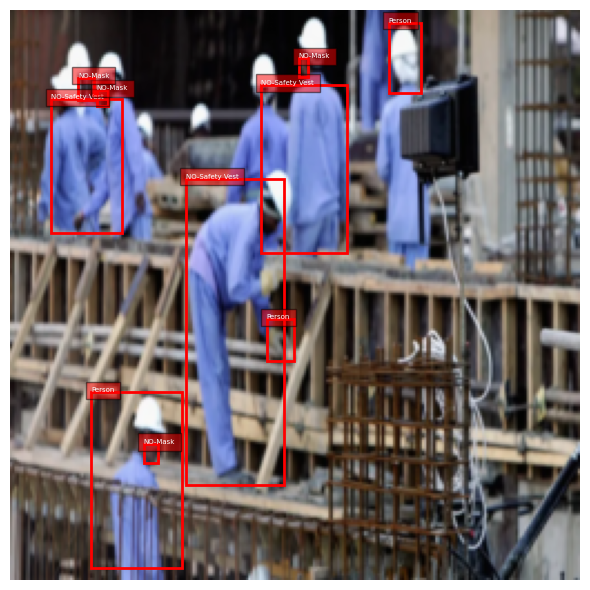

In [ ]:
model.eval()
img1 = Image.open('/content/201352051612704734_20.webp').convert("RGB")
img1 = img1.resize((640, 640), resample=Image.BILINEAR)
img1 = np.array(img1)
img1 = preprocess_data(img1)
print(img1.shape)

outputs = model(img1.unsqueeze(0).to(device))
for ix, output in enumerate(outputs):
    bbs, confs, labels = decode_output(output)
    info = [f'{l}@{c:.2f}' for l,c in zip(labels,confs)]
    show(img1.detach().cpu().permute(1,2,0), bbs=bbs,
                                      texts=labels, sz=5)

In [ ]:
torch.save(model.state_dict(),'final_model2.pth')